# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 8



Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [ ]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-04-13 05:25:53--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25430972 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.25M  --.-KB/s    in 0.1s    

2021-04-13 05:25:54 (166 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25430972/25430972]



un-tar the dataset

In [ ]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

label   youtube_id  time_start  time_end  split
0    clay pottery making  ---0dWlqevI          19        29  train
1         news anchoring  ---aQ-tA5_A           9        19  train
2  using bagging machine  ---j12rm3WI          14        24  train
3          javelin throw  --07WQ2iBlw           1        11  train
4        climbing a rope  --0NTAs-fA0          29        39  train

In [ ]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
544818           washing dishes
544819            juggling fire
544820             taking photo
544821           brush painting
544822             changing oil
Name: label, Length: 544823, dtype: object


In [ ]:
print(data[data.label == ('cleaning windows')])

                   label   youtube_id  time_start  time_end  split
563     cleaning windows  -3as098jwNs           0        10  train
1040    cleaning windows  -7MqfSPKj6c           2        12  train
1303    cleaning windows  -9QfMtbGuq0           6        16  train
1563    cleaning windows  -Bk9MdOqzTY          23        33  train
1983    cleaning windows  -FOfyuyabWQ          16        26  train
...                  ...          ...         ...       ...    ...
542454  cleaning windows  zgNV3xKWStA          86        96  train
542733  cleaning windows  ziMV2sYVg14           5        15  train
543586  cleaning windows  zoxvVbxOFws           1        11  train
544340  cleaning windows  zvKPwIVjhOA         229       239  train
544373  cleaning windows  zvWVe2cIAQ4           1        11  train

[907 rows x 5 columns]


In [ ]:
data_true = data[data.label == ('cleaning windows')]
data_true = data_true.reset_index() #get the target label information

In [ ]:
print(data[data.label != ('cleaning windows')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
544818         washing dishes  zzz_3yWpTXo           0        10  train
544819          juggling fire  zzzkS3amkWE         124       134  train
544820           taking photo  zzzsd1R7H0E           6        16  train
544821         brush painting  zzzxltuPx2Q          84        94  train
544822           changing oil  zzzzE0ncP1Y         232       242  train

[543916 rows x 5 columns]


In [ ]:
data_false = data[data.label != ('cleaning windows')]
data_false = data_false.sample(n=907, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [ ]:
data_false.shape

(907, 6)

In [ ]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
544818         washing dishes  zzz_3yWpTXo           0        10  train
544819          juggling fire  zzzkS3amkWE         124       134  train
544820           taking photo  zzzsd1R7H0E           6        16  train
544821         brush painting  zzzxltuPx2Q          84        94  train
544822           changing oil  zzzzE0ncP1Y         232       242  train

[544823 rows x 5 columns]>

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 5.7MB/s 


In [ ]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning windows'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"cleaning windows.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not cleaning windows.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -3as098jwNs: Downloading webpage
[youtube] -3as098jwNs: Downloading MPD manifest
[youtube] -7MqfSPKj6c: Downloading webpage
[youtube] -9QfMtbGuq0: Downloading webpage
[youtube] -9QfMtbGuq0: Downloading MPD manifest
[youtube] -Bk9MdOqzTY: Downloading webpage
[youtube] -Bk9MdOqzTY: Downloading MPD manifest
[youtube] -FOfyuyabWQ: Downloading webpage
[youtube] -N8D6C1qpgg: Downloading webpage
[youtube] -N8D6C1qpgg: Downloading MPD manifest
[youtube] -NqPpXchVtM: Downloading webpage
[youtube] -NqPpXchVtM: Downloading MPD manifest
[youtube] -R8VmNs5u3U: Downloading webpage
[youtube] -aiv4HXm1Cw: Downloading webpage
[youtube] -fN6cQFbu1M: Downloading webpage
[youtube] -fN6cQFbu1M: Downloading MPD manifest
[youtube] 03gAHbIaB2Q: Downloading webpage
[youtube] 03gAHbIaB2Q: Downloading MPD manifest
[youtube] 05PM1aBrb2g: Downloading webpage
[youtube] 0CQ6_x_PItI: Downloading webpage
[youtube] 0CQ6_x_PItI: Downloading MPD manifest
[youtube] 0JVGskmaJRE: Downloading webpage
[youtube] 0KN0

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4mNQnefNXfs: Downloading webpage
[youtube] 4mNQnefNXfs: Downloading MPD manifest
[youtube] 4ovJP4rM_V8: Downloading webpage
[youtube] 4pZm3UofztE: Downloading webpage
[youtube] 4qXhTfjXDJg: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4uzLANPUwuo: Downloading webpage
[youtube] 53TGKEtSLRw: Downloading webpage
[youtube] 53TGKEtSLRw: Downloading MPD manifest
[youtube] 53V5vngOkAA: Downloading webpage
[youtube] 58UunkK-FRY: Downloading webpage
[youtube] 58UunkK-FRY: Downloading MPD manifest
[youtube] 5C2kLm4knGA: Downloading webpage
[youtube] 5E49bN8e_xo: Downloading webpage
[youtube] 5E49bN8e_xo: Downloading MPD manifest
[youtube] 5UbuGkqB7A8: Downloading webpage
[youtube] 5UbuGkqB7A8: Downloading MPD manifest
[youtube] 5UxNn-to5cw: Downloading webpage
[youtube] 5UxNn-to5cw: Downloading MPD manifest
[youtube] 5_yDLlf5h0Y: Downloading webpage
[youtube] 5_yDLlf5h0Y: Downloading MPD manifest
[youtube] 5bqMpW3p8Dg: Downloading webpage
[youtube] 5bqMpW3p8Dg: Downloading MPD manifest
[youtube] 5dT06rY_lek: Downloading webpage
[youtube] 5dT06rY_lek: Downloading MPD manifest
[youtube] 5iBC0MPqZRU: Downloading webpage
[youtube] 5iBC0MPqZRU: Downloading MPD manifest
[youtube] 5jkAoaIqxaY: Downloading webpage
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 6FjgdUricEs: Downloading webpage
[youtube] 6FoDH_nRof8: Downloading webpage
[youtube] 6FoDH_nRof8: Downloading MPD manifest
[youtube] 6IVxrILnnPI: Downloading webpage
[youtube] 6KIMe5-jCmI: Downloading webpage
[youtube] 6KIMe5-jCmI: Downloading MPD manifest
[youtube] 6Kw_MKhwsBc: Downloading webpage
[youtube] 6Kw_MKhwsBc: Downloading MPD manifest
[youtube] 6NPAKpYmBNE: Downloading webpage
[youtube] 6NPAKpYmBNE: Downloading MPD manifest
[youtube] 6ORCiUfgBqg: Downloading webpage
[youtube] 6ORCiUfgBqg: Downloading MPD manifest
[youtube] 6Q5aNScn0pI: Downloading webpage
[youtube] 6Q5aNScn0pI: Downloading MPD manifest
[youtube] 6Sl20ruDwy0: Downloading webpage
[youtube] 6Sl20ruDwy0: Downloading MPD manifest
[youtube] 6Tk9EFTGjD0: Downloading webpage
[youtube] 6_KNW4C6IOs: Downloading webpage
[youtube] 6fFmBjQqtI4: Downloading webpage
[youtube] 6fFmBjQqtI4: Downloading MPD manifest
[youtube] 6gcRLtNjbP4: Downloading webpage
[youtube] 6gv-3cacjbM: Downloading webpage
[youtube] 6gv-

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 8SfpSwQzeX0: Downloading webpage
[youtube] 8SfpSwQzeX0: Downloading MPD manifest
[youtube] 8U26eEenpQo: Downloading webpage
[youtube] 8U26eEenpQo: Downloading MPD manifest
[youtube] 8UB5AK2zr6w: Downloading webpage
[youtube] 8WYy9I0b_vY: Downloading webpage
[youtube] 8bTBTvTnCWc: Downloading webpage
[youtube] 8bTBTvTnCWc: Downloading MPD manifest
[youtube] 8ciou4_tgD8: Downloading webpage
[youtube] 8ciou4_tgD8: Downloading MPD manifest
[youtube] 8svmDYC5onc: Downloading webpage
[youtube] 8svmDYC5onc: Downloading MPD manifest
[youtube] 8zh8kQ1TUsY: Downloading webpage
[youtube] 8zh8kQ1TUsY: Downloading MPD manifest
[youtube] 91-vOPhmt_E: Downloading webpage
[youtube] 97zgg7T6Azo: Downloading webpage
[youtube] 97zgg7T6Azo: Downloading MPD manifest
[youtube] 98ZbIb9j-gw: Downloading webpage
[youtube] 98ZbIb9j-gw: Downloading MPD manifest
[youtube] 9Cp3wgDE3e4: Downloading webpage
[youtube] 9Cp3wgDE3e4: Downloading MPD manifest
[youtube] 9EZKYCAOAvk: Downloading webpage
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Ak-acl4V_Dg: Downloading webpage
[youtube] Ak-acl4V_Dg: Downloading MPD manifest
[youtube] Allv25EBk1Y: Downloading webpage
[youtube] Allv25EBk1Y: Downloading MPD manifest
[youtube] B-h0InD6Cao: Downloading webpage
[youtube] B-h0InD6Cao: Downloading MPD manifest
[youtube] B2qzaDeNTkM: Downloading webpage
[youtube] B2qzaDeNTkM: Downloading MPD manifest
[youtube] B3zhTm1Y134: Downloading webpage
[youtube] B5s4uYNIM24: Downloading webpage
[youtube] B5yt72ux8zw: Downloading webpage
[youtube] B5yt72ux8zw: Downloading MPD manifest
[youtube] B9LqVHbYR2k: Downloading webpage
[youtube] B9LqVHbYR2k: Downloading MPD manifest
[youtube] BV1_YBBd-lE: Downloading webpage
[youtube] BV1_YBBd-lE: Downloading MPD manifest
[youtube] Ba46Gq1Gms0: Downloading webpage
[youtube] BbBBz_FFe7c: Downloading webpage
[youtube] BbBBz_FFe7c: Downloading MPD manifest
[youtube] Bg7ck3_VV3Y: Downloading webpage
[youtube] Bg7ck3_VV3Y: Downloading MPD manifest
[youtube] BgCuqzLQNyA: Downloading webpage
[youtube]

ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


[youtube] DaFsS7EMiOE: Downloading webpage
[youtube] DaFsS7EMiOE: Downloading MPD manifest
[youtube] DabLmrZD2zo: Downloading webpage
[youtube] DabLmrZD2zo: Downloading MPD manifest
[youtube] DasRdyFA0bU: Downloading webpage
[youtube] DasRdyFA0bU: Downloading MPD manifest
[youtube] DqnrCHj87hk: Downloading webpage
[youtube] DqnrCHj87hk: Downloading MPD manifest
[youtube] EBZPXGA6vek: Downloading webpage
[youtube] EBZPXGA6vek: Downloading MPD manifest
[youtube] EJxWhTE_ZeE: Downloading webpage
[youtube] EO72tq8YRVY: Downloading webpage
[youtube] EO72tq8YRVY: Downloading MPD manifest
[youtube] ElZza-FP3LU: Downloading webpage
[youtube] ElZza-FP3LU: Downloading MPD manifest
[youtube] Ely7ZD4CC30: Downloading webpage
[youtube] Ely7ZD4CC30: Downloading MPD manifest
[youtube] EmQMv1sBdr4: Downloading webpage
[youtube] EvW5axEQMiI: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ExuxjCQ7zFM: Downloading webpage
[youtube] ExuxjCQ7zFM: Downloading MPD manifest
[youtube] F4B6FGw0E4o: Downloading webpage
[youtube] F4fKikobd_M: Downloading webpage
[youtube] F4fKikobd_M: Downloading MPD manifest
[youtube] F5d4m7BVho0: Downloading webpage
[youtube] F5tl5J3zEZA: Downloading webpage
[youtube] F5tl5J3zEZA: Downloading MPD manifest
[youtube] F7aM0RnJR20: Downloading webpage
[youtube] F8qpqG02Mqs: Downloading webpage
[youtube] F8qpqG02Mqs: Downloading MPD manifest
[youtube] FADsYIHnCww: Downloading webpage
[youtube] FADsYIHnCww: Downloading MPD manifest
[youtube] FCFSLuCZKj4: Downloading webpage
[youtube] FGxbCocm0PA: Downloading webpage
[youtube] FIGYEQ2jpLI: Downloading webpage
[youtube] FIGYEQ2jpLI: Downloading MPD manifest
[youtube] FIlbgkyc5-A: Downloading webpage
[youtube] FIlbgkyc5-A: Downloading MPD manifest
[youtube] FQEEQYgB-pM: Downloading webpage
[youtube] FQEEQYgB-pM: Downloading MPD manifest
[youtube] FRGaYbXsyFQ: Downloading webpage
[youtube] FRcI

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] HcTSOuFepAY: Downloading webpage
[youtube] HcTSOuFepAY: Downloading MPD manifest
[youtube] HukRE7iEovY: Downloading webpage
[youtube] HzjKZpGBex8: Downloading webpage
[youtube] I134_VYp4dU: Downloading webpage
[youtube] I134_VYp4dU: Downloading MPD manifest
[youtube] I16rM3dnV38: Downloading webpage
[youtube] I7ILSlPiTVk: Downloading webpage
[youtube] I7v4Wl3OCvY: Downloading webpage
[youtube] IRHt7R4eVA8: Downloading webpage
[youtube] ISW-bbpBw70: Downloading webpage
[youtube] ISW-bbpBw70: Downloading MPD manifest
[youtube] IVBJbEbwCC0: Downloading webpage
[youtube] IVBJbEbwCC0: Downloading MPD manifest
[youtube] I_Z1vihCq7I: Downloading webpage
[youtube] I_Z1vihCq7I: Downloading MPD manifest
[youtube] IbDx8-8cE6I: Downloading webpage
[youtube] IbDx8-8cE6I: Downloading MPD manifest
[youtube] IbWIPTyuO_w: Downloading webpage
[youtube] IbWIPTyuO_w: Downloading MPD manifest
[youtube] Ib_COb0L-kY: Downloading webpage
[youtube] Ib_COb0L-kY: Downloading MPD manifest
[youtube] IeGg

[youtube] M4aoy4FjFMA: Downloading API JSON
[youtube] M4aoy4FjFMA: Downloading API JSON
[youtube] M6yrYRZD_iM: Downloading webpage


[youtube] M6yrYRZD_iM: Downloading API JSON
[youtube] M6yrYRZD_iM: Downloading MPD manifest
[youtube] M6yrYRZD_iM: Downloading API JSON
[youtube] M7v8ojjNTP0: Downloading webpage


[youtube] M7v8ojjNTP0: Downloading API JSON
[youtube] M7v8ojjNTP0: Downloading MPD manifest
[youtube] M7v8ojjNTP0: Downloading API JSON
[youtube] M8xAKPWF-hM: Downloading webpage


[youtube] M8xAKPWF-hM: Downloading API JSON
[youtube] M8xAKPWF-hM: Downloading API JSON
[youtube] M9y6XnA8-OM: Downloading webpage


[youtube] M9y6XnA8-OM: Downloading API JSON


ERROR: Video unavailable


[youtube] MBoHe6RRhJc: Downloading webpage


[youtube] MBoHe6RRhJc: Downloading API JSON
[youtube] MBoHe6RRhJc: Downloading MPD manifest
[youtube] MBoHe6RRhJc: Downloading API JSON
[youtube] MInrZGX7GZs: Downloading webpage


[youtube] MInrZGX7GZs: Downloading API JSON
[youtube] MInrZGX7GZs: Downloading API JSON
[youtube] MOXTFxA36bQ: Downloading webpage


[youtube] MOXTFxA36bQ: Downloading API JSON
[youtube] MOXTFxA36bQ: Downloading MPD manifest
[youtube] MOXTFxA36bQ: Downloading API JSON
[youtube] MSDZ2-ORlAg: Downloading webpage


[youtube] MSDZ2-ORlAg: Downloading API JSON
[youtube] MSDZ2-ORlAg: Downloading API JSON
[youtube] MXdmI0Uih5g: Downloading webpage


[youtube] MXdmI0Uih5g: Downloading API JSON
[youtube] MXdmI0Uih5g: Downloading MPD manifest
[youtube] MXdmI0Uih5g: Downloading API JSON
[youtube] MaRggWPNskY: Downloading webpage


[youtube] MaRggWPNskY: Downloading API JSON
[youtube] MaRggWPNskY: Downloading MPD manifest
[youtube] MaRggWPNskY: Downloading API JSON
[youtube] Me_M17VnQCE: Downloading webpage


[youtube] Me_M17VnQCE: Downloading API JSON
[youtube] Me_M17VnQCE: Downloading MPD manifest
[youtube] Me_M17VnQCE: Downloading API JSON
[youtube] MfjXbWKC5uA: Downloading webpage


[youtube] MfjXbWKC5uA: Downloading API JSON
[youtube] MfjXbWKC5uA: Downloading MPD manifest
[youtube] MfjXbWKC5uA: Downloading API JSON
[youtube] MllXz6YrpTY: Downloading webpage


[youtube] MllXz6YrpTY: Downloading API JSON
[youtube] MllXz6YrpTY: Downloading API JSON
[youtube] N-GC3Zf1tFA: Downloading webpage


[youtube] N-GC3Zf1tFA: Downloading API JSON
[youtube] N-GC3Zf1tFA: Downloading MPD manifest
[youtube] N-GC3Zf1tFA: Downloading API JSON
[youtube] N7dLkS6GuNg: Downloading webpage


[youtube] N7dLkS6GuNg: Downloading API JSON
[youtube] N7dLkS6GuNg: Downloading MPD manifest
[youtube] N7dLkS6GuNg: Downloading API JSON
[youtube] NDRdXzMT11A: Downloading webpage


[youtube] NDRdXzMT11A: Downloading API JSON
[youtube] NDRdXzMT11A: Downloading MPD manifest
[youtube] NDRdXzMT11A: Downloading API JSON
[youtube] NUMbQOoi2GI: Downloading webpage


[youtube] NUMbQOoi2GI: Downloading API JSON
[youtube] NUMbQOoi2GI: Downloading MPD manifest
[youtube] NUMbQOoi2GI: Downloading API JSON
[youtube] NUP7jFgzKXE: Downloading webpage


[youtube] NUP7jFgzKXE: Downloading API JSON
[youtube] NUP7jFgzKXE: Downloading MPD manifest
[youtube] NUP7jFgzKXE: Downloading API JSON
[youtube] NZ3DdO2Zb_0: Downloading webpage


[youtube] NZ3DdO2Zb_0: Downloading API JSON
[youtube] NZ3DdO2Zb_0: Downloading MPD manifest
[youtube] NZ3DdO2Zb_0: Downloading API JSON
[youtube] NZr6fSs_egI: Downloading webpage


[youtube] NZr6fSs_egI: Downloading API JSON
[youtube] NZr6fSs_egI: Downloading MPD manifest
[youtube] NZr6fSs_egI: Downloading API JSON
[youtube] Nbhxtc0-Lqs: Downloading webpage


[youtube] Nbhxtc0-Lqs: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Nc1HmQ5fdqo: Downloading webpage


[youtube] Nc1HmQ5fdqo: Downloading API JSON
[youtube] Nc1HmQ5fdqo: Downloading MPD manifest
[youtube] Nc1HmQ5fdqo: Downloading API JSON
[youtube] NcPj-GFEb28: Downloading webpage


[youtube] NcPj-GFEb28: Downloading API JSON
[youtube] NcPj-GFEb28: Downloading MPD manifest
[youtube] NcPj-GFEb28: Downloading API JSON
[youtube] Ng0yGfHXIr0: Downloading webpage


[youtube] Ng0yGfHXIr0: Downloading API JSON
[youtube] Ng0yGfHXIr0: Downloading API JSON
[youtube] NgRzgibgAU4: Downloading webpage


[youtube] NgRzgibgAU4: Downloading API JSON
[youtube] NgRzgibgAU4: Downloading MPD manifest
[youtube] NgRzgibgAU4: Downloading API JSON
[youtube] Ngm9iDXjzjc: Downloading webpage


[youtube] Ngm9iDXjzjc: Downloading API JSON
[youtube] Ngm9iDXjzjc: Downloading MPD manifest
[youtube] Ngm9iDXjzjc: Downloading API JSON
[youtube] NhKWVFbD9mo: Downloading webpage


[youtube] NhKWVFbD9mo: Downloading API JSON
[youtube] NhKWVFbD9mo: Downloading API JSON
[youtube] NiF_EiHBu80: Downloading webpage


[youtube] NiF_EiHBu80: Downloading API JSON
[youtube] NiF_EiHBu80: Downloading MPD manifest
[youtube] NiF_EiHBu80: Downloading API JSON
[youtube] NlCVLc0hEQQ: Downloading webpage


[youtube] NlCVLc0hEQQ: Downloading API JSON
[youtube] NlCVLc0hEQQ: Downloading MPD manifest
[youtube] NlCVLc0hEQQ: Downloading API JSON
[youtube] NoVUexplPxI: Downloading webpage


[youtube] NoVUexplPxI: Downloading API JSON
[youtube] NoVUexplPxI: Downloading MPD manifest
[youtube] NoVUexplPxI: Downloading API JSON
[youtube] O2rb9NEAbtA: Downloading webpage


[youtube] O2rb9NEAbtA: Downloading API JSON
[youtube] O2rb9NEAbtA: Downloading API JSON
[youtube] OFOLIwCmj0s: Downloading webpage


[youtube] OFOLIwCmj0s: Downloading API JSON
[youtube] OFOLIwCmj0s: Downloading MPD manifest
[youtube] OFOLIwCmj0s: Downloading API JSON
[youtube] OOGXI4tMV1Q: Downloading webpage


[youtube] OOGXI4tMV1Q: Downloading API JSON
[youtube] OOGXI4tMV1Q: Downloading API JSON
[youtube] OPySGA4u46s: Downloading webpage


[youtube] OPySGA4u46s: Downloading API JSON
[youtube] OPySGA4u46s: Downloading API JSON
[youtube] OZ6_17uTBlc: Downloading webpage


[youtube] OZ6_17uTBlc: Downloading API JSON
[youtube] OZ6_17uTBlc: Downloading API JSON
[youtube] OZfLFt3ZEMQ: Downloading webpage


[youtube] OZfLFt3ZEMQ: Downloading API JSON
[youtube] OZfLFt3ZEMQ: Downloading API JSON
[youtube] OapKgJsVx_U: Downloading webpage


[youtube] OapKgJsVx_U: Downloading API JSON
[youtube] OapKgJsVx_U: Downloading MPD manifest
[youtube] OapKgJsVx_U: Downloading API JSON
[youtube] OcAnq9d1Ts0: Downloading webpage


[youtube] OcAnq9d1Ts0: Downloading API JSON
[youtube] OcAnq9d1Ts0: Downloading MPD manifest
[youtube] OcAnq9d1Ts0: Downloading API JSON


ERROR: requested format not available


[youtube] OiN3AgBVB80: Downloading webpage


[youtube] OiN3AgBVB80: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ok1DDt9kiC0: Downloading webpage


[youtube] Ok1DDt9kiC0: Downloading API JSON
[youtube] Ok1DDt9kiC0: Downloading MPD manifest
[youtube] Ok1DDt9kiC0: Downloading API JSON
[youtube] OkjgIFol_qQ: Downloading webpage


[youtube] OkjgIFol_qQ: Downloading API JSON
[youtube] OkjgIFol_qQ: Downloading MPD manifest
[youtube] OkjgIFol_qQ: Downloading API JSON
[youtube] Om4TLai55TU: Downloading webpage


[youtube] Om4TLai55TU: Downloading API JSON
[youtube] Om4TLai55TU: Downloading API JSON
[youtube] Otk7p3tVLr8: Downloading webpage


[youtube] Otk7p3tVLr8: Downloading API JSON
[youtube] Otk7p3tVLr8: Downloading API JSON
[youtube] P6l-m8sr2gU: Downloading webpage


[youtube] P6l-m8sr2gU: Downloading API JSON
[youtube] P6l-m8sr2gU: Downloading API JSON
[youtube] P7dso1l4Gro: Downloading webpage


[youtube] P7dso1l4Gro: Downloading API JSON
[youtube] P7dso1l4Gro: Downloading MPD manifest
[youtube] P7dso1l4Gro: Downloading API JSON


ERROR: requested format not available


[youtube] P92GqSFe3aA: Downloading webpage


[youtube] P92GqSFe3aA: Downloading API JSON
[youtube] P92GqSFe3aA: Downloading MPD manifest
[youtube] P92GqSFe3aA: Downloading API JSON
[youtube] PJQ7LuBYbQ0: Downloading webpage


[youtube] PJQ7LuBYbQ0: Downloading API JSON
[youtube] PJQ7LuBYbQ0: Downloading API JSON
[youtube] PSKvwLB3-WI: Downloading webpage


[youtube] PSKvwLB3-WI: Downloading API JSON
[youtube] PSKvwLB3-WI: Downloading MPD manifest
[youtube] PSKvwLB3-WI: Downloading API JSON
[youtube] PTBJbB5W3c0: Downloading webpage


[youtube] PTBJbB5W3c0: Downloading API JSON
[youtube] PTBJbB5W3c0: Downloading API JSON
[youtube] PXBQOKxzEbs: Downloading webpage


[youtube] PXBQOKxzEbs: Downloading API JSON
[youtube] PXBQOKxzEbs: Downloading MPD manifest
[youtube] PXBQOKxzEbs: Downloading API JSON
[youtube] PdxzpxJTA7k: Downloading webpage


[youtube] PdxzpxJTA7k: Downloading API JSON
[youtube] PdxzpxJTA7k: Downloading MPD manifest
[youtube] PdxzpxJTA7k: Downloading API JSON
[youtube] Pfg7d45kVAg: Downloading webpage


[youtube] Pfg7d45kVAg: Downloading API JSON
[youtube] Pfg7d45kVAg: Downloading MPD manifest
[youtube] Pfg7d45kVAg: Downloading API JSON
[youtube] PjJhrY9r6vM: Downloading webpage


[youtube] PjJhrY9r6vM: Downloading API JSON
[youtube] PjJhrY9r6vM: Downloading API JSON
[youtube] PxCVGlDA20o: Downloading webpage


[youtube] PxCVGlDA20o: Downloading API JSON


ERROR: Video unavailable


[youtube] Q2CHkwO7k84: Downloading webpage


[youtube] Q2CHkwO7k84: Downloading API JSON
[youtube] Q2CHkwO7k84: Downloading API JSON
[youtube] Q3ofPDKisSc: Downloading webpage


[youtube] Q3ofPDKisSc: Downloading API JSON
[youtube] Q3ofPDKisSc: Downloading MPD manifest
[youtube] Q3ofPDKisSc: Downloading API JSON
[youtube] QKRXJt_gc7U: Downloading webpage


[youtube] QKRXJt_gc7U: Downloading API JSON
[youtube] QKRXJt_gc7U: Downloading MPD manifest
[youtube] QKRXJt_gc7U: Downloading API JSON
[youtube] QLMnyQW-wFU: Downloading webpage


[youtube] QLMnyQW-wFU: Downloading API JSON
[youtube] QLMnyQW-wFU: Downloading MPD manifest
[youtube] QLMnyQW-wFU: Downloading API JSON
[youtube] QM8eFaqIQGE: Downloading webpage


[youtube] QM8eFaqIQGE: Downloading API JSON
[youtube] QM8eFaqIQGE: Downloading MPD manifest
[youtube] QM8eFaqIQGE: Downloading API JSON
[youtube] QRXgksnCuW0: Downloading webpage


[youtube] QRXgksnCuW0: Downloading API JSON
[youtube] QRXgksnCuW0: Downloading API JSON
[youtube] QUe6GJ7HtIQ: Downloading webpage


[youtube] QUe6GJ7HtIQ: Downloading API JSON
[youtube] QUe6GJ7HtIQ: Downloading API JSON
[youtube] QVCVxKd3rZM: Downloading webpage


[youtube] QVCVxKd3rZM: Downloading API JSON
[youtube] QVCVxKd3rZM: Downloading API JSON
[youtube] QXfJ7xEVX5w: Downloading webpage


[youtube] QXfJ7xEVX5w: Downloading API JSON
[youtube] QXfJ7xEVX5w: Downloading MPD manifest
[youtube] QXfJ7xEVX5w: Downloading API JSON
[youtube] QXuILnbM4oo: Downloading webpage


[youtube] QXuILnbM4oo: Downloading API JSON
[youtube] QXuILnbM4oo: Downloading MPD manifest
[youtube] QXuILnbM4oo: Downloading API JSON
[youtube] QYydFOakBY0: Downloading webpage


[youtube] QYydFOakBY0: Downloading API JSON
[youtube] QYydFOakBY0: Downloading MPD manifest
[youtube] QYydFOakBY0: Downloading API JSON
[youtube] Q__NWTbHB44: Downloading webpage


[youtube] Q__NWTbHB44: Downloading API JSON
[youtube] Q__NWTbHB44: Downloading API JSON
[youtube] QaVEStbFMN0: Downloading webpage


[youtube] QaVEStbFMN0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] QqTvcF8ihWA: Downloading webpage


[youtube] QqTvcF8ihWA: Downloading API JSON
[youtube] QqTvcF8ihWA: Downloading MPD manifest
[youtube] QqTvcF8ihWA: Downloading API JSON
[youtube] Qz2q4DuR-XI: Downloading webpage


[youtube] Qz2q4DuR-XI: Downloading API JSON
[youtube] Qz2q4DuR-XI: Downloading MPD manifest
[youtube] Qz2q4DuR-XI: Downloading API JSON
[youtube] R0dFpC6LIl0: Downloading webpage


[youtube] R0dFpC6LIl0: Downloading API JSON
[youtube] R0dFpC6LIl0: Downloading MPD manifest
[youtube] R0dFpC6LIl0: Downloading API JSON
[youtube] R1ZPAACgolo: Downloading webpage


[youtube] R1ZPAACgolo: Downloading API JSON
[youtube] R1ZPAACgolo: Downloading API JSON
[youtube] R5FJyYpl_WA: Downloading webpage


[youtube] R5FJyYpl_WA: Downloading API JSON
[youtube] R5FJyYpl_WA: Downloading MPD manifest
[youtube] R5FJyYpl_WA: Downloading API JSON
[youtube] RBlDwvocnW4: Downloading webpage


[youtube] RBlDwvocnW4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] RFw09yEo8Sk: Downloading webpage


[youtube] RFw09yEo8Sk: Downloading API JSON
[youtube] RFw09yEo8Sk: Downloading API JSON
[youtube] RG1dVRHVHiw: Downloading webpage


[youtube] RG1dVRHVHiw: Downloading API JSON
[youtube] RG1dVRHVHiw: Downloading MPD manifest
[youtube] RG1dVRHVHiw: Downloading API JSON
[youtube] RPbL3IK2w1A: Downloading webpage


[youtube] RPbL3IK2w1A: Downloading API JSON
[youtube] RPbL3IK2w1A: Downloading MPD manifest
[youtube] RPbL3IK2w1A: Downloading API JSON


ERROR: requested format not available


[youtube] RQ6kkFKGAd0: Downloading webpage


[youtube] RQ6kkFKGAd0: Downloading API JSON
[youtube] RQ6kkFKGAd0: Downloading API JSON
[youtube] RbqRKyJt3Uk: Downloading webpage


[youtube] RbqRKyJt3Uk: Downloading API JSON
[youtube] RbqRKyJt3Uk: Downloading MPD manifest
[youtube] RbqRKyJt3Uk: Downloading API JSON
[youtube] Rczg7AOVajw: Downloading webpage


[youtube] Rczg7AOVajw: Downloading API JSON
[youtube] Rczg7AOVajw: Downloading API JSON
[youtube] ReuR4Xrlc10: Downloading webpage


[youtube] ReuR4Xrlc10: Downloading API JSON
[youtube] ReuR4Xrlc10: Downloading MPD manifest
[youtube] ReuR4Xrlc10: Downloading API JSON
[youtube] RgZlqlnSPKw: Downloading webpage


[youtube] RgZlqlnSPKw: Downloading API JSON
[youtube] RgZlqlnSPKw: Downloading MPD manifest
[youtube] RgZlqlnSPKw: Downloading API JSON


ERROR: requested format not available


[youtube] RjrMXPapPT4: Downloading webpage


[youtube] RjrMXPapPT4: Downloading API JSON
[youtube] RjrMXPapPT4: Downloading MPD manifest
[youtube] RjrMXPapPT4: Downloading API JSON
[youtube] RnPoikO2P6U: Downloading webpage


[youtube] RnPoikO2P6U: Downloading API JSON
[youtube] RnPoikO2P6U: Downloading API JSON
[youtube] Rq2AIyh99A0: Downloading webpage


[youtube] Rq2AIyh99A0: Downloading API JSON
[youtube] Rq2AIyh99A0: Downloading API JSON
[youtube] RqtF07L0xPM: Downloading webpage


[youtube] RqtF07L0xPM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] RrDrcIsPgTU: Downloading webpage


[youtube] RrDrcIsPgTU: Downloading API JSON
[youtube] RrDrcIsPgTU: Downloading MPD manifest
[youtube] RrDrcIsPgTU: Downloading API JSON
[youtube] RvrMgOWmYlc: Downloading webpage


[youtube] RvrMgOWmYlc: Downloading API JSON
[youtube] RvrMgOWmYlc: Downloading MPD manifest
[youtube] RvrMgOWmYlc: Downloading API JSON
[youtube] RzfkatD31uM: Downloading webpage


[youtube] RzfkatD31uM: Downloading API JSON
[youtube] RzfkatD31uM: Downloading API JSON
[youtube] S0XGsSC78P8: Downloading webpage


[youtube] S0XGsSC78P8: Downloading API JSON
[youtube] S0XGsSC78P8: Downloading MPD manifest
[youtube] S0XGsSC78P8: Downloading API JSON
[youtube] SBYUUdn7hgw: Downloading webpage


[youtube] SBYUUdn7hgw: Downloading API JSON
[youtube] SBYUUdn7hgw: Downloading MPD manifest
[youtube] SBYUUdn7hgw: Downloading API JSON
[youtube] SIJUWnfcwlE: Downloading webpage


[youtube] SIJUWnfcwlE: Downloading API JSON
[youtube] SIJUWnfcwlE: Downloading API JSON
[youtube] SIjdRhi4SUs: Downloading webpage


[youtube] SIjdRhi4SUs: Downloading API JSON
[youtube] SIjdRhi4SUs: Downloading MPD manifest
[youtube] SIjdRhi4SUs: Downloading API JSON
[youtube] SJX0-WPV6YE: Downloading webpage


[youtube] SJX0-WPV6YE: Downloading API JSON
[youtube] SJX0-WPV6YE: Downloading API JSON
[youtube] Sc1LTJZbgp0: Downloading webpage


[youtube] Sc1LTJZbgp0: Downloading API JSON
[youtube] Sc1LTJZbgp0: Downloading API JSON
[youtube] SeyNMXzI4IM: Downloading webpage


[youtube] SeyNMXzI4IM: Downloading API JSON
[youtube] SeyNMXzI4IM: Downloading MPD manifest
[youtube] SeyNMXzI4IM: Downloading API JSON
[youtube] SnWRmui2KMQ: Downloading webpage


[youtube] SnWRmui2KMQ: Downloading API JSON
[youtube] SnWRmui2KMQ: Downloading MPD manifest
[youtube] SnWRmui2KMQ: Downloading API JSON
[youtube] Sv9GIKujhtk: Downloading webpage


[youtube] Sv9GIKujhtk: Downloading API JSON
[youtube] Sv9GIKujhtk: Downloading MPD manifest
[youtube] Sv9GIKujhtk: Downloading API JSON
[youtube] Swj8W5thLb4: Downloading webpage


[youtube] Swj8W5thLb4: Downloading API JSON
[youtube] Swj8W5thLb4: Downloading API JSON
[youtube] T5zRSZqFQQw: Downloading webpage


[youtube] T5zRSZqFQQw: Downloading API JSON
[youtube] T5zRSZqFQQw: Downloading API JSON
[youtube] T68QiYgErT4: Downloading webpage


[youtube] T68QiYgErT4: Downloading API JSON
[youtube] T68QiYgErT4: Downloading API JSON
[youtube] TIakS5NXLYs: Downloading webpage


[youtube] TIakS5NXLYs: Downloading API JSON
[youtube] TIakS5NXLYs: Downloading API JSON
[youtube] TL6ProvPAPM: Downloading webpage


[youtube] TL6ProvPAPM: Downloading API JSON
[youtube] TL6ProvPAPM: Downloading MPD manifest
[youtube] TL6ProvPAPM: Downloading API JSON
[youtube] TajbcE_schY: Downloading webpage


[youtube] TajbcE_schY: Downloading API JSON
[youtube] TajbcE_schY: Downloading API JSON
[youtube] Tf44B4DuJDY: Downloading webpage


[youtube] Tf44B4DuJDY: Downloading API JSON
[youtube] Tf44B4DuJDY: Downloading MPD manifest
[youtube] Tf44B4DuJDY: Downloading API JSON
[youtube] TgI8-GJ3tIM: Downloading webpage


[youtube] TgI8-GJ3tIM: Downloading API JSON
[youtube] TgI8-GJ3tIM: Downloading MPD manifest
[youtube] TgI8-GJ3tIM: Downloading API JSON
[youtube] Tkrj52GC8Lo: Downloading webpage


[youtube] Tkrj52GC8Lo: Downloading API JSON
[youtube] Tkrj52GC8Lo: Downloading MPD manifest
[youtube] Tkrj52GC8Lo: Downloading API JSON


ERROR: requested format not available


[youtube] TraGzqN58ps: Downloading webpage


[youtube] TraGzqN58ps: Downloading API JSON
[youtube] TraGzqN58ps: Downloading API JSON
[youtube] Ty98m3X-eqA: Downloading webpage


[youtube] Ty98m3X-eqA: Downloading API JSON
[youtube] Ty98m3X-eqA: Downloading MPD manifest
[youtube] Ty98m3X-eqA: Downloading API JSON
[youtube] U9P4XaCBzIY: Downloading webpage


[youtube] U9P4XaCBzIY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] UDjQuMloNJo: Downloading webpage


[youtube] UDjQuMloNJo: Downloading API JSON
[youtube] UDjQuMloNJo: Downloading MPD manifest
[youtube] UDjQuMloNJo: Downloading API JSON
[youtube] UE3f-NT4MBA: Downloading webpage


[youtube] UE3f-NT4MBA: Downloading API JSON
[youtube] UE3f-NT4MBA: Downloading MPD manifest
[youtube] UE3f-NT4MBA: Downloading API JSON
[youtube] UI5XzgvxO24: Downloading webpage


[youtube] UI5XzgvxO24: Downloading API JSON
[youtube] UI5XzgvxO24: Downloading MPD manifest
[youtube] UI5XzgvxO24: Downloading API JSON
[youtube] UMBNoqVFDw4: Downloading webpage


[youtube] UMBNoqVFDw4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UPG167i-wdk: Downloading webpage


[youtube] UPG167i-wdk: Downloading API JSON
[youtube] UPG167i-wdk: Downloading API JSON
[youtube] UPHhBfx0L34: Downloading webpage


[youtube] UPHhBfx0L34: Downloading API JSON
[youtube] UPHhBfx0L34: Downloading MPD manifest
[youtube] UPHhBfx0L34: Downloading API JSON
[youtube] UdVxQeTbeXk: Downloading webpage


[youtube] UdVxQeTbeXk: Downloading API JSON
[youtube] UdVxQeTbeXk: Downloading MPD manifest
[youtube] UdVxQeTbeXk: Downloading API JSON
[youtube] UivzkE_jdGk: Downloading webpage


[youtube] UivzkE_jdGk: Downloading API JSON
[youtube] UivzkE_jdGk: Downloading MPD manifest
[youtube] UivzkE_jdGk: Downloading API JSON


ERROR: requested format not available


[youtube] Uj9hJqmxhBg: Downloading webpage


[youtube] Uj9hJqmxhBg: Downloading API JSON
[youtube] Uj9hJqmxhBg: Downloading MPD manifest
[youtube] Uj9hJqmxhBg: Downloading API JSON
[youtube] Uo6B9zqkxTo: Downloading webpage


[youtube] Uo6B9zqkxTo: Downloading API JSON
[youtube] Uo6B9zqkxTo: Downloading API JSON
[youtube] Uo6Z1esEL6I: Downloading webpage


[youtube] Uo6Z1esEL6I: Downloading API JSON
[youtube] Uo6Z1esEL6I: Downloading MPD manifest
[youtube] Uo6Z1esEL6I: Downloading API JSON
[youtube] Uv0dt_-fWJU: Downloading webpage


[youtube] Uv0dt_-fWJU: Downloading API JSON
[youtube] Uv0dt_-fWJU: Downloading API JSON
[youtube] V0PNJme2e2E: Downloading webpage


[youtube] V0PNJme2e2E: Downloading API JSON
[youtube] V0PNJme2e2E: Downloading MPD manifest
[youtube] V0PNJme2e2E: Downloading API JSON
[youtube] V5NLzzlEL1M: Downloading webpage


[youtube] V5NLzzlEL1M: Downloading API JSON
[youtube] V5NLzzlEL1M: Downloading MPD manifest
[youtube] V5NLzzlEL1M: Downloading API JSON
[youtube] V6s9eMtUnME: Downloading webpage


[youtube] V6s9eMtUnME: Downloading API JSON
[youtube] V6s9eMtUnME: Downloading API JSON
[youtube] V9Q3L6OD2Kw: Downloading webpage


[youtube] V9Q3L6OD2Kw: Downloading API JSON
[youtube] V9Q3L6OD2Kw: Downloading API JSON
[youtube] VBSAGSBDHF0: Downloading webpage


[youtube] VBSAGSBDHF0: Downloading API JSON
[youtube] VBSAGSBDHF0: Downloading MPD manifest
[youtube] VBSAGSBDHF0: Downloading API JSON
[youtube] VFnch4YNmMc: Downloading webpage


[youtube] VFnch4YNmMc: Downloading API JSON
[youtube] VFnch4YNmMc: Downloading MPD manifest
[youtube] VFnch4YNmMc: Downloading API JSON
[youtube] VG8o1phkXvg: Downloading webpage


[youtube] VG8o1phkXvg: Downloading API JSON
[youtube] VG8o1phkXvg: Downloading MPD manifest
[youtube] VG8o1phkXvg: Downloading API JSON
[youtube] VHAs-dxm5zg: Downloading webpage


[youtube] VHAs-dxm5zg: Downloading API JSON
[youtube] VHAs-dxm5zg: Downloading API JSON
[youtube] VHGJXOQW_c0: Downloading webpage


[youtube] VHGJXOQW_c0: Downloading API JSON
[youtube] VHGJXOQW_c0: Downloading MPD manifest
[youtube] VHGJXOQW_c0: Downloading API JSON
[youtube] VJwDG6HRr-Q: Downloading webpage


[youtube] VJwDG6HRr-Q: Downloading API JSON
[youtube] VJwDG6HRr-Q: Downloading MPD manifest
[youtube] VJwDG6HRr-Q: Downloading API JSON
[youtube] VOvoKMuzUY4: Downloading webpage


[youtube] VOvoKMuzUY4: Downloading API JSON
[youtube] VOvoKMuzUY4: Downloading API JSON
[youtube] VQyb6ijdkks: Downloading webpage


[youtube] VQyb6ijdkks: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] VXqSVV_-XB0: Downloading webpage


[youtube] VXqSVV_-XB0: Downloading API JSON
[youtube] VXqSVV_-XB0: Downloading API JSON
[youtube] VaOHdApsZyU: Downloading webpage


[youtube] VaOHdApsZyU: Downloading API JSON
[youtube] VaOHdApsZyU: Downloading API JSON
[youtube] VjqwKH7iBbU: Downloading webpage


[youtube] VjqwKH7iBbU: Downloading API JSON
[youtube] VjqwKH7iBbU: Downloading MPD manifest
[youtube] VjqwKH7iBbU: Downloading API JSON


ERROR: requested format not available


[youtube] VoG3gsoTrl8: Downloading webpage


[youtube] VoG3gsoTrl8: Downloading API JSON
[youtube] VoG3gsoTrl8: Downloading MPD manifest
[youtube] VoG3gsoTrl8: Downloading API JSON
[youtube] VoVUBgU1reU: Downloading webpage


[youtube] VoVUBgU1reU: Downloading API JSON
[youtube] VoVUBgU1reU: Downloading API JSON
[youtube] W76MoFKNGy0: Downloading webpage


[youtube] W76MoFKNGy0: Downloading API JSON
[youtube] W76MoFKNGy0: Downloading MPD manifest
[youtube] W76MoFKNGy0: Downloading API JSON
[youtube] W79RlHtTPyM: Downloading webpage


[youtube] W79RlHtTPyM: Downloading API JSON
[youtube] W79RlHtTPyM: Downloading MPD manifest
[youtube] W79RlHtTPyM: Downloading API JSON
[youtube] WAo0uqgDUUo: Downloading webpage


[youtube] WAo0uqgDUUo: Downloading API JSON
[youtube] WAo0uqgDUUo: Downloading MPD manifest
[youtube] WAo0uqgDUUo: Downloading API JSON
[youtube] WDfq1-2g0J8: Downloading webpage


[youtube] WDfq1-2g0J8: Downloading API JSON
[youtube] WDfq1-2g0J8: Downloading MPD manifest
[youtube] WDfq1-2g0J8: Downloading API JSON
[youtube] WHudirhH774: Downloading webpage


[youtube] WHudirhH774: Downloading API JSON
[youtube] WHudirhH774: Downloading MPD manifest
[youtube] WHudirhH774: Downloading API JSON
[youtube] WIEbSRusKbs: Downloading webpage


[youtube] WIEbSRusKbs: Downloading API JSON
[youtube] WIEbSRusKbs: Downloading MPD manifest
[youtube] WIEbSRusKbs: Downloading API JSON
[youtube] WJZ6O5o3PY4: Downloading webpage


[youtube] WJZ6O5o3PY4: Downloading API JSON
[youtube] WJZ6O5o3PY4: Downloading MPD manifest
[youtube] WJZ6O5o3PY4: Downloading API JSON


ERROR: requested format not available


[youtube] WTBcvDzVw_8: Downloading webpage


[youtube] WTBcvDzVw_8: Downloading API JSON
[youtube] WTBcvDzVw_8: Downloading MPD manifest
[youtube] WTBcvDzVw_8: Downloading API JSON
[youtube] WhGgKMoCGow: Downloading webpage


[youtube] WhGgKMoCGow: Downloading API JSON
[youtube] WhGgKMoCGow: Downloading MPD manifest
[youtube] WhGgKMoCGow: Downloading API JSON
[youtube] WhqhppGLCko: Downloading webpage


[youtube] WhqhppGLCko: Downloading API JSON
[youtube] WhqhppGLCko: Downloading MPD manifest
[youtube] WhqhppGLCko: Downloading API JSON


ERROR: requested format not available


[youtube] WrbOLWzInns: Downloading webpage


[youtube] WrbOLWzInns: Downloading API JSON
[youtube] WrbOLWzInns: Downloading API JSON
[youtube] X0kMTDKAEjc: Downloading webpage


[youtube] X0kMTDKAEjc: Downloading API JSON
[youtube] X0kMTDKAEjc: Downloading MPD manifest
[youtube] X0kMTDKAEjc: Downloading API JSON
[youtube] X1ewm6NGP8Y: Downloading webpage


[youtube] X1ewm6NGP8Y: Downloading API JSON
[youtube] X1ewm6NGP8Y: Downloading API JSON
[youtube] X25-cG22Mqc: Downloading webpage


[youtube] X25-cG22Mqc: Downloading API JSON
[youtube] X25-cG22Mqc: Downloading MPD manifest
[youtube] X25-cG22Mqc: Downloading API JSON
[youtube] X2xjYgRUXwM: Downloading webpage


[youtube] X2xjYgRUXwM: Downloading API JSON
[youtube] X2xjYgRUXwM: Downloading MPD manifest
[youtube] X2xjYgRUXwM: Downloading API JSON
[youtube] X4JsKpVTBvQ: Downloading webpage


[youtube] X4JsKpVTBvQ: Downloading API JSON
[youtube] X4JsKpVTBvQ: Downloading MPD manifest
[youtube] X4JsKpVTBvQ: Downloading API JSON
[youtube] XAd7NjaIP7s: Downloading webpage


[youtube] XAd7NjaIP7s: Downloading API JSON
[youtube] XAd7NjaIP7s: Downloading API JSON
[youtube] XBYanEA7fOY: Downloading webpage


[youtube] XBYanEA7fOY: Downloading API JSON
[youtube] XBYanEA7fOY: Downloading API JSON
[youtube] XEj0qajz5eM: Downloading webpage


[youtube] XEj0qajz5eM: Downloading API JSON
[youtube] XEj0qajz5eM: Downloading API JSON
[youtube] XL5HWSb7z-U: Downloading webpage


[youtube] XL5HWSb7z-U: Downloading API JSON
[youtube] XL5HWSb7z-U: Downloading API JSON
[youtube] XRhWzeqndko: Downloading webpage


[youtube] XRhWzeqndko: Downloading API JSON
[youtube] XRhWzeqndko: Downloading API JSON
[youtube] XW9BYBUeass: Downloading webpage


[youtube] XW9BYBUeass: Downloading API JSON
[youtube] XW9BYBUeass: Downloading API JSON
[youtube] XZ0KrnUQZRA: Downloading webpage


[youtube] XZ0KrnUQZRA: Downloading API JSON
[youtube] XZ0KrnUQZRA: Downloading API JSON
[youtube] Xar8YzRSPEE: Downloading webpage


[youtube] Xar8YzRSPEE: Downloading API JSON
[youtube] Xar8YzRSPEE: Downloading MPD manifest
[youtube] Xar8YzRSPEE: Downloading API JSON
[youtube] Xdkr92lbke4: Downloading webpage


[youtube] Xdkr92lbke4: Downloading API JSON
[youtube] Xdkr92lbke4: Downloading MPD manifest
[youtube] Xdkr92lbke4: Downloading API JSON
[youtube] XlA8s0aF_Y0: Downloading webpage


[youtube] XlA8s0aF_Y0: Downloading API JSON
[youtube] XlA8s0aF_Y0: Downloading MPD manifest
[youtube] XlA8s0aF_Y0: Downloading API JSON
[youtube] Xpme5FzIDsw: Downloading webpage


[youtube] Xpme5FzIDsw: Downloading API JSON
[youtube] Xpme5FzIDsw: Downloading MPD manifest
[youtube] Xpme5FzIDsw: Downloading API JSON
[youtube] XxKDUUee2bw: Downloading webpage


[youtube] XxKDUUee2bw: Downloading API JSON
[youtube] XxKDUUee2bw: Downloading API JSON
[youtube] Y2pWHX0iVJE: Downloading webpage


[youtube] Y2pWHX0iVJE: Downloading API JSON
[youtube] Y2pWHX0iVJE: Downloading MPD manifest
[youtube] Y2pWHX0iVJE: Downloading API JSON
[youtube] Y3goVMMc05k: Downloading webpage


[youtube] Y3goVMMc05k: Downloading API JSON
[youtube] Y3goVMMc05k: Downloading API JSON
[youtube] Y67Of7ilPG8: Downloading webpage


[youtube] Y67Of7ilPG8: Downloading API JSON
[youtube] Y67Of7ilPG8: Downloading MPD manifest
[youtube] Y67Of7ilPG8: Downloading API JSON
[youtube] Y8DkYh3iYl0: Downloading webpage


[youtube] Y8DkYh3iYl0: Downloading API JSON
[youtube] Y8DkYh3iYl0: Downloading API JSON
[youtube] Y9DopiTq_-I: Downloading webpage


[youtube] Y9DopiTq_-I: Downloading API JSON
[youtube] Y9DopiTq_-I: Downloading MPD manifest
[youtube] Y9DopiTq_-I: Downloading API JSON
[youtube] YCQl3CrG2Lo: Downloading webpage


[youtube] YCQl3CrG2Lo: Downloading API JSON
[youtube] YCQl3CrG2Lo: Downloading MPD manifest
[youtube] YCQl3CrG2Lo: Downloading API JSON
[youtube] YG8tw3oZYas: Downloading webpage


[youtube] YG8tw3oZYas: Downloading API JSON
[youtube] YG8tw3oZYas: Downloading MPD manifest
[youtube] YG8tw3oZYas: Downloading API JSON
[youtube] YGLQf1qv0wc: Downloading webpage


[youtube] YGLQf1qv0wc: Downloading API JSON
[youtube] YGLQf1qv0wc: Downloading MPD manifest
[youtube] YGLQf1qv0wc: Downloading API JSON
[youtube] YH6_t2u8iNM: Downloading webpage


[youtube] YH6_t2u8iNM: Downloading API JSON
[youtube] YH6_t2u8iNM: Downloading MPD manifest
[youtube] YH6_t2u8iNM: Downloading API JSON
[youtube] YJ6C41ZlKhE: Downloading webpage


[youtube] YJ6C41ZlKhE: Downloading API JSON
[youtube] YJ6C41ZlKhE: Downloading MPD manifest
[youtube] YJ6C41ZlKhE: Downloading API JSON
[youtube] YNU7VvZ_G8o: Downloading webpage


[youtube] YNU7VvZ_G8o: Downloading API JSON
[youtube] YNU7VvZ_G8o: Downloading MPD manifest
[youtube] YNU7VvZ_G8o: Downloading API JSON
[youtube] YaQHdrF8u8w: Downloading webpage


[youtube] YaQHdrF8u8w: Downloading API JSON
[youtube] YaQHdrF8u8w: Downloading API JSON
[youtube] Yc6hhZmKGYc: Downloading webpage


[youtube] Yc6hhZmKGYc: Downloading API JSON
[youtube] Yc6hhZmKGYc: Downloading API JSON
[youtube] Ydq33m7CoWI: Downloading webpage


[youtube] Ydq33m7CoWI: Downloading API JSON
[youtube] Ydq33m7CoWI: Downloading API JSON
[youtube] YeNNQs5uHxE: Downloading webpage


[youtube] YeNNQs5uHxE: Downloading API JSON
[youtube] YeNNQs5uHxE: Downloading API JSON
[youtube] Yj_C76ELWPY: Downloading webpage


[youtube] Yj_C76ELWPY: Downloading API JSON
[youtube] Yj_C76ELWPY: Downloading API JSON
[youtube] Yk_4d83mUy0: Downloading webpage


[youtube] Yk_4d83mUy0: Downloading API JSON
[youtube] Yk_4d83mUy0: Downloading MPD manifest
[youtube] Yk_4d83mUy0: Downloading API JSON
[youtube] YqEwgZlrPXQ: Downloading webpage


[youtube] YqEwgZlrPXQ: Downloading API JSON
[youtube] YqEwgZlrPXQ: Downloading MPD manifest
[youtube] YqEwgZlrPXQ: Downloading API JSON
[youtube] YuMMyAH0zRg: Downloading webpage


[youtube] YuMMyAH0zRg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] YuMr129saOA: Downloading webpage


[youtube] YuMr129saOA: Downloading API JSON
[youtube] YuMr129saOA: Downloading API JSON
[youtube] YvyWwe9e_Kk: Downloading webpage


[youtube] YvyWwe9e_Kk: Downloading API JSON
[youtube] YvyWwe9e_Kk: Downloading MPD manifest
[youtube] YvyWwe9e_Kk: Downloading API JSON
[youtube] YxXp_QU6cJ0: Downloading webpage


[youtube] YxXp_QU6cJ0: Downloading API JSON
[youtube] YxXp_QU6cJ0: Downloading MPD manifest
[youtube] YxXp_QU6cJ0: Downloading API JSON
[youtube] YydUGoO_ZZU: Downloading webpage


[youtube] YydUGoO_ZZU: Downloading API JSON
[youtube] YydUGoO_ZZU: Downloading API JSON
[youtube] Z-BdojQSEyA: Downloading webpage


[youtube] Z-BdojQSEyA: Downloading API JSON
[youtube] Z-BdojQSEyA: Downloading MPD manifest
[youtube] Z-BdojQSEyA: Downloading API JSON
[youtube] Z0GbQKiufUE: Downloading webpage


[youtube] Z0GbQKiufUE: Downloading API JSON
[youtube] Z0GbQKiufUE: Downloading API JSON
[youtube] Z1Ce4pXRU0k: Downloading webpage


[youtube] Z1Ce4pXRU0k: Downloading API JSON
[youtube] Z1Ce4pXRU0k: Downloading MPD manifest
[youtube] Z1Ce4pXRU0k: Downloading API JSON
[youtube] Z1QnaUSK8ck: Downloading webpage


[youtube] Z1QnaUSK8ck: Downloading API JSON
[youtube] Z1QnaUSK8ck: Downloading MPD manifest
[youtube] Z1QnaUSK8ck: Downloading API JSON
[youtube] Z3XbJCxhS14: Downloading webpage


[youtube] Z3XbJCxhS14: Downloading API JSON
[youtube] Z3XbJCxhS14: Downloading API JSON
[youtube] Z8DJEzkTBCk: Downloading webpage


[youtube] Z8DJEzkTBCk: Downloading API JSON
[youtube] Z8DJEzkTBCk: Downloading MPD manifest
[youtube] Z8DJEzkTBCk: Downloading API JSON
[youtube] Z8QrA66UVzI: Downloading webpage


[youtube] Z8QrA66UVzI: Downloading API JSON
[youtube] Z8QrA66UVzI: Downloading API JSON
[youtube] Z91A5FIWeUo: Downloading webpage


[youtube] Z91A5FIWeUo: Downloading API JSON
[youtube] Z91A5FIWeUo: Downloading MPD manifest
[youtube] Z91A5FIWeUo: Downloading API JSON
[youtube] ZA8MirJslus: Downloading webpage


[youtube] ZA8MirJslus: Downloading API JSON
[youtube] ZA8MirJslus: Downloading MPD manifest
[youtube] ZA8MirJslus: Downloading API JSON
[youtube] ZB_EzbiCEg0: Downloading webpage


[youtube] ZB_EzbiCEg0: Downloading API JSON
[youtube] ZB_EzbiCEg0: Downloading MPD manifest
[youtube] ZB_EzbiCEg0: Downloading API JSON
[youtube] ZCD8q3185zw: Downloading webpage


[youtube] ZCD8q3185zw: Downloading API JSON
[youtube] ZCD8q3185zw: Downloading MPD manifest
[youtube] ZCD8q3185zw: Downloading API JSON
[youtube] ZKCpxtvWn68: Downloading webpage


[youtube] ZKCpxtvWn68: Downloading API JSON
[youtube] ZKCpxtvWn68: Downloading API JSON
[youtube] Zdnca58JD_U: Downloading webpage


[youtube] Zdnca58JD_U: Downloading API JSON
[youtube] Zdnca58JD_U: Downloading API JSON
[youtube] ZlQf9aR80f8: Downloading webpage


[youtube] ZlQf9aR80f8: Downloading API JSON
[youtube] ZlQf9aR80f8: Downloading MPD manifest
[youtube] ZlQf9aR80f8: Downloading API JSON
[youtube] Zp-hFxdKmdA: Downloading webpage


[youtube] Zp-hFxdKmdA: Downloading API JSON
[youtube] Zp-hFxdKmdA: Downloading MPD manifest
[youtube] Zp-hFxdKmdA: Downloading API JSON
[youtube] ZpLRkfD4tfI: Downloading webpage


[youtube] ZpLRkfD4tfI: Downloading API JSON
[youtube] ZpLRkfD4tfI: Downloading MPD manifest
[youtube] ZpLRkfD4tfI: Downloading API JSON
[youtube] ZqlAPN0DEl4: Downloading webpage


[youtube] ZqlAPN0DEl4: Downloading API JSON
[youtube] ZqlAPN0DEl4: Downloading MPD manifest
[youtube] ZqlAPN0DEl4: Downloading API JSON
[youtube] Zs5IMpK_qok: Downloading webpage


[youtube] Zs5IMpK_qok: Downloading API JSON
[youtube] Zs5IMpK_qok: Downloading MPD manifest
[youtube] Zs5IMpK_qok: Downloading API JSON
[youtube] _01AdGP2xTA: Downloading webpage


[youtube] _01AdGP2xTA: Downloading API JSON
[youtube] _01AdGP2xTA: Downloading MPD manifest
[youtube] _01AdGP2xTA: Downloading API JSON
[youtube] _3V-RIUgcg0: Downloading webpage


[youtube] _3V-RIUgcg0: Downloading API JSON
[youtube] _3V-RIUgcg0: Downloading MPD manifest
[youtube] _3V-RIUgcg0: Downloading API JSON
[youtube] _4dP2RGD4e0: Downloading webpage


[youtube] _4dP2RGD4e0: Downloading API JSON
[youtube] _4dP2RGD4e0: Downloading API JSON
[youtube] _C3u_7ABSXs: Downloading webpage


[youtube] _C3u_7ABSXs: Downloading API JSON
[youtube] _C3u_7ABSXs: Downloading MPD manifest
[youtube] _C3u_7ABSXs: Downloading API JSON
[youtube] _D5biNVIvnA: Downloading webpage


[youtube] _D5biNVIvnA: Downloading API JSON
[youtube] _D5biNVIvnA: Downloading MPD manifest
[youtube] _D5biNVIvnA: Downloading API JSON
[youtube] _LQ9fI1kZOc: Downloading webpage


[youtube] _LQ9fI1kZOc: Downloading API JSON
[youtube] _LQ9fI1kZOc: Downloading MPD manifest
[youtube] _LQ9fI1kZOc: Downloading API JSON
[youtube] _NFPJ3fss0s: Downloading webpage


[youtube] _NFPJ3fss0s: Downloading API JSON
[youtube] _NFPJ3fss0s: Downloading MPD manifest
[youtube] _NFPJ3fss0s: Downloading API JSON
[youtube] _NkrTBOsqwk: Downloading webpage


[youtube] _NkrTBOsqwk: Downloading API JSON
[youtube] _NkrTBOsqwk: Downloading MPD manifest
[youtube] _NkrTBOsqwk: Downloading API JSON
[youtube] _QZlbj5sImY: Downloading webpage


[youtube] _QZlbj5sImY: Downloading API JSON
[youtube] _QZlbj5sImY: Downloading MPD manifest
[youtube] _QZlbj5sImY: Downloading API JSON


ERROR: requested format not available


[youtube] _X5IknZq2EM: Downloading webpage


[youtube] _X5IknZq2EM: Downloading API JSON
[youtube] _X5IknZq2EM: Downloading MPD manifest
[youtube] _X5IknZq2EM: Downloading API JSON
[youtube] _csFzSIvu-M: Downloading webpage


[youtube] _csFzSIvu-M: Downloading API JSON
[youtube] _csFzSIvu-M: Downloading API JSON
[youtube] _dVS8WB3HCc: Downloading webpage


[youtube] _dVS8WB3HCc: Downloading API JSON
[youtube] _dVS8WB3HCc: Downloading MPD manifest
[youtube] _dVS8WB3HCc: Downloading API JSON
[youtube] _ed8EBO7s_A: Downloading webpage


[youtube] _ed8EBO7s_A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _fs2TYXqZEo: Downloading webpage


[youtube] _fs2TYXqZEo: Downloading API JSON
[youtube] _fs2TYXqZEo: Downloading API JSON
[youtube] _ftbUi4sPOE: Downloading webpage


[youtube] _ftbUi4sPOE: Downloading API JSON
[youtube] _ftbUi4sPOE: Downloading API JSON
[youtube] _gSqHsldVPA: Downloading webpage


[youtube] _gSqHsldVPA: Downloading API JSON
[youtube] _gSqHsldVPA: Downloading MPD manifest
[youtube] _gSqHsldVPA: Downloading API JSON
[youtube] _hhyqYYawIQ: Downloading webpage


[youtube] _hhyqYYawIQ: Downloading API JSON
[youtube] _hhyqYYawIQ: Downloading API JSON
[youtube] _mhkLVNOEUY: Downloading webpage


[youtube] _mhkLVNOEUY: Downloading API JSON
[youtube] _mhkLVNOEUY: Downloading MPD manifest
[youtube] _mhkLVNOEUY: Downloading API JSON
[youtube] _nEDqPjFCAU: Downloading webpage


[youtube] _nEDqPjFCAU: Downloading API JSON
[youtube] _nEDqPjFCAU: Downloading API JSON
[youtube] _ofELhZBckU: Downloading webpage


[youtube] _ofELhZBckU: Downloading API JSON
[youtube] _ofELhZBckU: Downloading API JSON
[youtube] _tW_bIJgDSw: Downloading webpage


[youtube] _tW_bIJgDSw: Downloading API JSON
[youtube] _tW_bIJgDSw: Downloading MPD manifest
[youtube] _tW_bIJgDSw: Downloading API JSON
[youtube] a3gUVG1b0R0: Downloading webpage


[youtube] a3gUVG1b0R0: Downloading API JSON
[youtube] a3gUVG1b0R0: Downloading MPD manifest
[youtube] a3gUVG1b0R0: Downloading API JSON
[youtube] a6H8EvI-mhw: Downloading webpage


[youtube] a6H8EvI-mhw: Downloading API JSON
[youtube] a6H8EvI-mhw: Downloading MPD manifest
[youtube] a6H8EvI-mhw: Downloading API JSON
[youtube] a9Ng_skf2AQ: Downloading webpage


[youtube] a9Ng_skf2AQ: Downloading API JSON
[youtube] a9Ng_skf2AQ: Downloading MPD manifest
[youtube] a9Ng_skf2AQ: Downloading API JSON
[youtube] aBByXlWaSh0: Downloading webpage


[youtube] aBByXlWaSh0: Downloading API JSON
[youtube] aBByXlWaSh0: Downloading MPD manifest
[youtube] aBByXlWaSh0: Downloading API JSON
[youtube] aSZzyQ6vMNc: Downloading webpage


[youtube] aSZzyQ6vMNc: Downloading API JSON
[youtube] aSZzyQ6vMNc: Downloading MPD manifest
[youtube] aSZzyQ6vMNc: Downloading API JSON
[youtube] aajm-32AjWw: Downloading webpage


[youtube] aajm-32AjWw: Downloading API JSON
[youtube] aajm-32AjWw: Downloading API JSON
[youtube] ab6xM25RnS4: Downloading webpage


[youtube] ab6xM25RnS4: Downloading API JSON
[youtube] ab6xM25RnS4: Downloading MPD manifest
[youtube] ab6xM25RnS4: Downloading API JSON
[youtube] afqTXxdhJ_U: Downloading webpage


[youtube] afqTXxdhJ_U: Downloading API JSON
[youtube] afqTXxdhJ_U: Downloading API JSON
[youtube] alnSuLlHrjk: Downloading webpage


[youtube] alnSuLlHrjk: Downloading API JSON
[youtube] alnSuLlHrjk: Downloading API JSON
[youtube] arLeRdzI1pU: Downloading webpage


[youtube] arLeRdzI1pU: Downloading API JSON
[youtube] arLeRdzI1pU: Downloading MPD manifest
[youtube] arLeRdzI1pU: Downloading API JSON
[youtube] au_hPMm9g-Y: Downloading webpage


[youtube] au_hPMm9g-Y: Downloading API JSON
[youtube] au_hPMm9g-Y: Downloading MPD manifest
[youtube] au_hPMm9g-Y: Downloading API JSON
[youtube] b-CHWQ-Uhe4: Downloading webpage


[youtube] b-CHWQ-Uhe4: Downloading API JSON
[youtube] b-CHWQ-Uhe4: Downloading API JSON
[youtube] b06QBM98elo: Downloading webpage


[youtube] b06QBM98elo: Downloading API JSON
[youtube] b06QBM98elo: Downloading MPD manifest
[youtube] b06QBM98elo: Downloading API JSON


ERROR: requested format not available


[youtube] b3kU8KaJTCg: Downloading webpage


[youtube] b3kU8KaJTCg: Downloading API JSON
[youtube] b3kU8KaJTCg: Downloading API JSON
[youtube] b4iS9qgtqbI: Downloading webpage


[youtube] b4iS9qgtqbI: Downloading API JSON
[youtube] b4iS9qgtqbI: Downloading MPD manifest
[youtube] b4iS9qgtqbI: Downloading API JSON


ERROR: requested format not available


[youtube] b6Vf4CIC7Nc: Downloading webpage


[youtube] b6Vf4CIC7Nc: Downloading API JSON
[youtube] b6Vf4CIC7Nc: Downloading API JSON
[youtube] b7zwn8bP7aA: Downloading webpage


[youtube] b7zwn8bP7aA: Downloading API JSON
[youtube] b7zwn8bP7aA: Downloading MPD manifest
[youtube] b7zwn8bP7aA: Downloading API JSON
[youtube] b8xUVALHyy0: Downloading webpage


[youtube] b8xUVALHyy0: Downloading API JSON
[youtube] b8xUVALHyy0: Downloading MPD manifest
[youtube] b8xUVALHyy0: Downloading API JSON
[youtube] bdmIkRGCggM: Downloading webpage


[youtube] bdmIkRGCggM: Downloading API JSON
[youtube] bdmIkRGCggM: Downloading API JSON
[youtube] bkhqKVYNuqk: Downloading webpage


[youtube] bkhqKVYNuqk: Downloading API JSON
[youtube] bkhqKVYNuqk: Downloading API JSON
[youtube] brHs2J6d3dc: Downloading webpage


[youtube] brHs2J6d3dc: Downloading API JSON
[youtube] brHs2J6d3dc: Downloading MPD manifest
[youtube] brHs2J6d3dc: Downloading API JSON
[youtube] buFD-goctc0: Downloading webpage


[youtube] buFD-goctc0: Downloading API JSON
[youtube] buFD-goctc0: Downloading API JSON
[youtube] c-jzRDkGty8: Downloading webpage


[youtube] c-jzRDkGty8: Downloading API JSON
[youtube] c-jzRDkGty8: Downloading MPD manifest
[youtube] c-jzRDkGty8: Downloading API JSON
[youtube] c5nipS4kfK4: Downloading webpage


[youtube] c5nipS4kfK4: Downloading API JSON
[youtube] c5nipS4kfK4: Downloading MPD manifest
[youtube] c5nipS4kfK4: Downloading API JSON
[youtube] cATXtDTbRH4: Downloading webpage


[youtube] cATXtDTbRH4: Downloading API JSON
[youtube] cATXtDTbRH4: Downloading API JSON
[youtube] cE9jN1_FdSs: Downloading webpage


[youtube] cE9jN1_FdSs: Downloading API JSON
[youtube] cE9jN1_FdSs: Downloading MPD manifest
[youtube] cE9jN1_FdSs: Downloading API JSON
[youtube] cbvbkgsHVkk: Downloading webpage


[youtube] cbvbkgsHVkk: Downloading API JSON
[youtube] cbvbkgsHVkk: Downloading MPD manifest
[youtube] cbvbkgsHVkk: Downloading API JSON
[youtube] ccL-RZLJepI: Downloading webpage


[youtube] ccL-RZLJepI: Downloading API JSON
[youtube] ccL-RZLJepI: Downloading API JSON
[youtube] cfhVyK2X-S8: Downloading webpage


[youtube] cfhVyK2X-S8: Downloading API JSON
[youtube] cfhVyK2X-S8: Downloading MPD manifest
[youtube] cfhVyK2X-S8: Downloading API JSON
[youtube] cl23OKWxK5k: Downloading webpage


[youtube] cl23OKWxK5k: Downloading API JSON
[youtube] cl23OKWxK5k: Downloading MPD manifest
[youtube] cl23OKWxK5k: Downloading API JSON


ERROR: requested format not available


[youtube] cu1ECdkz0HY: Downloading webpage


[youtube] cu1ECdkz0HY: Downloading API JSON
[youtube] cu1ECdkz0HY: Downloading MPD manifest
[youtube] cu1ECdkz0HY: Downloading API JSON
[youtube] d1dkp8x226Y: Downloading webpage


[youtube] d1dkp8x226Y: Downloading API JSON
[youtube] d1dkp8x226Y: Downloading MPD manifest
[youtube] d1dkp8x226Y: Downloading API JSON
[youtube] dFjxEXU3XaY: Downloading webpage


[youtube] dFjxEXU3XaY: Downloading API JSON
[youtube] dFjxEXU3XaY: Downloading MPD manifest
[youtube] dFjxEXU3XaY: Downloading API JSON
[youtube] dG5fs53SI9A: Downloading webpage


[youtube] dG5fs53SI9A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] dJIpLweJlI0: Downloading webpage


[youtube] dJIpLweJlI0: Downloading API JSON
[youtube] dJIpLweJlI0: Downloading API JSON
[youtube] dSnBQiVpSFM: Downloading webpage


[youtube] dSnBQiVpSFM: Downloading API JSON
[youtube] dSnBQiVpSFM: Downloading MPD manifest
[youtube] dSnBQiVpSFM: Downloading API JSON
[youtube] dUdYS5KeODc: Downloading webpage


[youtube] dUdYS5KeODc: Downloading API JSON
[youtube] dUdYS5KeODc: Downloading API JSON
[youtube] db65hoiiJV4: Downloading webpage


[youtube] db65hoiiJV4: Downloading API JSON
[youtube] db65hoiiJV4: Downloading MPD manifest
[youtube] db65hoiiJV4: Downloading API JSON
[youtube] dbBSQKtzsm0: Downloading webpage


[youtube] dbBSQKtzsm0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ddSufuatT80: Downloading webpage


[youtube] ddSufuatT80: Downloading API JSON
[youtube] ddSufuatT80: Downloading MPD manifest
[youtube] ddSufuatT80: Downloading API JSON
[youtube] ddU0TtyDXpY: Downloading webpage


[youtube] ddU0TtyDXpY: Downloading API JSON
[youtube] ddU0TtyDXpY: Downloading MPD manifest
[youtube] ddU0TtyDXpY: Downloading API JSON
[youtube] dmIP0StFz0Y: Downloading webpage


[youtube] dmIP0StFz0Y: Downloading API JSON
[youtube] dmIP0StFz0Y: Downloading MPD manifest
[youtube] dmIP0StFz0Y: Downloading API JSON


ERROR: requested format not available


[youtube] dv7qp5rOGpM: Downloading webpage


[youtube] dv7qp5rOGpM: Downloading API JSON
[youtube] dv7qp5rOGpM: Downloading API JSON
[youtube] e8DbCc14MhI: Downloading webpage


[youtube] e8DbCc14MhI: Downloading API JSON
[youtube] e8DbCc14MhI: Downloading MPD manifest
[youtube] e8DbCc14MhI: Downloading API JSON
[youtube] eDrLGfEOdXo: Downloading webpage


[youtube] eDrLGfEOdXo: Downloading API JSON
[youtube] eDrLGfEOdXo: Downloading API JSON
[youtube] eFDVayR_suI: Downloading webpage


[youtube] eFDVayR_suI: Downloading API JSON
[youtube] eFDVayR_suI: Downloading MPD manifest
[youtube] eFDVayR_suI: Downloading API JSON


ERROR: requested format not available


[youtube] eHnEuzpucuM: Downloading webpage


[youtube] eHnEuzpucuM: Downloading API JSON
[youtube] eHnEuzpucuM: Downloading MPD manifest
[youtube] eHnEuzpucuM: Downloading API JSON
[youtube] eQBXkYGtFts: Downloading webpage


[youtube] eQBXkYGtFts: Downloading API JSON
[youtube] eQBXkYGtFts: Downloading MPD manifest
[youtube] eQBXkYGtFts: Downloading API JSON
[youtube] eYHUehSiaV4: Downloading webpage


[youtube] eYHUehSiaV4: Downloading API JSON
[youtube] eYHUehSiaV4: Downloading API JSON
[youtube] eYgdz2cPNK0: Downloading webpage


[youtube] eYgdz2cPNK0: Downloading API JSON
[youtube] eYgdz2cPNK0: Downloading MPD manifest
[youtube] eYgdz2cPNK0: Downloading API JSON


ERROR: requested format not available


[youtube] ebWaQyi_F8g: Downloading webpage


[youtube] ebWaQyi_F8g: Downloading API JSON
[youtube] ebWaQyi_F8g: Downloading MPD manifest
[youtube] ebWaQyi_F8g: Downloading API JSON
[youtube] edWbys20Cdw: Downloading webpage


[youtube] edWbys20Cdw: Downloading API JSON
[youtube] edWbys20Cdw: Downloading API JSON
[youtube] elFy3BckjJI: Downloading webpage


[youtube] elFy3BckjJI: Downloading API JSON
[youtube] elFy3BckjJI: Downloading MPD manifest
[youtube] elFy3BckjJI: Downloading API JSON
[youtube] f-tlocRHsJg: Downloading webpage


[youtube] f-tlocRHsJg: Downloading API JSON
[youtube] f-tlocRHsJg: Downloading API JSON
[youtube] f2uDdbJlS7M: Downloading webpage


[youtube] f2uDdbJlS7M: Downloading API JSON
[youtube] f2uDdbJlS7M: Downloading MPD manifest
[youtube] f2uDdbJlS7M: Downloading API JSON
[youtube] fCRNqI2sCwg: Downloading webpage


[youtube] fCRNqI2sCwg: Downloading API JSON
[youtube] fCRNqI2sCwg: Downloading MPD manifest
[youtube] fCRNqI2sCwg: Downloading API JSON
[youtube] fE0IMwcSGsU: Downloading webpage


[youtube] fE0IMwcSGsU: Downloading API JSON
[youtube] fE0IMwcSGsU: Downloading API JSON
[youtube] fFoyq_Kdm5Q: Downloading webpage


[youtube] fFoyq_Kdm5Q: Downloading API JSON
[youtube] fFoyq_Kdm5Q: Downloading API JSON
[youtube] fHQ03J1B6vA: Downloading webpage


[youtube] fHQ03J1B6vA: Downloading API JSON
[youtube] fHQ03J1B6vA: Downloading MPD manifest
[youtube] fHQ03J1B6vA: Downloading API JSON
[youtube] fYRTNyi_Nic: Downloading webpage


[youtube] fYRTNyi_Nic: Downloading API JSON
[youtube] fYRTNyi_Nic: Downloading MPD manifest
[youtube] fYRTNyi_Nic: Downloading API JSON
[youtube] fcdp-gFc9Q8: Downloading webpage


[youtube] fcdp-gFc9Q8: Downloading API JSON
[youtube] fcdp-gFc9Q8: Downloading API JSON
[youtube] ffKUfxZHbYk: Downloading webpage


[youtube] ffKUfxZHbYk: Downloading API JSON
[youtube] ffKUfxZHbYk: Downloading MPD manifest
[youtube] ffKUfxZHbYk: Downloading API JSON
[youtube] foLZF7I7mZU: Downloading webpage


[youtube] foLZF7I7mZU: Downloading API JSON
[youtube] foLZF7I7mZU: Downloading API JSON
[youtube] g-gOPfCsLx4: Downloading webpage


[youtube] g-gOPfCsLx4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] g01xhbZBGSw: Downloading webpage


[youtube] g01xhbZBGSw: Downloading API JSON
[youtube] g01xhbZBGSw: Downloading MPD manifest
[youtube] g01xhbZBGSw: Downloading API JSON


ERROR: requested format not available


[youtube] g0rNdpfYc9c: Downloading webpage


[youtube] g0rNdpfYc9c: Downloading API JSON
[youtube] g0rNdpfYc9c: Downloading MPD manifest
[youtube] g0rNdpfYc9c: Downloading API JSON


ERROR: requested format not available


[youtube] g7l_x0Nxc7E: Downloading webpage


[youtube] g7l_x0Nxc7E: Downloading API JSON
[youtube] g7l_x0Nxc7E: Downloading MPD manifest
[youtube] g7l_x0Nxc7E: Downloading API JSON
[youtube] g9XLOpSmr3o: Downloading webpage


[youtube] g9XLOpSmr3o: Downloading API JSON


ERROR: Video unavailable


[youtube] gCWWwNgc8pA: Downloading webpage


[youtube] gCWWwNgc8pA: Downloading API JSON
[youtube] gCWWwNgc8pA: Downloading MPD manifest
[youtube] gCWWwNgc8pA: Downloading API JSON
[youtube] gHQKdzSPM_0: Downloading webpage


[youtube] gHQKdzSPM_0: Downloading API JSON
[youtube] gHQKdzSPM_0: Downloading API JSON
[youtube] gOQymgH-3vE: Downloading webpage


[youtube] gOQymgH-3vE: Downloading API JSON
[youtube] gOQymgH-3vE: Downloading API JSON
[youtube] g_pXkgt618M: Downloading webpage


[youtube] g_pXkgt618M: Downloading API JSON
[youtube] g_pXkgt618M: Downloading MPD manifest
[youtube] g_pXkgt618M: Downloading API JSON
[youtube] gcW4uVP8Cos: Downloading webpage


[youtube] gcW4uVP8Cos: Downloading API JSON
[youtube] gcW4uVP8Cos: Downloading MPD manifest
[youtube] gcW4uVP8Cos: Downloading API JSON
[youtube] gdRrgCx2zEE: Downloading webpage


[youtube] gdRrgCx2zEE: Downloading API JSON
[youtube] gdRrgCx2zEE: Downloading MPD manifest
[youtube] gdRrgCx2zEE: Downloading API JSON
[youtube] gmRb11vMatc: Downloading webpage


[youtube] gmRb11vMatc: Downloading API JSON
[youtube] gmRb11vMatc: Downloading API JSON
[youtube] h3Q9-AbZdRE: Downloading webpage


[youtube] h3Q9-AbZdRE: Downloading API JSON
[youtube] h3Q9-AbZdRE: Downloading API JSON
[youtube] h7AeoqNPB8A: Downloading webpage


[youtube] h7AeoqNPB8A: Downloading API JSON
[youtube] h7AeoqNPB8A: Downloading MPD manifest
[youtube] h7AeoqNPB8A: Downloading API JSON
[youtube] h7dS8Ex1VBU: Downloading webpage


[youtube] h7dS8Ex1VBU: Downloading API JSON
[youtube] h7dS8Ex1VBU: Downloading MPD manifest
[youtube] h7dS8Ex1VBU: Downloading API JSON
[youtube] h9PihJKnXxE: Downloading webpage


[youtube] h9PihJKnXxE: Downloading API JSON
[youtube] h9PihJKnXxE: Downloading MPD manifest
[youtube] h9PihJKnXxE: Downloading API JSON
[youtube] hAujAvXnnv8: Downloading webpage


[youtube] hAujAvXnnv8: Downloading API JSON
[youtube] hAujAvXnnv8: Downloading MPD manifest
[youtube] hAujAvXnnv8: Downloading API JSON
[youtube] hGdc0x2ahh8: Downloading webpage


[youtube] hGdc0x2ahh8: Downloading API JSON
[youtube] hGdc0x2ahh8: Downloading MPD manifest
[youtube] hGdc0x2ahh8: Downloading API JSON
[youtube] hIOXUJqTyNY: Downloading webpage


[youtube] hIOXUJqTyNY: Downloading API JSON
[youtube] hIOXUJqTyNY: Downloading MPD manifest
[youtube] hIOXUJqTyNY: Downloading API JSON
[youtube] hOi94VafL3M: Downloading webpage


[youtube] hOi94VafL3M: Downloading API JSON
[youtube] hOi94VafL3M: Downloading MPD manifest
[youtube] hOi94VafL3M: Downloading API JSON
[youtube] hR1nVMHVkqQ: Downloading webpage


[youtube] hR1nVMHVkqQ: Downloading API JSON
[youtube] hR1nVMHVkqQ: Downloading MPD manifest
[youtube] hR1nVMHVkqQ: Downloading API JSON
[youtube] hY3RgR_-kp8: Downloading webpage


[youtube] hY3RgR_-kp8: Downloading API JSON
[youtube] hY3RgR_-kp8: Downloading API JSON
[youtube] hao9mgk_VqQ: Downloading webpage


[youtube] hao9mgk_VqQ: Downloading API JSON
[youtube] hao9mgk_VqQ: Downloading MPD manifest
[youtube] hao9mgk_VqQ: Downloading API JSON
[youtube] hbIXmS9myx8: Downloading webpage


[youtube] hbIXmS9myx8: Downloading API JSON
[youtube] hbIXmS9myx8: Downloading API JSON
[youtube] hhEmjbnyk3A: Downloading webpage


[youtube] hhEmjbnyk3A: Downloading API JSON
[youtube] hhEmjbnyk3A: Downloading MPD manifest
[youtube] hhEmjbnyk3A: Downloading API JSON
[youtube] i7RbIVOEW9w: Downloading webpage


[youtube] i7RbIVOEW9w: Downloading API JSON
[youtube] i7RbIVOEW9w: Downloading MPD manifest
[youtube] i7RbIVOEW9w: Downloading API JSON
[youtube] iCkrK-nW-Fk: Downloading webpage


[youtube] iCkrK-nW-Fk: Downloading API JSON
[youtube] iCkrK-nW-Fk: Downloading MPD manifest
[youtube] iCkrK-nW-Fk: Downloading API JSON
[youtube] iEUA1vvIdKQ: Downloading webpage


[youtube] iEUA1vvIdKQ: Downloading API JSON
[youtube] iEUA1vvIdKQ: Downloading API JSON
[youtube] iK8mDpUWZb4: Downloading webpage


[youtube] iK8mDpUWZb4: Downloading API JSON
[youtube] iK8mDpUWZb4: Downloading API JSON
[youtube] iM8yJfIRc8c: Downloading webpage


[youtube] iM8yJfIRc8c: Downloading API JSON
[youtube] iM8yJfIRc8c: Downloading MPD manifest
[youtube] iM8yJfIRc8c: Downloading API JSON
[youtube] iN7BkU85WaQ: Downloading webpage


[youtube] iN7BkU85WaQ: Downloading API JSON
[youtube] iN7BkU85WaQ: Downloading MPD manifest
[youtube] iN7BkU85WaQ: Downloading API JSON


ERROR: requested format not available


[youtube] iO0I90wWwVA: Downloading webpage


[youtube] iO0I90wWwVA: Downloading API JSON
[youtube] iO0I90wWwVA: Downloading MPD manifest
[youtube] iO0I90wWwVA: Downloading API JSON
[youtube] iOo5XeXgs6U: Downloading webpage


[youtube] iOo5XeXgs6U: Downloading API JSON
[youtube] iOo5XeXgs6U: Downloading MPD manifest
[youtube] iOo5XeXgs6U: Downloading API JSON
[youtube] iXgvSW1g9Ac: Downloading webpage


[youtube] iXgvSW1g9Ac: Downloading API JSON
[youtube] iXgvSW1g9Ac: Downloading MPD manifest
[youtube] iXgvSW1g9Ac: Downloading API JSON
[youtube] ic5adlQD8g0: Downloading webpage


[youtube] ic5adlQD8g0: Downloading API JSON
[youtube] ic5adlQD8g0: Downloading API JSON
[youtube] igWCQKl39dE: Downloading webpage


[youtube] igWCQKl39dE: Downloading API JSON
[youtube] igWCQKl39dE: Downloading MPD manifest
[youtube] igWCQKl39dE: Downloading API JSON
[youtube] ixo30kPy_vw: Downloading webpage


[youtube] ixo30kPy_vw: Downloading API JSON
[youtube] ixo30kPy_vw: Downloading MPD manifest
[youtube] ixo30kPy_vw: Downloading API JSON
[youtube] iz5GQpwOZpk: Downloading webpage


[youtube] iz5GQpwOZpk: Downloading API JSON
[youtube] iz5GQpwOZpk: Downloading MPD manifest
[youtube] iz5GQpwOZpk: Downloading API JSON
[youtube] j-CVaBFCMv4: Downloading webpage


[youtube] j-CVaBFCMv4: Downloading API JSON
[youtube] j-CVaBFCMv4: Downloading MPD manifest
[youtube] j-CVaBFCMv4: Downloading API JSON
[youtube] j3uTHIVOlYM: Downloading webpage


[youtube] j3uTHIVOlYM: Downloading API JSON
[youtube] j3uTHIVOlYM: Downloading MPD manifest
[youtube] j3uTHIVOlYM: Downloading API JSON
[youtube] j5n_pIu78F0: Downloading webpage


[youtube] j5n_pIu78F0: Downloading API JSON
[youtube] j5n_pIu78F0: Downloading MPD manifest
[youtube] j5n_pIu78F0: Downloading API JSON
[youtube] j6c1uBQf-Ic: Downloading webpage


[youtube] j6c1uBQf-Ic: Downloading API JSON
[youtube] j6c1uBQf-Ic: Downloading MPD manifest
[youtube] j6c1uBQf-Ic: Downloading API JSON
[youtube] jBRcnIo2OoE: Downloading webpage


[youtube] jBRcnIo2OoE: Downloading API JSON
[youtube] jBRcnIo2OoE: Downloading MPD manifest
[youtube] jBRcnIo2OoE: Downloading API JSON
[youtube] jDVGKLDv0P8: Downloading webpage


[youtube] jDVGKLDv0P8: Downloading API JSON
[youtube] jDVGKLDv0P8: Downloading MPD manifest
[youtube] jDVGKLDv0P8: Downloading API JSON
[youtube] jF7BmXVkFMQ: Downloading webpage


[youtube] jF7BmXVkFMQ: Downloading API JSON
[youtube] jF7BmXVkFMQ: Downloading API JSON
[youtube] jG8ADxBDmx0: Downloading webpage


[youtube] jG8ADxBDmx0: Downloading API JSON
[youtube] jG8ADxBDmx0: Downloading API JSON
[youtube] jIwEkMWm-mQ: Downloading webpage


[youtube] jIwEkMWm-mQ: Downloading API JSON
[youtube] jIwEkMWm-mQ: Downloading MPD manifest
[youtube] jIwEkMWm-mQ: Downloading API JSON
[youtube] jNmO9vbrIlY: Downloading webpage


[youtube] jNmO9vbrIlY: Downloading API JSON
[youtube] jNmO9vbrIlY: Downloading MPD manifest
[youtube] jNmO9vbrIlY: Downloading API JSON
[youtube] jNw0ZBI9DDU: Downloading webpage


[youtube] jNw0ZBI9DDU: Downloading API JSON
[youtube] jNw0ZBI9DDU: Downloading MPD manifest
[youtube] jNw0ZBI9DDU: Downloading API JSON
[youtube] jPZ48Tk20oY: Downloading webpage


[youtube] jPZ48Tk20oY: Downloading API JSON
[youtube] jPZ48Tk20oY: Downloading API JSON
[youtube] jR42BFxlCJY: Downloading webpage


[youtube] jR42BFxlCJY: Downloading API JSON
[youtube] jR42BFxlCJY: Downloading MPD manifest
[youtube] jR42BFxlCJY: Downloading API JSON
[youtube] jbkqsBj7zvg: Downloading webpage


[youtube] jbkqsBj7zvg: Downloading API JSON
[youtube] jbkqsBj7zvg: Downloading MPD manifest
[youtube] jbkqsBj7zvg: Downloading API JSON
[youtube] jfMuVEvet2Y: Downloading webpage


[youtube] jfMuVEvet2Y: Downloading API JSON
[youtube] jfMuVEvet2Y: Downloading MPD manifest
[youtube] jfMuVEvet2Y: Downloading API JSON
[youtube] jh8q9dDxmpQ: Downloading webpage


[youtube] jh8q9dDxmpQ: Downloading API JSON
[youtube] jh8q9dDxmpQ: Downloading MPD manifest
[youtube] jh8q9dDxmpQ: Downloading API JSON
[youtube] k39TipJDZak: Downloading webpage


[youtube] k39TipJDZak: Downloading API JSON
[youtube] k39TipJDZak: Downloading MPD manifest
[youtube] k39TipJDZak: Downloading API JSON
[youtube] k3i8clYZ0VM: Downloading webpage


[youtube] k3i8clYZ0VM: Downloading API JSON
[youtube] k3i8clYZ0VM: Downloading MPD manifest
[youtube] k3i8clYZ0VM: Downloading API JSON
[youtube] k4shRiOs4tE: Downloading webpage


[youtube] k4shRiOs4tE: Downloading API JSON
[youtube] k4shRiOs4tE: Downloading MPD manifest
[youtube] k4shRiOs4tE: Downloading API JSON
[youtube] k6VX8CTt2aM: Downloading webpage


[youtube] k6VX8CTt2aM: Downloading API JSON
[youtube] k6VX8CTt2aM: Downloading MPD manifest
[youtube] k6VX8CTt2aM: Downloading API JSON
[youtube] k7aQZB3Z3eU: Downloading webpage


[youtube] k7aQZB3Z3eU: Downloading API JSON
[youtube] k7aQZB3Z3eU: Downloading MPD manifest
[youtube] k7aQZB3Z3eU: Downloading API JSON
[youtube] kEMGEmfXp3A: Downloading webpage


[youtube] kEMGEmfXp3A: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] kNiwzl-50oI: Downloading webpage


[youtube] kNiwzl-50oI: Downloading API JSON
[youtube] kNiwzl-50oI: Downloading API JSON
[youtube] kOX5JAiSc-A: Downloading webpage


[youtube] kOX5JAiSc-A: Downloading API JSON
[youtube] kOX5JAiSc-A: Downloading MPD manifest
[youtube] kOX5JAiSc-A: Downloading API JSON
[youtube] kSwxEchcie0: Downloading webpage


[youtube] kSwxEchcie0: Downloading API JSON
[youtube] kSwxEchcie0: Downloading MPD manifest
[youtube] kSwxEchcie0: Downloading API JSON


ERROR: requested format not available


[youtube] kli7ZPH2vOs: Downloading webpage


[youtube] kli7ZPH2vOs: Downloading API JSON
[youtube] kli7ZPH2vOs: Downloading MPD manifest
[youtube] kli7ZPH2vOs: Downloading API JSON
[youtube] kltSPHYVvu8: Downloading webpage


[youtube] kltSPHYVvu8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] kwwaOtWM2Gw: Downloading webpage


[youtube] kwwaOtWM2Gw: Downloading API JSON
[youtube] kwwaOtWM2Gw: Downloading MPD manifest
[youtube] kwwaOtWM2Gw: Downloading API JSON
[youtube] l1UNDuQTYUs: Downloading webpage


[youtube] l1UNDuQTYUs: Downloading API JSON
[youtube] l1UNDuQTYUs: Downloading MPD manifest
[youtube] l1UNDuQTYUs: Downloading API JSON
[youtube] l6gkrEswu6M: Downloading webpage


[youtube] l6gkrEswu6M: Downloading API JSON
[youtube] l6gkrEswu6M: Downloading MPD manifest
[youtube] l6gkrEswu6M: Downloading API JSON
[youtube] lBJof-OdXaE: Downloading webpage


[youtube] lBJof-OdXaE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lDawQ0FD2vc: Downloading webpage


[youtube] lDawQ0FD2vc: Downloading API JSON
[youtube] lDawQ0FD2vc: Downloading MPD manifest
[youtube] lDawQ0FD2vc: Downloading API JSON
[youtube] lENrKG870c8: Downloading webpage


[youtube] lENrKG870c8: Downloading API JSON
[youtube] lENrKG870c8: Downloading MPD manifest
[youtube] lENrKG870c8: Downloading API JSON
[youtube] lFG9VT4g_jM: Downloading webpage


[youtube] lFG9VT4g_jM: Downloading API JSON
[youtube] lFG9VT4g_jM: Downloading MPD manifest
[youtube] lFG9VT4g_jM: Downloading API JSON
[youtube] lL-0wWpHrz8: Downloading webpage


[youtube] lL-0wWpHrz8: Downloading API JSON
[youtube] lL-0wWpHrz8: Downloading MPD manifest
[youtube] lL-0wWpHrz8: Downloading API JSON
[youtube] lSJQEeQurvw: Downloading webpage


[youtube] lSJQEeQurvw: Downloading API JSON
[youtube] lSJQEeQurvw: Downloading MPD manifest
[youtube] lSJQEeQurvw: Downloading API JSON
[youtube] lThMGqh1gXw: Downloading webpage


[youtube] lThMGqh1gXw: Downloading API JSON
[youtube] lThMGqh1gXw: Downloading API JSON
[youtube] lbIGpIVabHM: Downloading webpage


[youtube] lbIGpIVabHM: Downloading API JSON
[youtube] lbIGpIVabHM: Downloading API JSON
[youtube] lmZwYEN4mCs: Downloading webpage


[youtube] lmZwYEN4mCs: Downloading API JSON
[youtube] lmZwYEN4mCs: Downloading MPD manifest
[youtube] lmZwYEN4mCs: Downloading API JSON
[youtube] lpWHSyEsFvs: Downloading webpage


[youtube] lpWHSyEsFvs: Downloading API JSON
[youtube] lpWHSyEsFvs: Downloading API JSON
[youtube] lrsdXl282hk: Downloading webpage


[youtube] lrsdXl282hk: Downloading API JSON
[youtube] lrsdXl282hk: Downloading API JSON
[youtube] lswHseMTGL0: Downloading webpage


[youtube] lswHseMTGL0: Downloading API JSON
[youtube] lswHseMTGL0: Downloading MPD manifest
[youtube] lswHseMTGL0: Downloading API JSON
[youtube] luZRXCfhOAg: Downloading webpage


[youtube] luZRXCfhOAg: Downloading API JSON
[youtube] luZRXCfhOAg: Downloading MPD manifest
[youtube] luZRXCfhOAg: Downloading API JSON
[youtube] lumvOq5ZNLU: Downloading webpage


[youtube] lumvOq5ZNLU: Downloading API JSON
[youtube] lumvOq5ZNLU: Downloading MPD manifest
[youtube] lumvOq5ZNLU: Downloading API JSON
[youtube] lwd56U-2bEs: Downloading webpage


[youtube] lwd56U-2bEs: Downloading API JSON
[youtube] lwd56U-2bEs: Downloading API JSON
[youtube] mJzkLd3Mr_c: Downloading webpage


[youtube] mJzkLd3Mr_c: Downloading API JSON
[youtube] mJzkLd3Mr_c: Downloading MPD manifest
[youtube] mJzkLd3Mr_c: Downloading API JSON
[youtube] mK3WGOfcShQ: Downloading webpage


[youtube] mK3WGOfcShQ: Downloading API JSON
[youtube] mK3WGOfcShQ: Downloading MPD manifest
[youtube] mK3WGOfcShQ: Downloading API JSON
[youtube] mMGThQwdsis: Downloading webpage


[youtube] mMGThQwdsis: Downloading API JSON
[youtube] mMGThQwdsis: Downloading API JSON
[youtube] mSwF4UXCoaM: Downloading webpage


[youtube] mSwF4UXCoaM: Downloading API JSON
[youtube] mSwF4UXCoaM: Downloading API JSON
[youtube] mfZ4ighgoO0: Downloading webpage


[youtube] mfZ4ighgoO0: Downloading API JSON
[youtube] mfZ4ighgoO0: Downloading MPD manifest
[youtube] mfZ4ighgoO0: Downloading API JSON
[youtube] mgnBHm-jpfA: Downloading webpage


[youtube] mgnBHm-jpfA: Downloading API JSON
[youtube] mgnBHm-jpfA: Downloading MPD manifest
[youtube] mgnBHm-jpfA: Downloading API JSON
[youtube] mi11C0a8iq4: Downloading webpage


[youtube] mi11C0a8iq4: Downloading API JSON
[youtube] mi11C0a8iq4: Downloading API JSON
[youtube] mpfacBX9J3U: Downloading webpage


[youtube] mpfacBX9J3U: Downloading API JSON
[youtube] mpfacBX9J3U: Downloading MPD manifest
[youtube] mpfacBX9J3U: Downloading API JSON
[youtube] msIHGNIYiUs: Downloading webpage


[youtube] msIHGNIYiUs: Downloading API JSON
[youtube] msIHGNIYiUs: Downloading MPD manifest
[youtube] msIHGNIYiUs: Downloading API JSON
[youtube] mtlm-eVPCAc: Downloading webpage


[youtube] mtlm-eVPCAc: Downloading API JSON
[youtube] mtlm-eVPCAc: Downloading API JSON
[youtube] mzPyWczPgzY: Downloading webpage


[youtube] mzPyWczPgzY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] n1XfOcCvfoU: Downloading webpage


[youtube] n1XfOcCvfoU: Downloading API JSON
[youtube] n1XfOcCvfoU: Downloading MPD manifest
[youtube] n1XfOcCvfoU: Downloading API JSON


ERROR: requested format not available


[youtube] n1mYGIucxl0: Downloading webpage


[youtube] n1mYGIucxl0: Downloading API JSON
[youtube] n1mYGIucxl0: Downloading MPD manifest
[youtube] n1mYGIucxl0: Downloading API JSON
[youtube] n5TTL6wi8GM: Downloading webpage


[youtube] n5TTL6wi8GM: Downloading API JSON
[youtube] n5TTL6wi8GM: Downloading MPD manifest
[youtube] n5TTL6wi8GM: Downloading API JSON
[youtube] n5ZB5LKdIXE: Downloading webpage


[youtube] n5ZB5LKdIXE: Downloading API JSON
[youtube] n5ZB5LKdIXE: Downloading API JSON
[youtube] n6dXKbwBiKQ: Downloading webpage


[youtube] n6dXKbwBiKQ: Downloading API JSON
[youtube] n6dXKbwBiKQ: Downloading MPD manifest
[youtube] n6dXKbwBiKQ: Downloading API JSON
[youtube] nL-1nGIh3Vg: Downloading webpage


[youtube] nL-1nGIh3Vg: Downloading API JSON
[youtube] nL-1nGIh3Vg: Downloading MPD manifest
[youtube] nL-1nGIh3Vg: Downloading API JSON
[youtube] nQk0_A18qw0: Downloading webpage


[youtube] nQk0_A18qw0: Downloading API JSON
[youtube] nQk0_A18qw0: Downloading MPD manifest
[youtube] nQk0_A18qw0: Downloading API JSON
[youtube] nWvJdvk3oEw: Downloading webpage


[youtube] nWvJdvk3oEw: Downloading API JSON
[youtube] nWvJdvk3oEw: Downloading MPD manifest
[youtube] nWvJdvk3oEw: Downloading API JSON
[youtube] n_kCyDNt_B8: Downloading webpage


[youtube] n_kCyDNt_B8: Downloading API JSON
[youtube] n_kCyDNt_B8: Downloading MPD manifest
[youtube] n_kCyDNt_B8: Downloading API JSON
[youtube] ncB55Ehs89o: Downloading webpage


[youtube] ncB55Ehs89o: Downloading API JSON
[youtube] ncB55Ehs89o: Downloading API JSON
[youtube] ncVrXCOBOoU: Downloading webpage


[youtube] ncVrXCOBOoU: Downloading API JSON
[youtube] ncVrXCOBOoU: Downloading MPD manifest
[youtube] ncVrXCOBOoU: Downloading API JSON
[youtube] nggGU4rdyls: Downloading webpage


[youtube] nggGU4rdyls: Downloading API JSON
[youtube] nggGU4rdyls: Downloading MPD manifest
[youtube] nggGU4rdyls: Downloading API JSON
[youtube] nhVoU2q7FcQ: Downloading webpage


[youtube] nhVoU2q7FcQ: Downloading API JSON
[youtube] nhVoU2q7FcQ: Downloading MPD manifest
[youtube] nhVoU2q7FcQ: Downloading API JSON
[youtube] not1t0SAqaI: Downloading webpage


[youtube] not1t0SAqaI: Downloading API JSON
[youtube] not1t0SAqaI: Downloading API JSON
[youtube] nq4ZoBYEvpo: Downloading webpage


[youtube] nq4ZoBYEvpo: Downloading API JSON
[youtube] nq4ZoBYEvpo: Downloading MPD manifest
[youtube] nq4ZoBYEvpo: Downloading API JSON
[youtube] nsRRx6HZ2CM: Downloading webpage


[youtube] nsRRx6HZ2CM: Downloading API JSON
[youtube] nsRRx6HZ2CM: Downloading MPD manifest
[youtube] nsRRx6HZ2CM: Downloading API JSON
[youtube] nybxvmSkL40: Downloading webpage


[youtube] nybxvmSkL40: Downloading API JSON
[youtube] nybxvmSkL40: Downloading MPD manifest
[youtube] nybxvmSkL40: Downloading API JSON
[youtube] o-X4tXGi7yI: Downloading webpage


[youtube] o-X4tXGi7yI: Downloading API JSON
[youtube] o-X4tXGi7yI: Downloading API JSON
[youtube] o7F7A2C8eDc: Downloading webpage


[youtube] o7F7A2C8eDc: Downloading API JSON
[youtube] o7F7A2C8eDc: Downloading MPD manifest
[youtube] o7F7A2C8eDc: Downloading API JSON
[youtube] oBWQevSPEDw: Downloading webpage


[youtube] oBWQevSPEDw: Downloading API JSON
[youtube] oBWQevSPEDw: Downloading MPD manifest
[youtube] oBWQevSPEDw: Downloading API JSON
[youtube] oInBpuAnquE: Downloading webpage


[youtube] oInBpuAnquE: Downloading API JSON
[youtube] oInBpuAnquE: Downloading MPD manifest
[youtube] oInBpuAnquE: Downloading API JSON
[youtube] oeuwabZ-ghw: Downloading webpage


[youtube] oeuwabZ-ghw: Downloading API JSON
[youtube] oeuwabZ-ghw: Downloading MPD manifest
[youtube] oeuwabZ-ghw: Downloading API JSON
[youtube] ofqgj915zOc: Downloading webpage


[youtube] ofqgj915zOc: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ofwdYAyJAvk: Downloading webpage


[youtube] ofwdYAyJAvk: Downloading API JSON
[youtube] ofwdYAyJAvk: Downloading API JSON
[youtube] oheTohxc9no: Downloading webpage


[youtube] oheTohxc9no: Downloading API JSON
[youtube] oheTohxc9no: Downloading MPD manifest
[youtube] oheTohxc9no: Downloading API JSON
[youtube] ompH_VvZU9c: Downloading webpage


[youtube] ompH_VvZU9c: Downloading API JSON
[youtube] ompH_VvZU9c: Downloading API JSON
[youtube] ooFKQ5aTGhs: Downloading webpage


[youtube] ooFKQ5aTGhs: Downloading API JSON
[youtube] ooFKQ5aTGhs: Downloading API JSON
[youtube] oubuV9z7LTo: Downloading webpage


[youtube] oubuV9z7LTo: Downloading API JSON
[youtube] oubuV9z7LTo: Downloading API JSON
[youtube] p0WLIIMsQSA: Downloading webpage


[youtube] p0WLIIMsQSA: Downloading API JSON
[youtube] p0WLIIMsQSA: Downloading MPD manifest
[youtube] p0WLIIMsQSA: Downloading API JSON
[youtube] p0mdBZCA_0w: Downloading webpage


[youtube] p0mdBZCA_0w: Downloading API JSON
[youtube] p0mdBZCA_0w: Downloading MPD manifest
[youtube] p0mdBZCA_0w: Downloading API JSON
[youtube] p2vKcXb0R0U: Downloading webpage


[youtube] p2vKcXb0R0U: Downloading API JSON
[youtube] p2vKcXb0R0U: Downloading MPD manifest
[youtube] p2vKcXb0R0U: Downloading API JSON
[youtube] p4TBR7TRGJc: Downloading webpage


[youtube] p4TBR7TRGJc: Downloading API JSON
[youtube] p4TBR7TRGJc: Downloading API JSON
[youtube] p6XavE5EIWE: Downloading webpage


[youtube] p6XavE5EIWE: Downloading API JSON
[youtube] p6XavE5EIWE: Downloading MPD manifest
[youtube] p6XavE5EIWE: Downloading API JSON
[youtube] pAG_Ibr42Ts: Downloading webpage


[youtube] pAG_Ibr42Ts: Downloading API JSON
[youtube] pAG_Ibr42Ts: Downloading MPD manifest
[youtube] pAG_Ibr42Ts: Downloading API JSON
[youtube] pC75M2Xy5zk: Downloading webpage


[youtube] pC75M2Xy5zk: Downloading API JSON
[youtube] pC75M2Xy5zk: Downloading MPD manifest
[youtube] pC75M2Xy5zk: Downloading API JSON
[youtube] pDOGaG9n4do: Downloading webpage


[youtube] pDOGaG9n4do: Downloading API JSON
[youtube] pDOGaG9n4do: Downloading MPD manifest
[youtube] pDOGaG9n4do: Downloading API JSON
[youtube] pEgDTERelDg: Downloading webpage


[youtube] pEgDTERelDg: Downloading API JSON
[youtube] pEgDTERelDg: Downloading API JSON
[youtube] pIdIrsw_9KY: Downloading webpage


[youtube] pIdIrsw_9KY: Downloading API JSON
[youtube] pIdIrsw_9KY: Downloading MPD manifest
[youtube] pIdIrsw_9KY: Downloading API JSON
[youtube] pPPQh03JQtA: Downloading webpage


[youtube] pPPQh03JQtA: Downloading API JSON
[youtube] pPPQh03JQtA: Downloading MPD manifest
[youtube] pPPQh03JQtA: Downloading API JSON
[youtube] pQFqw-xOMSQ: Downloading webpage


[youtube] pQFqw-xOMSQ: Downloading API JSON
[youtube] pQFqw-xOMSQ: Downloading MPD manifest
[youtube] pQFqw-xOMSQ: Downloading API JSON


ERROR: requested format not available


[youtube] p_eSeEe_C0o: Downloading webpage


[youtube] p_eSeEe_C0o: Downloading API JSON
[youtube] p_eSeEe_C0o: Downloading MPD manifest
[youtube] p_eSeEe_C0o: Downloading API JSON
[youtube] pipmaN-WNN8: Downloading webpage


[youtube] pipmaN-WNN8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] poAF1mkKW-U: Downloading webpage


[youtube] poAF1mkKW-U: Downloading API JSON
[youtube] poAF1mkKW-U: Downloading API JSON
[youtube] poyAk7iNeFc: Downloading webpage


[youtube] poyAk7iNeFc: Downloading API JSON
[youtube] poyAk7iNeFc: Downloading MPD manifest
[youtube] poyAk7iNeFc: Downloading API JSON
[youtube] pr3WW1VPda8: Downloading webpage


[youtube] pr3WW1VPda8: Downloading API JSON
[youtube] pr3WW1VPda8: Downloading MPD manifest
[youtube] pr3WW1VPda8: Downloading API JSON
[youtube] puKywnVKBaE: Downloading webpage


[youtube] puKywnVKBaE: Downloading API JSON
[youtube] puKywnVKBaE: Downloading MPD manifest
[youtube] puKywnVKBaE: Downloading API JSON
[youtube] pxEwvzkDZtQ: Downloading webpage


[youtube] pxEwvzkDZtQ: Downloading API JSON
[youtube] pxEwvzkDZtQ: Downloading MPD manifest
[youtube] pxEwvzkDZtQ: Downloading API JSON
[youtube] pzBu82HpbFY: Downloading webpage


[youtube] pzBu82HpbFY: Downloading API JSON
[youtube] pzBu82HpbFY: Downloading MPD manifest
[youtube] pzBu82HpbFY: Downloading API JSON
[youtube] q1vNEhgk5yE: Downloading webpage


[youtube] q1vNEhgk5yE: Downloading API JSON
[youtube] q1vNEhgk5yE: Downloading MPD manifest
[youtube] q1vNEhgk5yE: Downloading API JSON
[youtube] q4vBP_L_tes: Downloading webpage


[youtube] q4vBP_L_tes: Downloading API JSON
[youtube] q4vBP_L_tes: Downloading MPD manifest
[youtube] q4vBP_L_tes: Downloading API JSON
[youtube] q9kx6DdJFvM: Downloading webpage


[youtube] q9kx6DdJFvM: Downloading API JSON
[youtube] q9kx6DdJFvM: Downloading MPD manifest
[youtube] q9kx6DdJFvM: Downloading API JSON
[youtube] qByT41AcIEs: Downloading webpage


[youtube] qByT41AcIEs: Downloading API JSON
[youtube] qByT41AcIEs: Downloading MPD manifest
[youtube] qByT41AcIEs: Downloading API JSON
[youtube] qEIUP43jsuM: Downloading webpage


[youtube] qEIUP43jsuM: Downloading API JSON
[youtube] qEIUP43jsuM: Downloading MPD manifest
[youtube] qEIUP43jsuM: Downloading API JSON
[youtube] qFjWSvTqMPo: Downloading webpage


[youtube] qFjWSvTqMPo: Downloading API JSON
[youtube] qFjWSvTqMPo: Downloading API JSON
[youtube] qI4nLYfUQZI: Downloading webpage


[youtube] qI4nLYfUQZI: Downloading API JSON
[youtube] qI4nLYfUQZI: Downloading MPD manifest
[youtube] qI4nLYfUQZI: Downloading API JSON
[youtube] qWObBdanva8: Downloading webpage


[youtube] qWObBdanva8: Downloading API JSON
[youtube] qWObBdanva8: Downloading API JSON
[youtube] qZF8pfwmjaI: Downloading webpage


[youtube] qZF8pfwmjaI: Downloading API JSON
[youtube] qZF8pfwmjaI: Downloading MPD manifest
[youtube] qZF8pfwmjaI: Downloading API JSON
[youtube] qZq_pap7wts: Downloading webpage


[youtube] qZq_pap7wts: Downloading API JSON
[youtube] qZq_pap7wts: Downloading MPD manifest
[youtube] qZq_pap7wts: Downloading API JSON
[youtube] qpUUpsCHoLc: Downloading webpage


[youtube] qpUUpsCHoLc: Downloading API JSON
[youtube] qpUUpsCHoLc: Downloading MPD manifest
[youtube] qpUUpsCHoLc: Downloading API JSON
[youtube] qxSXq3EHCWQ: Downloading webpage


[youtube] qxSXq3EHCWQ: Downloading API JSON
[youtube] qxSXq3EHCWQ: Downloading API JSON
[youtube] r163Raymro8: Downloading webpage


[youtube] r163Raymro8: Downloading API JSON
[youtube] r163Raymro8: Downloading API JSON
[youtube] r1qjCAju4yg: Downloading webpage


[youtube] r1qjCAju4yg: Downloading API JSON
[youtube] r1qjCAju4yg: Downloading MPD manifest
[youtube] r1qjCAju4yg: Downloading API JSON
[youtube] r2n4arNF9n8: Downloading webpage


[youtube] r2n4arNF9n8: Downloading API JSON
[youtube] r2n4arNF9n8: Downloading MPD manifest
[youtube] r2n4arNF9n8: Downloading API JSON
[youtube] r3soCZcjXqg: Downloading webpage


[youtube] r3soCZcjXqg: Downloading API JSON
[youtube] r3soCZcjXqg: Downloading MPD manifest
[youtube] r3soCZcjXqg: Downloading API JSON
[youtube] r9H5HBu9hkE: Downloading webpage


[youtube] r9H5HBu9hkE: Downloading API JSON
[youtube] r9H5HBu9hkE: Downloading API JSON
[youtube] rA9D-i9PR5M: Downloading webpage


[youtube] rA9D-i9PR5M: Downloading API JSON
[youtube] rA9D-i9PR5M: Downloading API JSON
[youtube] rEeQOKc7oec: Downloading webpage


[youtube] rEeQOKc7oec: Downloading API JSON
[youtube] rEeQOKc7oec: Downloading API JSON
[youtube] rF686j5Tvww: Downloading webpage


[youtube] rF686j5Tvww: Downloading API JSON
[youtube] rF686j5Tvww: Downloading API JSON
[youtube] rKZnJM1-yUo: Downloading webpage


[youtube] rKZnJM1-yUo: Downloading API JSON
[youtube] rKZnJM1-yUo: Downloading MPD manifest
[youtube] rKZnJM1-yUo: Downloading API JSON
[youtube] rQmSBszh9Ns: Downloading webpage


[youtube] rQmSBszh9Ns: Downloading API JSON
[youtube] rQmSBszh9Ns: Downloading MPD manifest
[youtube] rQmSBszh9Ns: Downloading API JSON
[youtube] rdKVqI5l82Y: Downloading webpage


[youtube] rdKVqI5l82Y: Downloading API JSON
[youtube] rdKVqI5l82Y: Downloading API JSON
[youtube] rdkWirnJq5E: Downloading webpage


[youtube] rdkWirnJq5E: Downloading API JSON
[youtube] rdkWirnJq5E: Downloading MPD manifest
[youtube] rdkWirnJq5E: Downloading API JSON
[youtube] riAcsYHz2bU: Downloading webpage


[youtube] riAcsYHz2bU: Downloading API JSON
[youtube] riAcsYHz2bU: Downloading MPD manifest
[youtube] riAcsYHz2bU: Downloading API JSON
[youtube] ruMQb9U7eUg: Downloading webpage


[youtube] ruMQb9U7eUg: Downloading API JSON
[youtube] ruMQb9U7eUg: Downloading MPD manifest
[youtube] ruMQb9U7eUg: Downloading API JSON
[youtube] rz88FeCuJxw: Downloading webpage


[youtube] rz88FeCuJxw: Downloading API JSON
[youtube] rz88FeCuJxw: Downloading API JSON
[youtube] s-20vV6w13w: Downloading webpage


[youtube] s-20vV6w13w: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] s-Gv9o_JCN0: Downloading webpage


[youtube] s-Gv9o_JCN0: Downloading API JSON
[youtube] s-Gv9o_JCN0: Downloading MPD manifest
[youtube] s-Gv9o_JCN0: Downloading API JSON
[youtube] s2O5iNINjS4: Downloading webpage


[youtube] s2O5iNINjS4: Downloading API JSON
[youtube] s2O5iNINjS4: Downloading MPD manifest
[youtube] s2O5iNINjS4: Downloading API JSON
[youtube] s3tHInhGUtM: Downloading webpage


[youtube] s3tHInhGUtM: Downloading API JSON
[youtube] s3tHInhGUtM: Downloading MPD manifest
[youtube] s3tHInhGUtM: Downloading API JSON
[youtube] s5rd7b2F9C0: Downloading webpage


[youtube] s5rd7b2F9C0: Downloading API JSON
[youtube] s5rd7b2F9C0: Downloading API JSON
[youtube] sCIlbhvNOrA: Downloading webpage


[youtube] sCIlbhvNOrA: Downloading API JSON
[youtube] sCIlbhvNOrA: Downloading MPD manifest
[youtube] sCIlbhvNOrA: Downloading API JSON
[youtube] sEmN1O02u9Q: Downloading webpage


[youtube] sEmN1O02u9Q: Downloading API JSON
[youtube] sEmN1O02u9Q: Downloading MPD manifest
[youtube] sEmN1O02u9Q: Downloading API JSON
[youtube] sFBfX4iQczY: Downloading webpage


[youtube] sFBfX4iQczY: Downloading API JSON
[youtube] sFBfX4iQczY: Downloading MPD manifest
[youtube] sFBfX4iQczY: Downloading API JSON
[youtube] sI4tMl9jF-0: Downloading webpage


[youtube] sI4tMl9jF-0: Downloading API JSON
[youtube] sI4tMl9jF-0: Downloading MPD manifest
[youtube] sI4tMl9jF-0: Downloading API JSON
[youtube] sNIJG2K00h8: Downloading webpage


[youtube] sNIJG2K00h8: Downloading API JSON
[youtube] sNIJG2K00h8: Downloading API JSON
[youtube] sSFeYi54azU: Downloading webpage


[youtube] sSFeYi54azU: Downloading API JSON
[youtube] sSFeYi54azU: Downloading MPD manifest
[youtube] sSFeYi54azU: Downloading API JSON
[youtube] sU3OMbM7YGk: Downloading webpage


[youtube] sU3OMbM7YGk: Downloading API JSON
[youtube] sU3OMbM7YGk: Downloading API JSON
[youtube] sbAhJyqqrnA: Downloading webpage


[youtube] sbAhJyqqrnA: Downloading API JSON
[youtube] sbAhJyqqrnA: Downloading MPD manifest
[youtube] sbAhJyqqrnA: Downloading API JSON
[youtube] shyTX1OAZY0: Downloading webpage


[youtube] shyTX1OAZY0: Downloading API JSON
[youtube] shyTX1OAZY0: Downloading API JSON
[youtube] sn-Cv_GJeYs: Downloading webpage


[youtube] sn-Cv_GJeYs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sn2TKS2zqo0: Downloading webpage


[youtube] sn2TKS2zqo0: Downloading API JSON
[youtube] sn2TKS2zqo0: Downloading API JSON
[youtube] t3H_D5JzE_Q: Downloading webpage


[youtube] t3H_D5JzE_Q: Downloading API JSON
[youtube] t3H_D5JzE_Q: Downloading API JSON
[youtube] t4cRGAm2XT8: Downloading webpage


[youtube] t4cRGAm2XT8: Downloading API JSON
[youtube] t4cRGAm2XT8: Downloading API JSON
[youtube] t8JCG-ww3Fg: Downloading webpage


[youtube] t8JCG-ww3Fg: Downloading API JSON
[youtube] t8JCG-ww3Fg: Downloading API JSON
[youtube] tA3gpc7dVKo: Downloading webpage


[youtube] tA3gpc7dVKo: Downloading API JSON
[youtube] tA3gpc7dVKo: Downloading API JSON
[youtube] tRUMFWuAZt8: Downloading webpage


[youtube] tRUMFWuAZt8: Downloading API JSON
[youtube] tRUMFWuAZt8: Downloading MPD manifest
[youtube] tRUMFWuAZt8: Downloading API JSON
[youtube] tRf_GFZf10o: Downloading webpage


[youtube] tRf_GFZf10o: Downloading API JSON
[youtube] tRf_GFZf10o: Downloading API JSON
[youtube] tWUGXKh15Ic: Downloading webpage


[youtube] tWUGXKh15Ic: Downloading API JSON
[youtube] tWUGXKh15Ic: Downloading MPD manifest
[youtube] tWUGXKh15Ic: Downloading API JSON
[youtube] tb0-FqIQkVE: Downloading webpage


[youtube] tb0-FqIQkVE: Downloading API JSON
[youtube] tb0-FqIQkVE: Downloading API JSON
[youtube] tb68PqbPB1I: Downloading webpage


[youtube] tb68PqbPB1I: Downloading API JSON
[youtube] tb68PqbPB1I: Downloading MPD manifest
[youtube] tb68PqbPB1I: Downloading API JSON
[youtube] ti5agFCsANs: Downloading webpage


[youtube] ti5agFCsANs: Downloading API JSON
[youtube] ti5agFCsANs: Downloading MPD manifest
[youtube] ti5agFCsANs: Downloading API JSON
[youtube] tiVGmgm7-oU: Downloading webpage


[youtube] tiVGmgm7-oU: Downloading API JSON
[youtube] tiVGmgm7-oU: Downloading MPD manifest
[youtube] tiVGmgm7-oU: Downloading API JSON
[youtube] tmG1QoouRJ0: Downloading webpage


[youtube] tmG1QoouRJ0: Downloading API JSON
[youtube] tmG1QoouRJ0: Downloading MPD manifest
[youtube] tmG1QoouRJ0: Downloading API JSON
[youtube] tv22AKCX9s8: Downloading webpage


[youtube] tv22AKCX9s8: Downloading API JSON
[youtube] tv22AKCX9s8: Downloading API JSON
[youtube] tzR86mdAuaE: Downloading webpage


[youtube] tzR86mdAuaE: Downloading API JSON
[youtube] tzR86mdAuaE: Downloading MPD manifest
[youtube] tzR86mdAuaE: Downloading API JSON
[youtube] u-QfcInmbXY: Downloading webpage


[youtube] u-QfcInmbXY: Downloading API JSON
[youtube] u-QfcInmbXY: Downloading MPD manifest
[youtube] u-QfcInmbXY: Downloading API JSON
[youtube] u-qznN_HJWU: Downloading webpage


[youtube] u-qznN_HJWU: Downloading API JSON
[youtube] u-qznN_HJWU: Downloading MPD manifest
[youtube] u-qznN_HJWU: Downloading API JSON
[youtube] u-yjqOH2LUw: Downloading webpage


[youtube] u-yjqOH2LUw: Downloading API JSON
[youtube] u-yjqOH2LUw: Downloading MPD manifest
[youtube] u-yjqOH2LUw: Downloading API JSON
[youtube] u0x4SwZRQKI: Downloading webpage


[youtube] u0x4SwZRQKI: Downloading API JSON
[youtube] u0x4SwZRQKI: Downloading MPD manifest
[youtube] u0x4SwZRQKI: Downloading API JSON
[youtube] u289NIdgsX8: Downloading webpage


[youtube] u289NIdgsX8: Downloading API JSON
[youtube] u289NIdgsX8: Downloading MPD manifest
[youtube] u289NIdgsX8: Downloading API JSON
[youtube] u5jW5N383sI: Downloading webpage


[youtube] u5jW5N383sI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] u6-_5Dn_tKg: Downloading webpage


[youtube] u6-_5Dn_tKg: Downloading API JSON
[youtube] u6-_5Dn_tKg: Downloading MPD manifest
[youtube] u6-_5Dn_tKg: Downloading API JSON
[youtube] u99K-6Hk0Rs: Downloading webpage


[youtube] u99K-6Hk0Rs: Downloading API JSON
[youtube] u99K-6Hk0Rs: Downloading API JSON
[youtube] uCquixrM0j8: Downloading webpage


[youtube] uCquixrM0j8: Downloading API JSON
[youtube] uCquixrM0j8: Downloading MPD manifest
[youtube] uCquixrM0j8: Downloading API JSON
[youtube] uDd6RrXpE2c: Downloading webpage


[youtube] uDd6RrXpE2c: Downloading API JSON
[youtube] uDd6RrXpE2c: Downloading MPD manifest
[youtube] uDd6RrXpE2c: Downloading API JSON
[youtube] uDwukTMUmhw: Downloading webpage


[youtube] uDwukTMUmhw: Downloading API JSON
[youtube] uDwukTMUmhw: Downloading MPD manifest
[youtube] uDwukTMUmhw: Downloading API JSON
[youtube] uE0fzlgo6wI: Downloading webpage


[youtube] uE0fzlgo6wI: Downloading API JSON
[youtube] uE0fzlgo6wI: Downloading API JSON
[youtube] uEQ2m5Sr0s8: Downloading webpage


[youtube] uEQ2m5Sr0s8: Downloading API JSON
[youtube] uEQ2m5Sr0s8: Downloading API JSON
[youtube] uEgGMtwHs1s: Downloading webpage


[youtube] uEgGMtwHs1s: Downloading API JSON
[youtube] uEgGMtwHs1s: Downloading API JSON
[youtube] uPDXlsUFwVQ: Downloading webpage


[youtube] uPDXlsUFwVQ: Downloading API JSON
[youtube] uPDXlsUFwVQ: Downloading MPD manifest
[youtube] uPDXlsUFwVQ: Downloading API JSON
[youtube] uPppLVFLn_c: Downloading webpage


[youtube] uPppLVFLn_c: Downloading API JSON
[youtube] uPppLVFLn_c: Downloading API JSON
[youtube] uRceQxpeuXg: Downloading webpage


[youtube] uRceQxpeuXg: Downloading API JSON
[youtube] uRceQxpeuXg: Downloading API JSON
[youtube] uZHVyCt-oJc: Downloading webpage


[youtube] uZHVyCt-oJc: Downloading API JSON
[youtube] uZHVyCt-oJc: Downloading API JSON
[youtube] u_sa3ga6nfc: Downloading webpage


[youtube] u_sa3ga6nfc: Downloading API JSON
[youtube] u_sa3ga6nfc: Downloading MPD manifest
[youtube] u_sa3ga6nfc: Downloading API JSON
[youtube] uafazjx8pX8: Downloading webpage


[youtube] uafazjx8pX8: Downloading API JSON
[youtube] uafazjx8pX8: Downloading API JSON
[youtube] uaqcvxz_5fY: Downloading webpage


[youtube] uaqcvxz_5fY: Downloading API JSON
[youtube] uaqcvxz_5fY: Downloading API JSON
[youtube] uavZAsalZmI: Downloading webpage


[youtube] uavZAsalZmI: Downloading API JSON
[youtube] uavZAsalZmI: Downloading API JSON
[youtube] v-E_VIcdwZc: Downloading webpage


[youtube] v-E_VIcdwZc: Downloading API JSON
[youtube] v-E_VIcdwZc: Downloading MPD manifest
[youtube] v-E_VIcdwZc: Downloading API JSON
[youtube] v-EuyQ_CnCA: Downloading webpage


[youtube] v-EuyQ_CnCA: Downloading API JSON
[youtube] v-EuyQ_CnCA: Downloading API JSON
[youtube] v67CxhdfgAU: Downloading webpage


[youtube] v67CxhdfgAU: Downloading API JSON
[youtube] v67CxhdfgAU: Downloading API JSON
[youtube] vC7s9fHozZY: Downloading webpage


[youtube] vC7s9fHozZY: Downloading API JSON
[youtube] vC7s9fHozZY: Downloading MPD manifest
[youtube] vC7s9fHozZY: Downloading API JSON
[youtube] vDyZEXIlw2M: Downloading webpage


[youtube] vDyZEXIlw2M: Downloading API JSON
[youtube] vDyZEXIlw2M: Downloading API JSON
[youtube] vFEK9BVfXXo: Downloading webpage


[youtube] vFEK9BVfXXo: Downloading API JSON
[youtube] vFEK9BVfXXo: Downloading API JSON
[youtube] vLZGA5jiIls: Downloading webpage


[youtube] vLZGA5jiIls: Downloading API JSON
[youtube] vLZGA5jiIls: Downloading API JSON
[youtube] vS2pstKRY7I: Downloading webpage


[youtube] vS2pstKRY7I: Downloading API JSON
[youtube] vS2pstKRY7I: Downloading API JSON
[youtube] vVWxkoD6-B0: Downloading webpage


[youtube] vVWxkoD6-B0: Downloading API JSON
[youtube] vVWxkoD6-B0: Downloading MPD manifest
[youtube] vVWxkoD6-B0: Downloading API JSON
[youtube] vW-llb3yZ7w: Downloading webpage


[youtube] vW-llb3yZ7w: Downloading API JSON
[youtube] vW-llb3yZ7w: Downloading API JSON
[youtube] vbAF91LyJZs: Downloading webpage


[youtube] vbAF91LyJZs: Downloading API JSON
[youtube] vbAF91LyJZs: Downloading MPD manifest
[youtube] vbAF91LyJZs: Downloading API JSON
[youtube] vbDjPhQ1w68: Downloading webpage


[youtube] vbDjPhQ1w68: Downloading API JSON
[youtube] vbDjPhQ1w68: Downloading API JSON
[youtube] vfvomShY9X4: Downloading webpage


[youtube] vfvomShY9X4: Downloading API JSON
[youtube] vfvomShY9X4: Downloading MPD manifest
[youtube] vfvomShY9X4: Downloading API JSON
[youtube] vsvvPg7Hk1A: Downloading webpage


[youtube] vsvvPg7Hk1A: Downloading API JSON
[youtube] vsvvPg7Hk1A: Downloading MPD manifest
[youtube] vsvvPg7Hk1A: Downloading API JSON
[youtube] vv0vubhWyvQ: Downloading webpage


[youtube] vv0vubhWyvQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] w2EEOaUOghQ: Downloading webpage


[youtube] w2EEOaUOghQ: Downloading API JSON
[youtube] w2EEOaUOghQ: Downloading MPD manifest
[youtube] w2EEOaUOghQ: Downloading API JSON
[youtube] w3wcTyRGV2Y: Downloading webpage


[youtube] w3wcTyRGV2Y: Downloading API JSON
[youtube] w3wcTyRGV2Y: Downloading MPD manifest
[youtube] w3wcTyRGV2Y: Downloading API JSON
[youtube] w6OQye68_dM: Downloading webpage


[youtube] w6OQye68_dM: Downloading API JSON


ERROR: Video unavailable


[youtube] w8aU9oATvHw: Downloading webpage


[youtube] w8aU9oATvHw: Downloading API JSON
[youtube] w8aU9oATvHw: Downloading MPD manifest
[youtube] w8aU9oATvHw: Downloading API JSON
[youtube] w9ILsWGIl7o: Downloading webpage


[youtube] w9ILsWGIl7o: Downloading API JSON
[youtube] w9ILsWGIl7o: Downloading API JSON
[youtube] w9YJXYWCIns: Downloading webpage


[youtube] w9YJXYWCIns: Downloading API JSON
[youtube] w9YJXYWCIns: Downloading API JSON
[youtube] wA-6otwDN6c: Downloading webpage


[youtube] wA-6otwDN6c: Downloading API JSON
[youtube] wA-6otwDN6c: Downloading MPD manifest
[youtube] wA-6otwDN6c: Downloading API JSON
[youtube] wHn__be_HS8: Downloading webpage


[youtube] wHn__be_HS8: Downloading API JSON
[youtube] wHn__be_HS8: Downloading MPD manifest
[youtube] wHn__be_HS8: Downloading API JSON
[youtube] wOw3Q7q_RXw: Downloading webpage


[youtube] wOw3Q7q_RXw: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] wQlRbIkLxKg: Downloading webpage


[youtube] wQlRbIkLxKg: Downloading API JSON
[youtube] wQlRbIkLxKg: Downloading API JSON
[youtube] wZLZ4Kldliw: Downloading webpage


[youtube] wZLZ4Kldliw: Downloading API JSON
[youtube] wZLZ4Kldliw: Downloading API JSON
[youtube] waQCm4o4Pj8: Downloading webpage


[youtube] waQCm4o4Pj8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] wjvoOm_cS0o: Downloading webpage


[youtube] wjvoOm_cS0o: Downloading API JSON
[youtube] wjvoOm_cS0o: Downloading API JSON
[youtube] wrPsONjDnpE: Downloading webpage


[youtube] wrPsONjDnpE: Downloading API JSON
[youtube] wrPsONjDnpE: Downloading MPD manifest
[youtube] wrPsONjDnpE: Downloading API JSON
[youtube] wtI3wjeTYiw: Downloading webpage


[youtube] wtI3wjeTYiw: Downloading API JSON
[youtube] wtI3wjeTYiw: Downloading MPD manifest
[youtube] wtI3wjeTYiw: Downloading API JSON
[youtube] wv2OI7j0U5Q: Downloading webpage


[youtube] wv2OI7j0U5Q: Downloading API JSON
[youtube] wv2OI7j0U5Q: Downloading MPD manifest
[youtube] wv2OI7j0U5Q: Downloading API JSON
[youtube] wySuwYZdu4Q: Downloading webpage


[youtube] wySuwYZdu4Q: Downloading API JSON
[youtube] wySuwYZdu4Q: Downloading API JSON
[youtube] x-BBv7KJZr8: Downloading webpage


[youtube] x-BBv7KJZr8: Downloading API JSON
[youtube] x-BBv7KJZr8: Downloading MPD manifest
[youtube] x-BBv7KJZr8: Downloading API JSON
[youtube] x2PgK4DO6YM: Downloading webpage


[youtube] x2PgK4DO6YM: Downloading API JSON
[youtube] x2PgK4DO6YM: Downloading API JSON
[youtube] x3LwrcnHRmo: Downloading webpage


[youtube] x3LwrcnHRmo: Downloading API JSON
[youtube] x3LwrcnHRmo: Downloading MPD manifest
[youtube] x3LwrcnHRmo: Downloading API JSON
[youtube] x5BCe7-rIys: Downloading webpage


[youtube] x5BCe7-rIys: Downloading API JSON
[youtube] x5BCe7-rIys: Downloading API JSON
[youtube] x7bWHnXFPJw: Downloading webpage


[youtube] x7bWHnXFPJw: Downloading API JSON
[youtube] x7bWHnXFPJw: Downloading API JSON
[youtube] xAXpmLqNTEQ: Downloading webpage


[youtube] xAXpmLqNTEQ: Downloading API JSON
[youtube] xAXpmLqNTEQ: Downloading MPD manifest
[youtube] xAXpmLqNTEQ: Downloading API JSON
[youtube] xFceA0WL2Os: Downloading webpage


[youtube] xFceA0WL2Os: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] xI93CrKDnLQ: Downloading webpage


[youtube] xI93CrKDnLQ: Downloading API JSON
[youtube] xI93CrKDnLQ: Downloading API JSON
[youtube] xK4_lKAPAo4: Downloading webpage


[youtube] xK4_lKAPAo4: Downloading API JSON
[youtube] xK4_lKAPAo4: Downloading MPD manifest
[youtube] xK4_lKAPAo4: Downloading API JSON
[youtube] xLBefOlplL0: Downloading webpage


[youtube] xLBefOlplL0: Downloading API JSON
[youtube] xLBefOlplL0: Downloading API JSON
[youtube] xTVpprb-RgA: Downloading webpage


[youtube] xTVpprb-RgA: Downloading API JSON
[youtube] xTVpprb-RgA: Downloading API JSON
[youtube] xand9_iFT88: Downloading webpage


[youtube] xand9_iFT88: Downloading API JSON
[youtube] xand9_iFT88: Downloading API JSON
[youtube] xbdLToMRYGY: Downloading webpage


[youtube] xbdLToMRYGY: Downloading API JSON
[youtube] xbdLToMRYGY: Downloading API JSON
[youtube] xbrjnIRXWmU: Downloading webpage


[youtube] xbrjnIRXWmU: Downloading API JSON
[youtube] xbrjnIRXWmU: Downloading API JSON
[youtube] xcS4JlY7Vm8: Downloading webpage


[youtube] xcS4JlY7Vm8: Downloading API JSON
[youtube] xcS4JlY7Vm8: Downloading MPD manifest
[youtube] xcS4JlY7Vm8: Downloading API JSON


ERROR: requested format not available


[youtube] xdnXLUl4Oys: Downloading webpage


[youtube] xdnXLUl4Oys: Downloading API JSON
[youtube] xdnXLUl4Oys: Downloading MPD manifest
[youtube] xdnXLUl4Oys: Downloading API JSON
[youtube] xe7h2bRGscM: Downloading webpage


[youtube] xe7h2bRGscM: Downloading API JSON
[youtube] xe7h2bRGscM: Downloading MPD manifest
[youtube] xe7h2bRGscM: Downloading API JSON
[youtube] xf44hlzKWi0: Downloading webpage


[youtube] xf44hlzKWi0: Downloading API JSON
[youtube] xf44hlzKWi0: Downloading API JSON
[youtube] xgBboTpzgrI: Downloading webpage


[youtube] xgBboTpzgrI: Downloading API JSON
[youtube] xgBboTpzgrI: Downloading MPD manifest
[youtube] xgBboTpzgrI: Downloading API JSON
[youtube] xihfl6EsPfw: Downloading webpage


[youtube] xihfl6EsPfw: Downloading API JSON
[youtube] xihfl6EsPfw: Downloading MPD manifest
[youtube] xihfl6EsPfw: Downloading API JSON
[youtube] xq7zSqxh-eo: Downloading webpage


[youtube] xq7zSqxh-eo: Downloading API JSON
[youtube] xq7zSqxh-eo: Downloading MPD manifest
[youtube] xq7zSqxh-eo: Downloading API JSON
[youtube] y1rUWVKUndw: Downloading webpage


[youtube] y1rUWVKUndw: Downloading API JSON
[youtube] y1rUWVKUndw: Downloading MPD manifest
[youtube] y1rUWVKUndw: Downloading API JSON
[youtube] y31p2NXrF-M: Downloading webpage


[youtube] y31p2NXrF-M: Downloading API JSON
[youtube] y31p2NXrF-M: Downloading API JSON
[youtube] y4nijPV3vbw: Downloading webpage


[youtube] y4nijPV3vbw: Downloading API JSON
[youtube] y4nijPV3vbw: Downloading API JSON
[youtube] y6YXHcH11BM: Downloading webpage


[youtube] y6YXHcH11BM: Downloading API JSON
[youtube] y6YXHcH11BM: Downloading MPD manifest
[youtube] y6YXHcH11BM: Downloading API JSON
[youtube] y7PhF3MOuyc: Downloading webpage


[youtube] y7PhF3MOuyc: Downloading API JSON
[youtube] y7PhF3MOuyc: Downloading API JSON
[youtube] y8bAg7jAZNc: Downloading webpage


[youtube] y8bAg7jAZNc: Downloading API JSON
[youtube] y8bAg7jAZNc: Downloading MPD manifest
[youtube] y8bAg7jAZNc: Downloading API JSON
[youtube] yA-4oAEiMjU: Downloading webpage


[youtube] yA-4oAEiMjU: Downloading API JSON
[youtube] yA-4oAEiMjU: Downloading API JSON
[youtube] yEbQ3dLX4zE: Downloading webpage


[youtube] yEbQ3dLX4zE: Downloading API JSON
[youtube] yEbQ3dLX4zE: Downloading API JSON
[youtube] ySOSe7s0jcM: Downloading webpage


[youtube] ySOSe7s0jcM: Downloading API JSON
[youtube] ySOSe7s0jcM: Downloading API JSON
[youtube] yTv7XBpDKBQ: Downloading webpage


[youtube] yTv7XBpDKBQ: Downloading API JSON
[youtube] yTv7XBpDKBQ: Downloading MPD manifest
[youtube] yTv7XBpDKBQ: Downloading API JSON
[youtube] yXoGaVu8kC0: Downloading webpage


[youtube] yXoGaVu8kC0: Downloading API JSON


ERROR: Video unavailable
This video contains content from WMG, who has blocked it in your country on copyright grounds.


[youtube] yeKMiotAjBE: Downloading webpage


[youtube] yeKMiotAjBE: Downloading API JSON
[youtube] yeKMiotAjBE: Downloading MPD manifest
[youtube] yeKMiotAjBE: Downloading API JSON
[youtube] yec5nJWsQSM: Downloading webpage


[youtube] yec5nJWsQSM: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] ymqURWHwXSM: Downloading webpage


[youtube] ymqURWHwXSM: Downloading API JSON
[youtube] ymqURWHwXSM: Downloading MPD manifest
[youtube] ymqURWHwXSM: Downloading API JSON
[youtube] ynRlFQ93xxc: Downloading webpage


[youtube] ynRlFQ93xxc: Downloading API JSON
[youtube] ynRlFQ93xxc: Downloading API JSON
[youtube] ynbLIJr-14E: Downloading webpage


[youtube] ynbLIJr-14E: Downloading API JSON
[youtube] ynbLIJr-14E: Downloading MPD manifest
[youtube] ynbLIJr-14E: Downloading API JSON


ERROR: requested format not available


[youtube] yrc7zcDxxAM: Downloading webpage


[youtube] yrc7zcDxxAM: Downloading API JSON
[youtube] yrc7zcDxxAM: Downloading MPD manifest
[youtube] yrc7zcDxxAM: Downloading API JSON
[youtube] z4VvAU2FgIA: Downloading webpage


[youtube] z4VvAU2FgIA: Downloading API JSON
[youtube] z4VvAU2FgIA: Downloading MPD manifest
[youtube] z4VvAU2FgIA: Downloading API JSON
[youtube] z6Xahf4nv7U: Downloading webpage


[youtube] z6Xahf4nv7U: Downloading API JSON
[youtube] z6Xahf4nv7U: Downloading MPD manifest
[youtube] z6Xahf4nv7U: Downloading API JSON
[youtube] z76auAWeclM: Downloading webpage


[youtube] z76auAWeclM: Downloading API JSON
[youtube] z76auAWeclM: Downloading MPD manifest
[youtube] z76auAWeclM: Downloading API JSON
[youtube] zAU7tvxuh6c: Downloading webpage


[youtube] zAU7tvxuh6c: Downloading API JSON
[youtube] zAU7tvxuh6c: Downloading MPD manifest
[youtube] zAU7tvxuh6c: Downloading API JSON
[youtube] zIj7EHiqCBg: Downloading webpage


[youtube] zIj7EHiqCBg: Downloading API JSON
[youtube] zIj7EHiqCBg: Downloading API JSON
[youtube] zLTuTrB8pwc: Downloading webpage


[youtube] zLTuTrB8pwc: Downloading API JSON
[youtube] zLTuTrB8pwc: Downloading MPD manifest
[youtube] zLTuTrB8pwc: Downloading API JSON
[youtube] zNjYCOYXyVw: Downloading webpage


[youtube] zNjYCOYXyVw: Downloading API JSON
[youtube] zNjYCOYXyVw: Downloading API JSON
[youtube] zOCXOhlQu5s: Downloading webpage


[youtube] zOCXOhlQu5s: Downloading API JSON
[youtube] zOCXOhlQu5s: Downloading API JSON
[youtube] zQSJUYVHJxc: Downloading webpage


[youtube] zQSJUYVHJxc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] zUIarLerjUo: Downloading webpage


[youtube] zUIarLerjUo: Downloading API JSON
[youtube] zUIarLerjUo: Downloading MPD manifest
[youtube] zUIarLerjUo: Downloading API JSON
[youtube] zUSzK_KJGPo: Downloading webpage


[youtube] zUSzK_KJGPo: Downloading API JSON
[youtube] zUSzK_KJGPo: Downloading MPD manifest
[youtube] zUSzK_KJGPo: Downloading API JSON
[youtube] zWvQA-lzKWg: Downloading webpage


[youtube] zWvQA-lzKWg: Downloading API JSON
[youtube] zWvQA-lzKWg: Downloading MPD manifest
[youtube] zWvQA-lzKWg: Downloading API JSON
[youtube] zZRrk7w3Xro: Downloading webpage


[youtube] zZRrk7w3Xro: Downloading API JSON
[youtube] zZRrk7w3Xro: Downloading MPD manifest
[youtube] zZRrk7w3Xro: Downloading API JSON
[youtube] zgNV3xKWStA: Downloading webpage


[youtube] zgNV3xKWStA: Downloading API JSON
[youtube] zgNV3xKWStA: Downloading MPD manifest
[youtube] zgNV3xKWStA: Downloading API JSON


ERROR: requested format not available


[youtube] ziMV2sYVg14: Downloading webpage


[youtube] ziMV2sYVg14: Downloading API JSON
[youtube] ziMV2sYVg14: Downloading MPD manifest
[youtube] ziMV2sYVg14: Downloading API JSON
[youtube] zoxvVbxOFws: Downloading webpage


[youtube] zoxvVbxOFws: Downloading API JSON
[youtube] zoxvVbxOFws: Downloading API JSON
[youtube] zvKPwIVjhOA: Downloading webpage


[youtube] zvKPwIVjhOA: Downloading API JSON
[youtube] zvKPwIVjhOA: Downloading API JSON
[youtube] zvWVe2cIAQ4: Downloading webpage


[youtube] zvWVe2cIAQ4: Downloading API JSON
[youtube] zvWVe2cIAQ4: Downloading MPD manifest
[youtube] zvWVe2cIAQ4: Downloading API JSON


In [ ]:
true_label = ['cleaning windows']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"cleaning windows.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not cleaning windows.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] hkxFT4rbZzc: Downloading webpage


[youtube] hkxFT4rbZzc: Downloading API JSON
[youtube] hkxFT4rbZzc: Downloading MPD manifest
[youtube] hkxFT4rbZzc: Downloading API JSON
[youtube] 8Q1bqyQYOnY: Downloading webpage


[youtube] 8Q1bqyQYOnY: Downloading API JSON
[youtube] 8Q1bqyQYOnY: Downloading MPD manifest
[youtube] 8Q1bqyQYOnY: Downloading API JSON
[youtube] 0n7pCDumJXs: Downloading webpage


[youtube] 0n7pCDumJXs: Downloading API JSON
[youtube] 0n7pCDumJXs: Downloading MPD manifest
[youtube] 0n7pCDumJXs: Downloading API JSON
[youtube] g9bvtLwGCN4: Downloading webpage


[youtube] g9bvtLwGCN4: Downloading API JSON
[youtube] g9bvtLwGCN4: Downloading MPD manifest
[youtube] g9bvtLwGCN4: Downloading API JSON
[youtube] OprRPMhm8SI: Downloading webpage


[youtube] OprRPMhm8SI: Downloading API JSON
[youtube] OprRPMhm8SI: Downloading MPD manifest
[youtube] OprRPMhm8SI: Downloading API JSON
[youtube] pcYDyV-S6yg: Downloading webpage


[youtube] pcYDyV-S6yg: Downloading API JSON
[youtube] pcYDyV-S6yg: Downloading API JSON
[youtube] Sc8PO5CRIn4: Downloading webpage


[youtube] Sc8PO5CRIn4: Downloading API JSON
[youtube] Sc8PO5CRIn4: Downloading MPD manifest
[youtube] Sc8PO5CRIn4: Downloading API JSON
[youtube] SQDLNwq04MM: Downloading webpage


[youtube] SQDLNwq04MM: Downloading API JSON
[youtube] SQDLNwq04MM: Downloading API JSON
[youtube] -TmDgLoJDdw: Downloading webpage


[youtube] -TmDgLoJDdw: Downloading API JSON
[youtube] -TmDgLoJDdw: Downloading MPD manifest
[youtube] -TmDgLoJDdw: Downloading API JSON
[youtube] xm_fypZtaKY: Downloading webpage


[youtube] xm_fypZtaKY: Downloading API JSON
[youtube] xm_fypZtaKY: Downloading API JSON
[youtube] nXe_0olueis: Downloading webpage


[youtube] nXe_0olueis: Downloading API JSON
[youtube] nXe_0olueis: Downloading API JSON
[youtube] ex5AKMhkNsA: Downloading webpage


[youtube] ex5AKMhkNsA: Downloading API JSON
[youtube] ex5AKMhkNsA: Downloading MPD manifest
[youtube] ex5AKMhkNsA: Downloading API JSON
[youtube] WMoTDgkykDA: Downloading webpage


[youtube] WMoTDgkykDA: Downloading API JSON
[youtube] WMoTDgkykDA: Downloading API JSON
[youtube] R9KHkgzSPgA: Downloading webpage


[youtube] R9KHkgzSPgA: Downloading API JSON
[youtube] R9KHkgzSPgA: Downloading MPD manifest
[youtube] R9KHkgzSPgA: Downloading API JSON
[youtube] bt7KwRLpOUg: Downloading webpage


[youtube] bt7KwRLpOUg: Downloading API JSON
[youtube] bt7KwRLpOUg: Downloading API JSON
[youtube] qS2MQK2mtJI: Downloading webpage


[youtube] qS2MQK2mtJI: Downloading API JSON
[youtube] qS2MQK2mtJI: Downloading MPD manifest
[youtube] qS2MQK2mtJI: Downloading API JSON
[youtube] 4pbETzaZJl0: Downloading webpage


[youtube] 4pbETzaZJl0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ldry0BwNc_w: Downloading webpage


[youtube] ldry0BwNc_w: Downloading API JSON
[youtube] ldry0BwNc_w: Downloading API JSON
[youtube] 5Bsw-_357Jk: Downloading webpage


[youtube] 5Bsw-_357Jk: Downloading API JSON
[youtube] 5Bsw-_357Jk: Downloading API JSON
[youtube] 77lcH9cMMXY: Downloading webpage


[youtube] 77lcH9cMMXY: Downloading API JSON
[youtube] 77lcH9cMMXY: Downloading MPD manifest
[youtube] 77lcH9cMMXY: Downloading API JSON
[youtube] f9dASDZgKUM: Downloading webpage


[youtube] f9dASDZgKUM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lcU8Oa0shFU: Downloading webpage


[youtube] lcU8Oa0shFU: Downloading API JSON
[youtube] lcU8Oa0shFU: Downloading API JSON
[youtube] uUN2WkCUtfU: Downloading webpage


[youtube] uUN2WkCUtfU: Downloading API JSON
[youtube] uUN2WkCUtfU: Downloading API JSON
[youtube] JOisXue_Svg: Downloading webpage


[youtube] JOisXue_Svg: Downloading API JSON
[youtube] JOisXue_Svg: Downloading API JSON
[youtube] aYfnVepxRmo: Downloading webpage


[youtube] aYfnVepxRmo: Downloading API JSON
[youtube] aYfnVepxRmo: Downloading API JSON
[youtube] iOaYZqGBW7A: Downloading webpage


[youtube] iOaYZqGBW7A: Downloading API JSON
[youtube] iOaYZqGBW7A: Downloading API JSON
[youtube] idrHI_djx-U: Downloading webpage


[youtube] idrHI_djx-U: Downloading API JSON
[youtube] idrHI_djx-U: Downloading API JSON
[youtube] 0Dk6phmjQds: Downloading webpage


[youtube] 0Dk6phmjQds: Downloading API JSON
[youtube] 0Dk6phmjQds: Downloading API JSON
[youtube] W6CY4iqLdSY: Downloading webpage


[youtube] W6CY4iqLdSY: Downloading API JSON
[youtube] W6CY4iqLdSY: Downloading MPD manifest
[youtube] W6CY4iqLdSY: Downloading API JSON
[youtube] pH4S2B_gPtE: Downloading webpage


[youtube] pH4S2B_gPtE: Downloading API JSON
[youtube] pH4S2B_gPtE: Downloading MPD manifest
[youtube] pH4S2B_gPtE: Downloading API JSON
[youtube] SHrhlB-anb8: Downloading webpage


[youtube] SHrhlB-anb8: Downloading API JSON
[youtube] SHrhlB-anb8: Downloading MPD manifest
[youtube] SHrhlB-anb8: Downloading API JSON
[youtube] 8ZqJd26RLx8: Downloading webpage


[youtube] 8ZqJd26RLx8: Downloading API JSON
[youtube] 8ZqJd26RLx8: Downloading MPD manifest
[youtube] 8ZqJd26RLx8: Downloading API JSON
[youtube] Dqi81Mlmcuw: Downloading webpage


[youtube] Dqi81Mlmcuw: Downloading API JSON
[youtube] Dqi81Mlmcuw: Downloading MPD manifest
[youtube] Dqi81Mlmcuw: Downloading API JSON
[youtube] HJJGIc7A4Pg: Downloading webpage


[youtube] HJJGIc7A4Pg: Downloading API JSON
[youtube] HJJGIc7A4Pg: Downloading MPD manifest
[youtube] HJJGIc7A4Pg: Downloading API JSON
[youtube] s9zveOB8apU: Downloading webpage


[youtube] s9zveOB8apU: Downloading API JSON
[youtube] s9zveOB8apU: Downloading MPD manifest
[youtube] s9zveOB8apU: Downloading API JSON
[youtube] M6R1uIIfA4A: Downloading webpage


[youtube] M6R1uIIfA4A: Downloading API JSON
[youtube] M6R1uIIfA4A: Downloading MPD manifest
[youtube] M6R1uIIfA4A: Downloading API JSON
[youtube] 7T2meA4w7_s: Downloading webpage


[youtube] 7T2meA4w7_s: Downloading API JSON
[youtube] 7T2meA4w7_s: Downloading MPD manifest
[youtube] 7T2meA4w7_s: Downloading API JSON
[youtube] YNVaDE7y-x8: Downloading webpage


[youtube] YNVaDE7y-x8: Downloading API JSON
[youtube] YNVaDE7y-x8: Downloading API JSON
[youtube] l02fry7Rg2A: Downloading webpage


[youtube] l02fry7Rg2A: Downloading API JSON
[youtube] l02fry7Rg2A: Downloading MPD manifest
[youtube] l02fry7Rg2A: Downloading API JSON
[youtube] 2_JKhx1liFg: Downloading webpage


[youtube] 2_JKhx1liFg: Downloading API JSON
[youtube] 2_JKhx1liFg: Downloading MPD manifest
[youtube] 2_JKhx1liFg: Downloading API JSON
[youtube] y35g6t9ZNL8: Downloading webpage


[youtube] y35g6t9ZNL8: Downloading API JSON
[youtube] y35g6t9ZNL8: Downloading MPD manifest
[youtube] y35g6t9ZNL8: Downloading API JSON
[youtube] 2BELNr3vsbU: Downloading webpage


[youtube] 2BELNr3vsbU: Downloading API JSON
[youtube] 2BELNr3vsbU: Downloading MPD manifest
[youtube] 2BELNr3vsbU: Downloading API JSON
[youtube] 9epuI7lcIyc: Downloading webpage


[youtube] 9epuI7lcIyc: Downloading API JSON
[youtube] 9epuI7lcIyc: Downloading MPD manifest
[youtube] 9epuI7lcIyc: Downloading API JSON
[youtube] ZceC0NOb5pI: Downloading webpage


[youtube] ZceC0NOb5pI: Downloading API JSON
[youtube] ZceC0NOb5pI: Downloading MPD manifest
[youtube] ZceC0NOb5pI: Downloading API JSON
[youtube] 0kBZxZGYnwQ: Downloading webpage


[youtube] 0kBZxZGYnwQ: Downloading API JSON
[youtube] 0kBZxZGYnwQ: Downloading API JSON
[youtube] gGm1HiYuiWg: Downloading webpage


[youtube] gGm1HiYuiWg: Downloading API JSON
[youtube] gGm1HiYuiWg: Downloading MPD manifest
[youtube] gGm1HiYuiWg: Downloading API JSON
[youtube] WQcpCEYwXak: Downloading webpage


[youtube] WQcpCEYwXak: Downloading API JSON
[youtube] WQcpCEYwXak: Downloading MPD manifest
[youtube] WQcpCEYwXak: Downloading API JSON
[youtube] iP0-yq_GIxg: Downloading webpage


[youtube] iP0-yq_GIxg: Downloading API JSON
[youtube] iP0-yq_GIxg: Downloading API JSON
[youtube] lq9ouq-OJwg: Downloading webpage


[youtube] lq9ouq-OJwg: Downloading API JSON
[youtube] lq9ouq-OJwg: Downloading API JSON
[youtube] Mryc-_He8cQ: Downloading webpage


[youtube] Mryc-_He8cQ: Downloading API JSON
[youtube] Mryc-_He8cQ: Downloading API JSON
[youtube] x4juKSRVu2E: Downloading webpage


[youtube] x4juKSRVu2E: Downloading API JSON
[youtube] x4juKSRVu2E: Downloading API JSON
[youtube] tOwtRjM0byg: Downloading webpage


[youtube] tOwtRjM0byg: Downloading API JSON
[youtube] tOwtRjM0byg: Downloading MPD manifest
[youtube] tOwtRjM0byg: Downloading API JSON
[youtube] UjxdArIoiWA: Downloading webpage


[youtube] UjxdArIoiWA: Downloading API JSON
[youtube] UjxdArIoiWA: Downloading API JSON
[youtube] ccqX4AV63XM: Downloading webpage


[youtube] ccqX4AV63XM: Downloading API JSON
[youtube] ccqX4AV63XM: Refetching age-gated info webpage
[youtube] ccqX4AV63XM: Downloading API JSON
[youtube] ZeiWkbhFflU: Downloading webpage


[youtube] ZeiWkbhFflU: Downloading API JSON
[youtube] ZeiWkbhFflU: Downloading MPD manifest
[youtube] ZeiWkbhFflU: Downloading API JSON
[youtube] ABRT586SDKs: Downloading webpage


[youtube] ABRT586SDKs: Downloading API JSON
[youtube] ABRT586SDKs: Downloading MPD manifest
[youtube] ABRT586SDKs: Downloading API JSON
[youtube] 5hF0hDCVqa8: Downloading webpage


[youtube] 5hF0hDCVqa8: Downloading API JSON
[youtube] 5hF0hDCVqa8: Downloading MPD manifest
[youtube] 5hF0hDCVqa8: Downloading API JSON
[youtube] 3IiUxgQtYQ8: Downloading webpage


[youtube] 3IiUxgQtYQ8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] JgA9HgTrdgA: Downloading webpage


[youtube] JgA9HgTrdgA: Downloading API JSON
[youtube] JgA9HgTrdgA: Downloading MPD manifest
[youtube] JgA9HgTrdgA: Downloading API JSON
[youtube] Y7zyl-hf0CI: Downloading webpage


[youtube] Y7zyl-hf0CI: Downloading API JSON
[youtube] Y7zyl-hf0CI: Downloading MPD manifest
[youtube] Y7zyl-hf0CI: Downloading API JSON
[youtube] -U8IDYLRXk4: Downloading webpage


[youtube] -U8IDYLRXk4: Downloading API JSON
[youtube] -U8IDYLRXk4: Downloading API JSON
[youtube] OZBTSdW80oU: Downloading webpage


[youtube] OZBTSdW80oU: Downloading API JSON
[youtube] OZBTSdW80oU: Downloading API JSON
[youtube] tCg5F2mpck0: Downloading webpage


[youtube] tCg5F2mpck0: Downloading API JSON
[youtube] tCg5F2mpck0: Downloading MPD manifest
[youtube] tCg5F2mpck0: Downloading API JSON
[youtube] TNdgFBKTgOE: Downloading webpage


[youtube] TNdgFBKTgOE: Downloading API JSON
[youtube] TNdgFBKTgOE: Downloading API JSON
[youtube] fCDb1ypKpzI: Downloading webpage


[youtube] fCDb1ypKpzI: Downloading API JSON
[youtube] fCDb1ypKpzI: Downloading MPD manifest
[youtube] fCDb1ypKpzI: Downloading API JSON
[youtube] ga625aJFCTc: Downloading webpage


[youtube] ga625aJFCTc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UDcLYiVKgDc: Downloading webpage


[youtube] UDcLYiVKgDc: Downloading API JSON
[youtube] UDcLYiVKgDc: Downloading MPD manifest
[youtube] UDcLYiVKgDc: Downloading API JSON


ERROR: requested format not available


[youtube] B1VkqbkoVeY: Downloading webpage


[youtube] B1VkqbkoVeY: Downloading API JSON
[youtube] B1VkqbkoVeY: Downloading MPD manifest
[youtube] B1VkqbkoVeY: Downloading API JSON


ERROR: requested format not available


[youtube] q8FMV3N0YSM: Downloading webpage


[youtube] q8FMV3N0YSM: Downloading API JSON
[youtube] q8FMV3N0YSM: Downloading MPD manifest
[youtube] q8FMV3N0YSM: Downloading API JSON
[youtube] CvDqFiT0ljk: Downloading webpage


[youtube] CvDqFiT0ljk: Downloading API JSON
[youtube] CvDqFiT0ljk: Downloading API JSON
[youtube] pZ80Ti1krjc: Downloading webpage


[youtube] pZ80Ti1krjc: Downloading API JSON
[youtube] pZ80Ti1krjc: Downloading MPD manifest
[youtube] pZ80Ti1krjc: Downloading API JSON
[youtube] kKE4WZLsdvc: Downloading webpage


[youtube] kKE4WZLsdvc: Downloading API JSON
[youtube] kKE4WZLsdvc: Downloading MPD manifest
[youtube] kKE4WZLsdvc: Downloading API JSON
[youtube] rhpu-YD-5xI: Downloading webpage


[youtube] rhpu-YD-5xI: Downloading API JSON
[youtube] rhpu-YD-5xI: Downloading MPD manifest
[youtube] rhpu-YD-5xI: Downloading API JSON
[youtube] QqhIkl8BdtE: Downloading webpage


[youtube] QqhIkl8BdtE: Downloading API JSON
[youtube] QqhIkl8BdtE: Downloading MPD manifest
[youtube] QqhIkl8BdtE: Downloading API JSON
[youtube] wf32-FpZojI: Downloading webpage


[youtube] wf32-FpZojI: Downloading API JSON
[youtube] wf32-FpZojI: Downloading MPD manifest
[youtube] wf32-FpZojI: Downloading API JSON
[youtube] FppiYr2NmdI: Downloading webpage


[youtube] FppiYr2NmdI: Downloading API JSON
[youtube] FppiYr2NmdI: Downloading MPD manifest
[youtube] FppiYr2NmdI: Downloading API JSON
[youtube] SfecA5a6dFM: Downloading webpage


[youtube] SfecA5a6dFM: Downloading API JSON
[youtube] SfecA5a6dFM: Downloading MPD manifest
[youtube] SfecA5a6dFM: Downloading API JSON
[youtube] w4WSMxWrK1k: Downloading webpage


[youtube] w4WSMxWrK1k: Downloading API JSON
[youtube] w4WSMxWrK1k: Downloading MPD manifest
[youtube] w4WSMxWrK1k: Downloading API JSON
[youtube] O90MkTN7tNM: Downloading webpage


[youtube] O90MkTN7tNM: Downloading API JSON
[youtube] O90MkTN7tNM: Downloading MPD manifest
[youtube] O90MkTN7tNM: Downloading API JSON
[youtube] 3mL8byUK4V0: Downloading webpage


[youtube] 3mL8byUK4V0: Downloading API JSON
[youtube] 3mL8byUK4V0: Downloading MPD manifest
[youtube] 3mL8byUK4V0: Downloading API JSON
[youtube] aRhx2JtCjYs: Downloading webpage


[youtube] aRhx2JtCjYs: Downloading API JSON
[youtube] aRhx2JtCjYs: Downloading API JSON
[youtube] wdWNfSI4_6g: Downloading webpage


[youtube] wdWNfSI4_6g: Downloading API JSON
[youtube] wdWNfSI4_6g: Downloading MPD manifest
[youtube] wdWNfSI4_6g: Downloading API JSON
[youtube] 29PJtypdx70: Downloading webpage


[youtube] 29PJtypdx70: Downloading API JSON
[youtube] 29PJtypdx70: Downloading MPD manifest
[youtube] 29PJtypdx70: Downloading API JSON
[youtube] BczYWlLveok: Downloading webpage


[youtube] BczYWlLveok: Downloading API JSON
[youtube] BczYWlLveok: Downloading MPD manifest
[youtube] BczYWlLveok: Downloading API JSON


ERROR: requested format not available


[youtube] Y5hqF6VLQo8: Downloading webpage


[youtube] Y5hqF6VLQo8: Downloading API JSON
[youtube] Y5hqF6VLQo8: Downloading MPD manifest
[youtube] Y5hqF6VLQo8: Downloading API JSON
[youtube] 3FhMa5CDPrY: Downloading webpage


[youtube] 3FhMa5CDPrY: Downloading API JSON
[youtube] 3FhMa5CDPrY: Downloading MPD manifest
[youtube] 3FhMa5CDPrY: Downloading API JSON
[youtube] FC9yd-arj7A: Downloading webpage


[youtube] FC9yd-arj7A: Downloading API JSON
[youtube] FC9yd-arj7A: Downloading MPD manifest
[youtube] FC9yd-arj7A: Downloading API JSON
[youtube] BIK8i3mMd7Y: Downloading webpage


[youtube] BIK8i3mMd7Y: Downloading API JSON
[youtube] BIK8i3mMd7Y: Downloading MPD manifest
[youtube] BIK8i3mMd7Y: Downloading API JSON
[youtube] 8D4dwddlOuE: Downloading webpage


[youtube] 8D4dwddlOuE: Downloading API JSON
[youtube] 8D4dwddlOuE: Downloading MPD manifest
[youtube] 8D4dwddlOuE: Downloading API JSON
[youtube] Em3bH_lYi74: Downloading webpage


[youtube] Em3bH_lYi74: Downloading API JSON
[youtube] Em3bH_lYi74: Downloading API JSON
[youtube] MNXgGIxAqfc: Downloading webpage


[youtube] MNXgGIxAqfc: Downloading API JSON
[youtube] MNXgGIxAqfc: Downloading API JSON
[youtube] QxzO71UvPEA: Downloading webpage


[youtube] QxzO71UvPEA: Downloading API JSON
[youtube] QxzO71UvPEA: Downloading MPD manifest
[youtube] QxzO71UvPEA: Downloading API JSON
[youtube] euEcWi9D42Q: Downloading webpage


[youtube] euEcWi9D42Q: Downloading API JSON
[youtube] euEcWi9D42Q: Downloading MPD manifest
[youtube] euEcWi9D42Q: Downloading API JSON
[youtube] BZSsFTOfukQ: Downloading webpage


[youtube] BZSsFTOfukQ: Downloading API JSON
[youtube] BZSsFTOfukQ: Downloading API JSON
[youtube] 2Tt3qtIe2fs: Downloading webpage


[youtube] 2Tt3qtIe2fs: Downloading API JSON
[youtube] 2Tt3qtIe2fs: Downloading MPD manifest
[youtube] 2Tt3qtIe2fs: Downloading API JSON
[youtube] 8o_8MoUZ1TY: Downloading webpage


[youtube] 8o_8MoUZ1TY: Downloading API JSON
[youtube] 8o_8MoUZ1TY: Downloading API JSON
[youtube] 0kiXA609g2I: Downloading webpage


[youtube] 0kiXA609g2I: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 1qnqGzNMVYM: Downloading webpage


[youtube] 1qnqGzNMVYM: Downloading API JSON
[youtube] 1qnqGzNMVYM: Downloading API JSON
[youtube] D4aylYc7EWM: Downloading webpage


[youtube] D4aylYc7EWM: Downloading API JSON
[youtube] D4aylYc7EWM: Downloading API JSON
[youtube] IVC21VTVbBA: Downloading webpage


[youtube] IVC21VTVbBA: Downloading API JSON
[youtube] IVC21VTVbBA: Downloading API JSON
[youtube] 2mSOXcHgEt8: Downloading webpage


[youtube] 2mSOXcHgEt8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] r2lUPmvIGiI: Downloading webpage


[youtube] r2lUPmvIGiI: Downloading API JSON
[youtube] r2lUPmvIGiI: Downloading MPD manifest
[youtube] r2lUPmvIGiI: Downloading API JSON
[youtube] 5y9GjBPARzE: Downloading webpage


[youtube] 5y9GjBPARzE: Downloading API JSON
[youtube] 5y9GjBPARzE: Downloading MPD manifest
[youtube] 5y9GjBPARzE: Downloading API JSON
[youtube] zUECJLPEqPE: Downloading webpage


[youtube] zUECJLPEqPE: Downloading API JSON
[youtube] zUECJLPEqPE: Downloading API JSON
[youtube] 7BGD1WPGF3Y: Downloading webpage


[youtube] 7BGD1WPGF3Y: Downloading API JSON
[youtube] 7BGD1WPGF3Y: Downloading MPD manifest
[youtube] 7BGD1WPGF3Y: Downloading API JSON
[youtube] wXTq1hABZyQ: Downloading webpage


[youtube] wXTq1hABZyQ: Downloading API JSON
[youtube] wXTq1hABZyQ: Downloading MPD manifest
[youtube] wXTq1hABZyQ: Downloading API JSON
[youtube] MSJXrFCQ6rk: Downloading webpage


[youtube] MSJXrFCQ6rk: Downloading API JSON
[youtube] MSJXrFCQ6rk: Downloading MPD manifest
[youtube] MSJXrFCQ6rk: Downloading API JSON
[youtube] SpKRevI5FEQ: Downloading webpage


[youtube] SpKRevI5FEQ: Downloading API JSON
[youtube] SpKRevI5FEQ: Downloading MPD manifest
[youtube] SpKRevI5FEQ: Downloading API JSON
[youtube] QwbJKNW_jwc: Downloading webpage


[youtube] QwbJKNW_jwc: Downloading API JSON
[youtube] QwbJKNW_jwc: Downloading MPD manifest
[youtube] QwbJKNW_jwc: Downloading API JSON
[youtube] kTDstlNs4b4: Downloading webpage


[youtube] kTDstlNs4b4: Downloading API JSON
[youtube] kTDstlNs4b4: Downloading MPD manifest
[youtube] kTDstlNs4b4: Downloading API JSON


ERROR: requested format not available


[youtube] lN645Unt3tI: Downloading webpage


[youtube] lN645Unt3tI: Downloading API JSON
[youtube] lN645Unt3tI: Downloading MPD manifest
[youtube] lN645Unt3tI: Downloading API JSON
[youtube] iH6qIdMbWPo: Downloading webpage


[youtube] iH6qIdMbWPo: Downloading API JSON
[youtube] iH6qIdMbWPo: Downloading MPD manifest
[youtube] iH6qIdMbWPo: Downloading API JSON
[youtube] 0SkUUeXC_6M: Downloading webpage


[youtube] 0SkUUeXC_6M: Downloading API JSON
[youtube] 0SkUUeXC_6M: Downloading MPD manifest
[youtube] 0SkUUeXC_6M: Downloading API JSON
[youtube] gdxoQPcysUY: Downloading webpage


[youtube] gdxoQPcysUY: Downloading API JSON
[youtube] gdxoQPcysUY: Downloading MPD manifest
[youtube] gdxoQPcysUY: Downloading API JSON
[youtube] ZR2wJi2oUkE: Downloading webpage


[youtube] ZR2wJi2oUkE: Downloading API JSON
[youtube] ZR2wJi2oUkE: Downloading API JSON
[youtube] Z5NV8RTB9p4: Downloading webpage


[youtube] Z5NV8RTB9p4: Downloading API JSON
[youtube] Z5NV8RTB9p4: Downloading MPD manifest
[youtube] Z5NV8RTB9p4: Downloading API JSON
[youtube] R-AbwjHhAg8: Downloading webpage


[youtube] R-AbwjHhAg8: Downloading API JSON
[youtube] R-AbwjHhAg8: Downloading API JSON
[youtube] GCTED9Rk9Ho: Downloading webpage


[youtube] GCTED9Rk9Ho: Downloading API JSON
[youtube] GCTED9Rk9Ho: Downloading API JSON
[youtube] hGfIDb-ysgw: Downloading webpage


[youtube] hGfIDb-ysgw: Downloading API JSON
[youtube] hGfIDb-ysgw: Downloading MPD manifest
[youtube] hGfIDb-ysgw: Downloading API JSON
[youtube] 6axgHT4T9tA: Downloading webpage


[youtube] 6axgHT4T9tA: Downloading API JSON
[youtube] 6axgHT4T9tA: Downloading API JSON
[youtube] tlGZSOtkGU0: Downloading webpage


[youtube] tlGZSOtkGU0: Downloading API JSON
[youtube] tlGZSOtkGU0: Downloading API JSON
[youtube] VbJOKcl3oMU: Downloading webpage


[youtube] VbJOKcl3oMU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] JBjjeRK8zD4: Downloading webpage


[youtube] JBjjeRK8zD4: Downloading API JSON
[youtube] JBjjeRK8zD4: Downloading MPD manifest
[youtube] JBjjeRK8zD4: Downloading API JSON
[youtube] eYEFINBfhb4: Downloading webpage


[youtube] eYEFINBfhb4: Downloading API JSON
[youtube] eYEFINBfhb4: Downloading API JSON
[youtube] al6QuD-5-Kk: Downloading webpage


[youtube] al6QuD-5-Kk: Downloading API JSON
[youtube] al6QuD-5-Kk: Downloading MPD manifest
[youtube] al6QuD-5-Kk: Downloading API JSON
[youtube] LfWY9VEmsvc: Downloading webpage


[youtube] LfWY9VEmsvc: Downloading API JSON
[youtube] LfWY9VEmsvc: Downloading MPD manifest
[youtube] LfWY9VEmsvc: Downloading API JSON
[youtube] xQLZf-1ePZw: Downloading webpage


[youtube] xQLZf-1ePZw: Downloading API JSON
[youtube] xQLZf-1ePZw: Downloading MPD manifest
[youtube] xQLZf-1ePZw: Downloading API JSON
[youtube] xItFimDTz0I: Downloading webpage


[youtube] xItFimDTz0I: Downloading API JSON
[youtube] xItFimDTz0I: Downloading API JSON
[youtube] GfBv3PkkO1Q: Downloading webpage


[youtube] GfBv3PkkO1Q: Downloading API JSON
[youtube] GfBv3PkkO1Q: Downloading API JSON
[youtube] oTB2Tcy0-38: Downloading webpage


[youtube] oTB2Tcy0-38: Downloading API JSON
[youtube] oTB2Tcy0-38: Downloading MPD manifest
[youtube] oTB2Tcy0-38: Downloading API JSON
[youtube] UJwoPV_dVbY: Downloading webpage


[youtube] UJwoPV_dVbY: Downloading API JSON
[youtube] UJwoPV_dVbY: Downloading API JSON
[youtube] ZGMu5q7ur5o: Downloading webpage


[youtube] ZGMu5q7ur5o: Downloading API JSON
[youtube] ZGMu5q7ur5o: Downloading API JSON
[youtube] g27h893rdO8: Downloading webpage


[youtube] g27h893rdO8: Downloading API JSON
[youtube] g27h893rdO8: Downloading MPD manifest
[youtube] g27h893rdO8: Downloading API JSON
[youtube] MbmonKZmeLI: Downloading webpage


[youtube] MbmonKZmeLI: Downloading API JSON
[youtube] MbmonKZmeLI: Downloading MPD manifest
[youtube] MbmonKZmeLI: Downloading API JSON
[youtube] l33CooV4ZwY: Downloading webpage


[youtube] l33CooV4ZwY: Downloading API JSON
[youtube] l33CooV4ZwY: Downloading MPD manifest
[youtube] l33CooV4ZwY: Downloading API JSON
[youtube] S5xmWApaGLo: Downloading webpage


[youtube] S5xmWApaGLo: Downloading API JSON
[youtube] S5xmWApaGLo: Downloading API JSON
[youtube] tJYzYJLZO7Q: Downloading webpage


[youtube] tJYzYJLZO7Q: Downloading API JSON
[youtube] tJYzYJLZO7Q: Downloading MPD manifest
[youtube] tJYzYJLZO7Q: Downloading API JSON
[youtube] 6cuSripoik8: Downloading webpage


[youtube] 6cuSripoik8: Downloading API JSON
[youtube] 6cuSripoik8: Downloading API JSON
[youtube] 9ZXGoL89vbE: Downloading webpage


[youtube] 9ZXGoL89vbE: Downloading API JSON
[youtube] 9ZXGoL89vbE: Downloading MPD manifest
[youtube] 9ZXGoL89vbE: Downloading API JSON
[youtube] 3aocvju8VSA: Downloading webpage


[youtube] 3aocvju8VSA: Downloading API JSON
[youtube] 3aocvju8VSA: Downloading MPD manifest
[youtube] 3aocvju8VSA: Downloading API JSON
[youtube] bFmY8hpGBao: Downloading webpage


[youtube] bFmY8hpGBao: Downloading API JSON
[youtube] bFmY8hpGBao: Downloading MPD manifest
[youtube] bFmY8hpGBao: Downloading API JSON
[youtube] KSMcF1zTDoc: Downloading webpage


[youtube] KSMcF1zTDoc: Downloading API JSON
[youtube] KSMcF1zTDoc: Downloading API JSON
[youtube] k9PtakWseYI: Downloading webpage


[youtube] k9PtakWseYI: Downloading API JSON
[youtube] k9PtakWseYI: Downloading API JSON
[youtube] fezmHmCBXLA: Downloading webpage


[youtube] fezmHmCBXLA: Downloading API JSON
[youtube] fezmHmCBXLA: Downloading MPD manifest
[youtube] fezmHmCBXLA: Downloading API JSON
[youtube] 1DZidfcpumo: Downloading webpage


[youtube] 1DZidfcpumo: Downloading API JSON
[youtube] 1DZidfcpumo: Downloading MPD manifest
[youtube] 1DZidfcpumo: Downloading API JSON
[youtube] PAQOToA9ZiQ: Downloading webpage


[youtube] PAQOToA9ZiQ: Downloading API JSON
[youtube] PAQOToA9ZiQ: Downloading MPD manifest
[youtube] PAQOToA9ZiQ: Downloading API JSON
[youtube] ZDwzFEN-avg: Downloading webpage


[youtube] ZDwzFEN-avg: Downloading API JSON
[youtube] ZDwzFEN-avg: Downloading MPD manifest
[youtube] ZDwzFEN-avg: Downloading API JSON
[youtube] ZF-_FiqfYDM: Downloading webpage


[youtube] ZF-_FiqfYDM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NeUEt8ZjYkI: Downloading webpage


[youtube] NeUEt8ZjYkI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] U8M1SFGQPKg: Downloading webpage


[youtube] U8M1SFGQPKg: Downloading API JSON
[youtube] U8M1SFGQPKg: Downloading MPD manifest
[youtube] U8M1SFGQPKg: Downloading API JSON
[youtube] E6VHhoRJqEU: Downloading webpage


[youtube] E6VHhoRJqEU: Downloading API JSON
[youtube] E6VHhoRJqEU: Downloading API JSON
[youtube] OaMDQRK878A: Downloading webpage


[youtube] OaMDQRK878A: Downloading API JSON
[youtube] OaMDQRK878A: Downloading API JSON
[youtube] FfbK9gIZCiI: Downloading webpage


[youtube] FfbK9gIZCiI: Downloading API JSON
[youtube] FfbK9gIZCiI: Downloading MPD manifest
[youtube] FfbK9gIZCiI: Downloading API JSON
[youtube] RyYM6EmenEk: Downloading webpage


[youtube] RyYM6EmenEk: Downloading API JSON
[youtube] RyYM6EmenEk: Downloading MPD manifest
[youtube] RyYM6EmenEk: Downloading API JSON
[youtube] 5uYlbcb5TBw: Downloading webpage


[youtube] 5uYlbcb5TBw: Downloading API JSON
[youtube] 5uYlbcb5TBw: Downloading MPD manifest
[youtube] 5uYlbcb5TBw: Downloading API JSON
[youtube] Sly-7jZuENU: Downloading webpage


[youtube] Sly-7jZuENU: Downloading API JSON
[youtube] Sly-7jZuENU: Downloading MPD manifest
[youtube] Sly-7jZuENU: Downloading API JSON
[youtube] s4CWrzyU1qs: Downloading webpage


[youtube] s4CWrzyU1qs: Downloading API JSON
[youtube] s4CWrzyU1qs: Downloading MPD manifest
[youtube] s4CWrzyU1qs: Downloading API JSON
[youtube] 0xWU9nz_pyo: Downloading webpage


[youtube] 0xWU9nz_pyo: Downloading API JSON
[youtube] 0xWU9nz_pyo: Downloading API JSON
[youtube] F1sgrmeKoWQ: Downloading webpage


[youtube] F1sgrmeKoWQ: Downloading API JSON
[youtube] F1sgrmeKoWQ: Downloading MPD manifest
[youtube] F1sgrmeKoWQ: Downloading API JSON
[youtube] MlK82iCr75A: Downloading webpage


[youtube] MlK82iCr75A: Downloading API JSON
[youtube] MlK82iCr75A: Downloading MPD manifest
[youtube] MlK82iCr75A: Downloading API JSON
[youtube] 41kBD82-V6E: Downloading webpage


[youtube] 41kBD82-V6E: Downloading API JSON
[youtube] 41kBD82-V6E: Downloading MPD manifest
[youtube] 41kBD82-V6E: Downloading API JSON
[youtube] soCjQ7XtaNc: Downloading webpage


[youtube] soCjQ7XtaNc: Downloading API JSON
[youtube] soCjQ7XtaNc: Downloading MPD manifest
[youtube] soCjQ7XtaNc: Downloading API JSON
[youtube] kpI7OXGx2PE: Downloading webpage


[youtube] kpI7OXGx2PE: Downloading API JSON
[youtube] kpI7OXGx2PE: Downloading API JSON
[youtube] qXvQLjAwlZA: Downloading webpage


[youtube] qXvQLjAwlZA: Downloading API JSON
[youtube] qXvQLjAwlZA: Downloading MPD manifest
[youtube] qXvQLjAwlZA: Downloading API JSON
[youtube] p1APEG2MEF4: Downloading webpage


[youtube] p1APEG2MEF4: Downloading API JSON
[youtube] p1APEG2MEF4: Downloading MPD manifest
[youtube] p1APEG2MEF4: Downloading API JSON
[youtube] u1l3f5tDwcQ: Downloading webpage


[youtube] u1l3f5tDwcQ: Downloading API JSON
[youtube] u1l3f5tDwcQ: Downloading API JSON
[youtube] uwUX_fC4XP0: Downloading webpage


[youtube] uwUX_fC4XP0: Downloading API JSON
[youtube] uwUX_fC4XP0: Downloading MPD manifest
[youtube] uwUX_fC4XP0: Downloading API JSON
[youtube] VppE33lmjhU: Downloading webpage


[youtube] VppE33lmjhU: Downloading API JSON
[youtube] VppE33lmjhU: Downloading API JSON
[youtube] Q1ujkpVRaZM: Downloading webpage


[youtube] Q1ujkpVRaZM: Downloading API JSON
[youtube] Q1ujkpVRaZM: Downloading MPD manifest
[youtube] Q1ujkpVRaZM: Downloading API JSON
[youtube] RG9eljct9eA: Downloading webpage


[youtube] RG9eljct9eA: Downloading API JSON
[youtube] RG9eljct9eA: Downloading API JSON
[youtube] t5ppHOUlWIQ: Downloading webpage


[youtube] t5ppHOUlWIQ: Downloading API JSON
[youtube] t5ppHOUlWIQ: Downloading MPD manifest
[youtube] t5ppHOUlWIQ: Downloading API JSON
[youtube] JNG9FKMEHwA: Downloading webpage


[youtube] JNG9FKMEHwA: Downloading API JSON
[youtube] JNG9FKMEHwA: Downloading MPD manifest
[youtube] JNG9FKMEHwA: Downloading API JSON
[youtube] No5Ir1SpkGE: Downloading webpage


[youtube] No5Ir1SpkGE: Downloading API JSON
[youtube] No5Ir1SpkGE: Downloading API JSON
[youtube] tZ6TjQoCepE: Downloading webpage


[youtube] tZ6TjQoCepE: Downloading API JSON
[youtube] tZ6TjQoCepE: Downloading MPD manifest
[youtube] tZ6TjQoCepE: Downloading API JSON
[youtube] NWuy6ZqlX6M: Downloading webpage


[youtube] NWuy6ZqlX6M: Downloading API JSON
[youtube] NWuy6ZqlX6M: Downloading MPD manifest
[youtube] NWuy6ZqlX6M: Downloading API JSON
[youtube] FMunGeFEPmA: Downloading webpage


[youtube] FMunGeFEPmA: Downloading API JSON
[youtube] FMunGeFEPmA: Downloading MPD manifest
[youtube] FMunGeFEPmA: Downloading API JSON
[youtube] GxWnePNKMAY: Downloading webpage


[youtube] GxWnePNKMAY: Downloading API JSON
[youtube] GxWnePNKMAY: Downloading MPD manifest
[youtube] GxWnePNKMAY: Downloading API JSON
[youtube] 58J2r9Heh_0: Downloading webpage


[youtube] 58J2r9Heh_0: Downloading API JSON
[youtube] 58J2r9Heh_0: Downloading MPD manifest
[youtube] 58J2r9Heh_0: Downloading API JSON
[youtube] -AG4VJs_isg: Downloading webpage


[youtube] -AG4VJs_isg: Downloading API JSON
[youtube] -AG4VJs_isg: Downloading MPD manifest
[youtube] -AG4VJs_isg: Downloading API JSON
[youtube] S2_q5uy8RsU: Downloading webpage


[youtube] S2_q5uy8RsU: Downloading API JSON
[youtube] S2_q5uy8RsU: Downloading MPD manifest
[youtube] S2_q5uy8RsU: Downloading API JSON
[youtube] Wa6KazuI7To: Downloading webpage


[youtube] Wa6KazuI7To: Downloading API JSON
[youtube] Wa6KazuI7To: Downloading API JSON
[youtube] -x57MTVjCWY: Downloading webpage


[youtube] -x57MTVjCWY: Downloading API JSON
[youtube] -x57MTVjCWY: Downloading MPD manifest
[youtube] -x57MTVjCWY: Downloading API JSON


ERROR: requested format not available


[youtube] 7WCpZblhjlI: Downloading webpage


[youtube] 7WCpZblhjlI: Downloading API JSON
[youtube] 7WCpZblhjlI: Downloading MPD manifest
[youtube] 7WCpZblhjlI: Downloading API JSON
[youtube] b22DebeqkSc: Downloading webpage


[youtube] b22DebeqkSc: Downloading API JSON
[youtube] b22DebeqkSc: Downloading API JSON
[youtube] uotPzyMqSsQ: Downloading webpage


[youtube] uotPzyMqSsQ: Downloading API JSON
[youtube] uotPzyMqSsQ: Downloading API JSON
[youtube] E3JsGKoZ8I0: Downloading webpage


[youtube] E3JsGKoZ8I0: Downloading API JSON
[youtube] E3JsGKoZ8I0: Downloading MPD manifest
[youtube] E3JsGKoZ8I0: Downloading API JSON
[youtube] n_cj5kturZ4: Downloading webpage


[youtube] n_cj5kturZ4: Downloading API JSON
[youtube] n_cj5kturZ4: Downloading MPD manifest
[youtube] n_cj5kturZ4: Downloading API JSON
[youtube] PQYRc3lpirI: Downloading webpage


[youtube] PQYRc3lpirI: Downloading API JSON
[youtube] PQYRc3lpirI: Downloading API JSON
[youtube] b7EIs1SNkww: Downloading webpage


[youtube] b7EIs1SNkww: Downloading API JSON
[youtube] b7EIs1SNkww: Downloading API JSON
[youtube] RVSZ8BellxE: Downloading webpage


[youtube] RVSZ8BellxE: Downloading API JSON
[youtube] RVSZ8BellxE: Downloading MPD manifest
[youtube] RVSZ8BellxE: Downloading API JSON
[youtube] oUj-WTQftEk: Downloading webpage


[youtube] oUj-WTQftEk: Downloading API JSON
[youtube] oUj-WTQftEk: Downloading MPD manifest
[youtube] oUj-WTQftEk: Downloading API JSON
[youtube] T-LFJ9NUooE: Downloading webpage


[youtube] T-LFJ9NUooE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gyNL-5vabAs: Downloading webpage


[youtube] gyNL-5vabAs: Downloading API JSON
[youtube] gyNL-5vabAs: Downloading MPD manifest
[youtube] gyNL-5vabAs: Downloading API JSON
[youtube] MIBqR6-hM8o: Downloading webpage


[youtube] MIBqR6-hM8o: Downloading API JSON
[youtube] MIBqR6-hM8o: Downloading API JSON
[youtube] Hz_1kG9ApjI: Downloading webpage


[youtube] Hz_1kG9ApjI: Downloading API JSON
[youtube] Hz_1kG9ApjI: Downloading MPD manifest
[youtube] Hz_1kG9ApjI: Downloading API JSON
[youtube] FOhlpqm1vtU: Downloading webpage


[youtube] FOhlpqm1vtU: Downloading API JSON
[youtube] FOhlpqm1vtU: Downloading MPD manifest
[youtube] FOhlpqm1vtU: Downloading API JSON
[youtube] 2TR96wyY4a8: Downloading webpage


[youtube] 2TR96wyY4a8: Downloading API JSON
[youtube] 2TR96wyY4a8: Downloading API JSON
[youtube] QMlSvIJtR0M: Downloading webpage


[youtube] QMlSvIJtR0M: Downloading API JSON
[youtube] QMlSvIJtR0M: Downloading API JSON
[youtube] mE779nY3RkU: Downloading webpage


[youtube] mE779nY3RkU: Downloading API JSON
[youtube] mE779nY3RkU: Downloading MPD manifest
[youtube] mE779nY3RkU: Downloading API JSON
[youtube] rzTOs_Hu-Po: Downloading webpage


[youtube] rzTOs_Hu-Po: Downloading API JSON
[youtube] rzTOs_Hu-Po: Downloading MPD manifest
[youtube] rzTOs_Hu-Po: Downloading API JSON
[youtube] PCLfJRawTWY: Downloading webpage


[youtube] PCLfJRawTWY: Downloading API JSON
[youtube] PCLfJRawTWY: Downloading API JSON
[youtube] UifA0HjaQl4: Downloading webpage


[youtube] UifA0HjaQl4: Downloading API JSON
[youtube] UifA0HjaQl4: Downloading MPD manifest
[youtube] UifA0HjaQl4: Downloading API JSON
[youtube] neEfItFBsE4: Downloading webpage


[youtube] neEfItFBsE4: Downloading API JSON
[youtube] neEfItFBsE4: Downloading MPD manifest
[youtube] neEfItFBsE4: Downloading API JSON
[youtube] reSpevhAwc0: Downloading webpage


[youtube] reSpevhAwc0: Downloading API JSON
[youtube] reSpevhAwc0: Downloading MPD manifest
[youtube] reSpevhAwc0: Downloading API JSON
[youtube] Zuk8aD9fmxQ: Downloading webpage


[youtube] Zuk8aD9fmxQ: Downloading API JSON
[youtube] Zuk8aD9fmxQ: Downloading MPD manifest
[youtube] Zuk8aD9fmxQ: Downloading API JSON
[youtube] mbiR7UfBceU: Downloading webpage


[youtube] mbiR7UfBceU: Downloading API JSON
[youtube] mbiR7UfBceU: Downloading MPD manifest
[youtube] mbiR7UfBceU: Downloading API JSON
[youtube] pUzihkUXhgQ: Downloading webpage


[youtube] pUzihkUXhgQ: Downloading API JSON
[youtube] pUzihkUXhgQ: Downloading MPD manifest
[youtube] pUzihkUXhgQ: Downloading API JSON
[youtube] brXpK35vguo: Downloading webpage


[youtube] brXpK35vguo: Downloading API JSON
[youtube] brXpK35vguo: Downloading MPD manifest
[youtube] brXpK35vguo: Downloading API JSON
[youtube] GTDCkaAH76g: Downloading webpage


[youtube] GTDCkaAH76g: Downloading API JSON
[youtube] GTDCkaAH76g: Refetching age-gated info webpage
[youtube] GTDCkaAH76g: Downloading API JSON
[youtube] p98wafQuxm0: Downloading webpage


[youtube] p98wafQuxm0: Downloading API JSON
[youtube] p98wafQuxm0: Downloading API JSON
[youtube] 9DcdpfMnvtM: Downloading webpage


[youtube] 9DcdpfMnvtM: Downloading API JSON
[youtube] 9DcdpfMnvtM: Downloading MPD manifest
[youtube] 9DcdpfMnvtM: Downloading API JSON
[youtube] yAyfJlakKNI: Downloading webpage


[youtube] yAyfJlakKNI: Downloading API JSON
[youtube] yAyfJlakKNI: Downloading MPD manifest
[youtube] yAyfJlakKNI: Downloading API JSON
[youtube] t-XXtb1GYZ0: Downloading webpage


[youtube] t-XXtb1GYZ0: Downloading API JSON
[youtube] t-XXtb1GYZ0: Downloading MPD manifest
[youtube] t-XXtb1GYZ0: Downloading API JSON
[youtube] f7JkDvyckf4: Downloading webpage


[youtube] f7JkDvyckf4: Downloading API JSON
[youtube] f7JkDvyckf4: Downloading MPD manifest
[youtube] f7JkDvyckf4: Downloading API JSON
[youtube] B1AJo12MRSQ: Downloading webpage


[youtube] B1AJo12MRSQ: Downloading API JSON
[youtube] B1AJo12MRSQ: Downloading API JSON
[youtube] SetaQTgYu8M: Downloading webpage


[youtube] SetaQTgYu8M: Downloading API JSON
[youtube] SetaQTgYu8M: Downloading API JSON
[youtube] mBehTm0WZJM: Downloading webpage


[youtube] mBehTm0WZJM: Downloading API JSON
[youtube] mBehTm0WZJM: Downloading MPD manifest
[youtube] mBehTm0WZJM: Downloading API JSON
[youtube] s11oMCraEYw: Downloading webpage


[youtube] s11oMCraEYw: Downloading API JSON
[youtube] s11oMCraEYw: Downloading API JSON
[youtube] LaNUDjqMdOg: Downloading webpage


[youtube] LaNUDjqMdOg: Downloading API JSON
[youtube] LaNUDjqMdOg: Downloading API JSON
[youtube] uhA64isFmBE: Downloading webpage


[youtube] uhA64isFmBE: Downloading API JSON
[youtube] uhA64isFmBE: Downloading API JSON
[youtube] D7JvEfh23Gs: Downloading webpage


[youtube] D7JvEfh23Gs: Downloading API JSON
[youtube] D7JvEfh23Gs: Downloading MPD manifest
[youtube] D7JvEfh23Gs: Downloading API JSON
[youtube] CAkBaa8tiXE: Downloading webpage


[youtube] CAkBaa8tiXE: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] g4v23yCc09I: Downloading webpage


[youtube] g4v23yCc09I: Downloading API JSON
[youtube] g4v23yCc09I: Downloading API JSON
[youtube] coG_IisOrCQ: Downloading webpage


[youtube] coG_IisOrCQ: Downloading API JSON
[youtube] coG_IisOrCQ: Downloading MPD manifest
[youtube] coG_IisOrCQ: Downloading API JSON
[youtube] XtfuIWuu2Hs: Downloading webpage


[youtube] XtfuIWuu2Hs: Downloading API JSON
[youtube] XtfuIWuu2Hs: Downloading MPD manifest
[youtube] XtfuIWuu2Hs: Downloading API JSON
[youtube] 8FTwl4STR2Q: Downloading webpage


[youtube] 8FTwl4STR2Q: Downloading API JSON
[youtube] 8FTwl4STR2Q: Downloading API JSON
[youtube] agUHymVA9Vg: Downloading webpage


[youtube] agUHymVA9Vg: Downloading API JSON
[youtube] agUHymVA9Vg: Downloading MPD manifest
[youtube] agUHymVA9Vg: Downloading API JSON
[youtube] fk84EoP6V0Y: Downloading webpage


[youtube] fk84EoP6V0Y: Downloading API JSON
[youtube] fk84EoP6V0Y: Downloading MPD manifest
[youtube] fk84EoP6V0Y: Downloading API JSON


ERROR: requested format not available


[youtube] nITW7G3hurg: Downloading webpage


[youtube] nITW7G3hurg: Downloading API JSON
[youtube] nITW7G3hurg: Downloading MPD manifest
[youtube] nITW7G3hurg: Downloading API JSON


ERROR: requested format not available


[youtube] 7KpgIY0tjWk: Downloading webpage


[youtube] 7KpgIY0tjWk: Downloading API JSON
[youtube] 7KpgIY0tjWk: Downloading MPD manifest
[youtube] 7KpgIY0tjWk: Downloading API JSON
[youtube] rYRAVi-c3IM: Downloading webpage


[youtube] rYRAVi-c3IM: Downloading API JSON
[youtube] rYRAVi-c3IM: Downloading MPD manifest
[youtube] rYRAVi-c3IM: Downloading API JSON
[youtube] 12p5mQTw8pY: Downloading webpage


[youtube] 12p5mQTw8pY: Downloading API JSON
[youtube] 12p5mQTw8pY: Downloading MPD manifest
[youtube] 12p5mQTw8pY: Downloading API JSON
[youtube] 6kMi_62VEqk: Downloading webpage


[youtube] 6kMi_62VEqk: Downloading API JSON
[youtube] 6kMi_62VEqk: Downloading MPD manifest
[youtube] 6kMi_62VEqk: Downloading API JSON
[youtube] lkuhO2FV9x0: Downloading webpage


[youtube] lkuhO2FV9x0: Downloading API JSON
[youtube] lkuhO2FV9x0: Downloading MPD manifest
[youtube] lkuhO2FV9x0: Downloading API JSON
[youtube] B0zzaWqIz5g: Downloading webpage


[youtube] B0zzaWqIz5g: Downloading API JSON
[youtube] B0zzaWqIz5g: Downloading MPD manifest
[youtube] B0zzaWqIz5g: Downloading API JSON
[youtube] W_g96vO5ETc: Downloading webpage


[youtube] W_g96vO5ETc: Downloading API JSON
[youtube] W_g96vO5ETc: Downloading API JSON
[youtube] C6rER7BLbSA: Downloading webpage


[youtube] C6rER7BLbSA: Downloading API JSON
[youtube] C6rER7BLbSA: Downloading API JSON
[youtube] hlhNH-e_EPc: Downloading webpage


[youtube] hlhNH-e_EPc: Downloading API JSON
[youtube] hlhNH-e_EPc: Downloading MPD manifest
[youtube] hlhNH-e_EPc: Downloading API JSON
[youtube] q99RPeTNr68: Downloading webpage


[youtube] q99RPeTNr68: Downloading API JSON
[youtube] q99RPeTNr68: Downloading API JSON
[youtube] GFQn4Em_3QA: Downloading webpage


[youtube] GFQn4Em_3QA: Downloading API JSON
[youtube] GFQn4Em_3QA: Downloading MPD manifest
[youtube] GFQn4Em_3QA: Downloading API JSON
[youtube] RqSlCNJM9sY: Downloading webpage


[youtube] RqSlCNJM9sY: Downloading API JSON
[youtube] RqSlCNJM9sY: Downloading API JSON
[youtube] kgXOZjkhaBs: Downloading webpage


[youtube] kgXOZjkhaBs: Downloading API JSON
[youtube] kgXOZjkhaBs: Downloading MPD manifest
[youtube] kgXOZjkhaBs: Downloading API JSON
[youtube] x-iLZpxwxlk: Downloading webpage


[youtube] x-iLZpxwxlk: Downloading API JSON
[youtube] x-iLZpxwxlk: Downloading API JSON
[youtube] bFuuidt7k9A: Downloading webpage


[youtube] bFuuidt7k9A: Downloading API JSON
[youtube] bFuuidt7k9A: Downloading MPD manifest
[youtube] bFuuidt7k9A: Downloading API JSON
[youtube] kBqMopVALaQ: Downloading webpage


[youtube] kBqMopVALaQ: Downloading API JSON
[youtube] kBqMopVALaQ: Downloading MPD manifest
[youtube] kBqMopVALaQ: Downloading API JSON
[youtube] CJH0y17poRU: Downloading webpage


[youtube] CJH0y17poRU: Downloading API JSON
[youtube] CJH0y17poRU: Downloading MPD manifest
[youtube] CJH0y17poRU: Downloading API JSON
[youtube] 0Hzm1WjTU9U: Downloading webpage


[youtube] 0Hzm1WjTU9U: Downloading API JSON
[youtube] 0Hzm1WjTU9U: Downloading MPD manifest
[youtube] 0Hzm1WjTU9U: Downloading API JSON
[youtube] hDv8Jqsapss: Downloading webpage


[youtube] hDv8Jqsapss: Downloading API JSON
[youtube] hDv8Jqsapss: Downloading MPD manifest
[youtube] hDv8Jqsapss: Downloading API JSON
[youtube] pdjVXlag1cM: Downloading webpage


[youtube] pdjVXlag1cM: Downloading API JSON
[youtube] pdjVXlag1cM: Downloading MPD manifest
[youtube] pdjVXlag1cM: Downloading API JSON
[youtube] cGUP625tjLA: Downloading webpage


[youtube] cGUP625tjLA: Downloading API JSON
[youtube] cGUP625tjLA: Downloading API JSON
[youtube] WsV7onsQzCk: Downloading webpage


[youtube] WsV7onsQzCk: Downloading API JSON
[youtube] WsV7onsQzCk: Downloading MPD manifest
[youtube] WsV7onsQzCk: Downloading API JSON
[youtube] B-Gef0SDas8: Downloading webpage


[youtube] B-Gef0SDas8: Downloading API JSON
[youtube] B-Gef0SDas8: Downloading MPD manifest
[youtube] B-Gef0SDas8: Downloading API JSON
[youtube] q_5oygPojJo: Downloading webpage


[youtube] q_5oygPojJo: Downloading API JSON
[youtube] q_5oygPojJo: Downloading API JSON
[youtube] 3HPJd8e4W-k: Downloading webpage


[youtube] 3HPJd8e4W-k: Downloading API JSON
[youtube] 3HPJd8e4W-k: Downloading MPD manifest
[youtube] 3HPJd8e4W-k: Downloading API JSON
[youtube] eHxdsI9i_M8: Downloading webpage


[youtube] eHxdsI9i_M8: Downloading API JSON
[youtube] eHxdsI9i_M8: Downloading MPD manifest
[youtube] eHxdsI9i_M8: Downloading API JSON
[youtube] TXsYa-K2NSo: Downloading webpage


[youtube] TXsYa-K2NSo: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] 51Z8sJB4f3Y: Downloading webpage


[youtube] 51Z8sJB4f3Y: Downloading API JSON
[youtube] 51Z8sJB4f3Y: Downloading API JSON
[youtube] Qv_BOVpGu94: Downloading webpage


[youtube] Qv_BOVpGu94: Downloading API JSON
[youtube] Qv_BOVpGu94: Downloading API JSON
[youtube] 23gIWnCiaAo: Downloading webpage


[youtube] 23gIWnCiaAo: Downloading API JSON
[youtube] 23gIWnCiaAo: Downloading MPD manifest
[youtube] 23gIWnCiaAo: Downloading API JSON
[youtube] Yds0JSCCwo4: Downloading webpage


[youtube] Yds0JSCCwo4: Downloading API JSON
[youtube] Yds0JSCCwo4: Downloading MPD manifest
[youtube] Yds0JSCCwo4: Downloading API JSON
[youtube] OXpEUsLPxRo: Downloading webpage


[youtube] OXpEUsLPxRo: Downloading API JSON
[youtube] OXpEUsLPxRo: Downloading MPD manifest
[youtube] OXpEUsLPxRo: Downloading API JSON
[youtube] 78OwB4PUbek: Downloading webpage


[youtube] 78OwB4PUbek: Downloading API JSON
[youtube] 78OwB4PUbek: Downloading API JSON
[youtube] xVfcyFgyvkU: Downloading webpage


[youtube] xVfcyFgyvkU: Downloading API JSON
[youtube] xVfcyFgyvkU: Downloading MPD manifest
[youtube] xVfcyFgyvkU: Downloading API JSON
[youtube] I4LoGiqBzCo: Downloading webpage


[youtube] I4LoGiqBzCo: Downloading API JSON
[youtube] I4LoGiqBzCo: Downloading MPD manifest
[youtube] I4LoGiqBzCo: Downloading API JSON
[youtube] BkB6vZzHuyw: Downloading webpage


[youtube] BkB6vZzHuyw: Downloading API JSON
[youtube] BkB6vZzHuyw: Downloading MPD manifest
[youtube] BkB6vZzHuyw: Downloading API JSON
[youtube] Y5MbxR07XcY: Downloading webpage


[youtube] Y5MbxR07XcY: Downloading API JSON
[youtube] Y5MbxR07XcY: Downloading API JSON
[youtube] r1uCMGn9dJ0: Downloading webpage


[youtube] r1uCMGn9dJ0: Downloading API JSON
[youtube] r1uCMGn9dJ0: Downloading API JSON
[youtube] gaUH12iRZ4M: Downloading webpage


[youtube] gaUH12iRZ4M: Downloading API JSON
[youtube] gaUH12iRZ4M: Downloading MPD manifest
[youtube] gaUH12iRZ4M: Downloading API JSON
[youtube] iyBn39BdI5A: Downloading webpage


[youtube] iyBn39BdI5A: Downloading API JSON
[youtube] iyBn39BdI5A: Downloading MPD manifest
[youtube] iyBn39BdI5A: Downloading API JSON
[youtube] BBLpQoiys80: Downloading webpage


[youtube] BBLpQoiys80: Downloading API JSON
[youtube] BBLpQoiys80: Downloading MPD manifest
[youtube] BBLpQoiys80: Downloading API JSON
[youtube] LzRgNcYeGaU: Downloading webpage


[youtube] LzRgNcYeGaU: Downloading API JSON
[youtube] LzRgNcYeGaU: Downloading API JSON
[youtube] LbeSr_usdrM: Downloading webpage


[youtube] LbeSr_usdrM: Downloading API JSON
[youtube] LbeSr_usdrM: Downloading API JSON
[youtube] 3DJO8IBkUv4: Downloading webpage


[youtube] 3DJO8IBkUv4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] JSqtB7_2TYk: Downloading webpage


[youtube] JSqtB7_2TYk: Downloading API JSON
[youtube] JSqtB7_2TYk: Downloading MPD manifest
[youtube] JSqtB7_2TYk: Downloading API JSON
[youtube] Q5nZ94UG7H0: Downloading webpage


[youtube] Q5nZ94UG7H0: Downloading API JSON
[youtube] Q5nZ94UG7H0: Downloading API JSON
[youtube] PRyOv0gKxA8: Downloading webpage


[youtube] PRyOv0gKxA8: Downloading API JSON
[youtube] PRyOv0gKxA8: Downloading API JSON
[youtube] ewhMGWhh9z8: Downloading webpage


[youtube] ewhMGWhh9z8: Downloading API JSON
[youtube] ewhMGWhh9z8: Downloading MPD manifest
[youtube] ewhMGWhh9z8: Downloading API JSON
[youtube] fzkqQukf3Fo: Downloading webpage


[youtube] fzkqQukf3Fo: Downloading API JSON
[youtube] fzkqQukf3Fo: Downloading MPD manifest
[youtube] fzkqQukf3Fo: Downloading API JSON
[youtube] LKSkG0D6hQs: Downloading webpage


[youtube] LKSkG0D6hQs: Downloading API JSON
[youtube] LKSkG0D6hQs: Downloading API JSON
[youtube] fB1URSogfRo: Downloading webpage


[youtube] fB1URSogfRo: Downloading API JSON
[youtube] fB1URSogfRo: Downloading API JSON
[youtube] Si5if372hLM: Downloading webpage


[youtube] Si5if372hLM: Downloading API JSON
[youtube] Si5if372hLM: Downloading MPD manifest
[youtube] Si5if372hLM: Downloading API JSON
[youtube] QYCPRHOvYi8: Downloading webpage


[youtube] QYCPRHOvYi8: Downloading API JSON
[youtube] QYCPRHOvYi8: Downloading API JSON
[youtube] w5scvcp1J5I: Downloading webpage


[youtube] w5scvcp1J5I: Downloading API JSON
[youtube] w5scvcp1J5I: Downloading MPD manifest
[youtube] w5scvcp1J5I: Downloading API JSON
[youtube] El4_yGoZSgo: Downloading webpage


[youtube] El4_yGoZSgo: Downloading API JSON
[youtube] El4_yGoZSgo: Downloading MPD manifest
[youtube] El4_yGoZSgo: Downloading API JSON
[youtube] 9tcUHwezV9c: Downloading webpage


[youtube] 9tcUHwezV9c: Downloading API JSON
[youtube] 9tcUHwezV9c: Downloading API JSON
[youtube] 4IsT9eOyZE8: Downloading webpage


[youtube] 4IsT9eOyZE8: Downloading API JSON
[youtube] 4IsT9eOyZE8: Downloading API JSON
[youtube] zgDzDPTqtS8: Downloading webpage


[youtube] zgDzDPTqtS8: Downloading API JSON
[youtube] zgDzDPTqtS8: Downloading MPD manifest
[youtube] zgDzDPTqtS8: Downloading API JSON
[youtube] C6AYgbVYzoE: Downloading webpage


[youtube] C6AYgbVYzoE: Downloading API JSON
[youtube] C6AYgbVYzoE: Downloading API JSON
[youtube] urF7d4NalGQ: Downloading webpage


[youtube] urF7d4NalGQ: Downloading API JSON
[youtube] urF7d4NalGQ: Downloading MPD manifest
[youtube] urF7d4NalGQ: Downloading API JSON
[youtube] oGpW4lw1S8Q: Downloading webpage


[youtube] oGpW4lw1S8Q: Downloading API JSON
[youtube] oGpW4lw1S8Q: Downloading MPD manifest
[youtube] oGpW4lw1S8Q: Downloading API JSON
[youtube] 1fWMLMMhLhk: Downloading webpage


[youtube] 1fWMLMMhLhk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] askEknAGNQY: Downloading webpage


[youtube] askEknAGNQY: Downloading API JSON
[youtube] askEknAGNQY: Downloading API JSON
[youtube] lbuZlnUonlI: Downloading webpage


[youtube] lbuZlnUonlI: Downloading API JSON
[youtube] lbuZlnUonlI: Downloading MPD manifest
[youtube] lbuZlnUonlI: Downloading API JSON
[youtube] aBGcVBvXcjU: Downloading webpage


[youtube] aBGcVBvXcjU: Downloading API JSON
[youtube] aBGcVBvXcjU: Downloading MPD manifest
[youtube] aBGcVBvXcjU: Downloading API JSON
[youtube] 6cZlk360b-w: Downloading webpage


[youtube] 6cZlk360b-w: Downloading API JSON
[youtube] 6cZlk360b-w: Downloading MPD manifest
[youtube] 6cZlk360b-w: Downloading API JSON
[youtube] lOjC7F2oFUY: Downloading webpage


[youtube] lOjC7F2oFUY: Downloading API JSON
[youtube] lOjC7F2oFUY: Downloading API JSON
[youtube] QeAECobeij4: Downloading webpage


[youtube] QeAECobeij4: Downloading API JSON
[youtube] QeAECobeij4: Downloading MPD manifest
[youtube] QeAECobeij4: Downloading API JSON
[youtube] 43fhVzmljbU: Downloading webpage


[youtube] 43fhVzmljbU: Downloading API JSON
[youtube] 43fhVzmljbU: Downloading API JSON
[youtube] baxmPBSmjio: Downloading webpage


[youtube] baxmPBSmjio: Downloading API JSON
[youtube] baxmPBSmjio: Downloading API JSON
[youtube] uJHVhhJ-9IQ: Downloading webpage


[youtube] uJHVhhJ-9IQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] u440lheLLjI: Downloading webpage


[youtube] u440lheLLjI: Downloading API JSON
[youtube] u440lheLLjI: Downloading API JSON
[youtube] tt96RlYIGnU: Downloading webpage


[youtube] tt96RlYIGnU: Downloading API JSON
[youtube] tt96RlYIGnU: Downloading MPD manifest
[youtube] tt96RlYIGnU: Downloading API JSON
[youtube] 5hlZ9X07TfU: Downloading webpage


[youtube] 5hlZ9X07TfU: Downloading API JSON
[youtube] 5hlZ9X07TfU: Downloading MPD manifest
[youtube] 5hlZ9X07TfU: Downloading API JSON
[youtube] NfdRn2XIhD4: Downloading webpage


[youtube] NfdRn2XIhD4: Downloading API JSON
[youtube] NfdRn2XIhD4: Downloading API JSON
[youtube] g-gjQZXzf6Q: Downloading webpage


[youtube] g-gjQZXzf6Q: Downloading API JSON
[youtube] g-gjQZXzf6Q: Downloading API JSON
[youtube] SpqlSI4QKZs: Downloading webpage


[youtube] SpqlSI4QKZs: Downloading API JSON
[youtube] SpqlSI4QKZs: Downloading MPD manifest
[youtube] SpqlSI4QKZs: Downloading API JSON
[youtube] FRbllT1sau4: Downloading webpage


[youtube] FRbllT1sau4: Downloading API JSON
[youtube] FRbllT1sau4: Downloading MPD manifest
[youtube] FRbllT1sau4: Downloading API JSON


ERROR: requested format not available


[youtube] iXMQSQ9pIMw: Downloading webpage


[youtube] iXMQSQ9pIMw: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


[youtube] IHWNAO3fGLk: Downloading webpage


[youtube] IHWNAO3fGLk: Downloading API JSON
[youtube] IHWNAO3fGLk: Downloading MPD manifest
[youtube] IHWNAO3fGLk: Downloading API JSON
[youtube] XAAQ3X26EyU: Downloading webpage


[youtube] XAAQ3X26EyU: Downloading API JSON


ERROR: Video unavailable


[youtube] F_qYPUcogNY: Downloading webpage


[youtube] F_qYPUcogNY: Downloading API JSON
[youtube] F_qYPUcogNY: Downloading MPD manifest
[youtube] F_qYPUcogNY: Downloading API JSON
[youtube] tsTkalUDfsM: Downloading webpage


[youtube] tsTkalUDfsM: Downloading API JSON
[youtube] tsTkalUDfsM: Downloading MPD manifest
[youtube] tsTkalUDfsM: Downloading API JSON
[youtube] nVAGTtA1Hx8: Downloading webpage


[youtube] nVAGTtA1Hx8: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] L8Y903ID6Xo: Downloading webpage


[youtube] L8Y903ID6Xo: Downloading API JSON
[youtube] L8Y903ID6Xo: Downloading MPD manifest
[youtube] L8Y903ID6Xo: Downloading API JSON
[youtube] bglfaA1JXDg: Downloading webpage


[youtube] bglfaA1JXDg: Downloading API JSON
[youtube] bglfaA1JXDg: Downloading MPD manifest
[youtube] bglfaA1JXDg: Downloading API JSON
[youtube] MfLRPInPi0Q: Downloading webpage


[youtube] MfLRPInPi0Q: Downloading API JSON
[youtube] MfLRPInPi0Q: Downloading MPD manifest
[youtube] MfLRPInPi0Q: Downloading API JSON
[youtube] fbr_1XEoaTY: Downloading webpage


[youtube] fbr_1XEoaTY: Downloading API JSON
[youtube] fbr_1XEoaTY: Downloading API JSON
[youtube] g6t6373Hcvo: Downloading webpage


[youtube] g6t6373Hcvo: Downloading API JSON
[youtube] g6t6373Hcvo: Downloading MPD manifest
[youtube] g6t6373Hcvo: Downloading API JSON
[youtube] 3PmrfQn2Igk: Downloading webpage


[youtube] 3PmrfQn2Igk: Downloading API JSON
[youtube] 3PmrfQn2Igk: Downloading MPD manifest
[youtube] 3PmrfQn2Igk: Downloading API JSON
[youtube] sjfoEZ6lA0s: Downloading webpage


[youtube] sjfoEZ6lA0s: Downloading API JSON
[youtube] sjfoEZ6lA0s: Downloading API JSON
[youtube] 8n3l4WfJZds: Downloading webpage


[youtube] 8n3l4WfJZds: Downloading API JSON
[youtube] 8n3l4WfJZds: Downloading MPD manifest
[youtube] 8n3l4WfJZds: Downloading API JSON
[youtube] oDbkIRUGQH0: Downloading webpage


[youtube] oDbkIRUGQH0: Downloading API JSON
[youtube] oDbkIRUGQH0: Downloading MPD manifest
[youtube] oDbkIRUGQH0: Downloading API JSON
[youtube] PvQaA0Ana5M: Downloading webpage


[youtube] PvQaA0Ana5M: Downloading API JSON
[youtube] PvQaA0Ana5M: Downloading MPD manifest
[youtube] PvQaA0Ana5M: Downloading API JSON
[youtube] Ig6l8F-A6ko: Downloading webpage


[youtube] Ig6l8F-A6ko: Downloading API JSON
[youtube] Ig6l8F-A6ko: Downloading MPD manifest
[youtube] Ig6l8F-A6ko: Downloading API JSON


ERROR: requested format not available


[youtube] Rlue6Tj4ADo: Downloading webpage


[youtube] Rlue6Tj4ADo: Downloading API JSON
[youtube] Rlue6Tj4ADo: Downloading API JSON
[youtube] K63EdDeBOb8: Downloading webpage


[youtube] K63EdDeBOb8: Downloading API JSON
[youtube] K63EdDeBOb8: Downloading API JSON
[youtube] rwFUE3Gqq4g: Downloading webpage


[youtube] rwFUE3Gqq4g: Downloading API JSON
[youtube] rwFUE3Gqq4g: Downloading MPD manifest
[youtube] rwFUE3Gqq4g: Downloading API JSON
[youtube] ydN9gPNNijA: Downloading webpage


[youtube] ydN9gPNNijA: Downloading API JSON
[youtube] ydN9gPNNijA: Downloading MPD manifest
[youtube] ydN9gPNNijA: Downloading API JSON
[youtube] Y9bSjexVBSk: Downloading webpage


[youtube] Y9bSjexVBSk: Downloading API JSON
[youtube] Y9bSjexVBSk: Downloading MPD manifest
[youtube] Y9bSjexVBSk: Downloading API JSON
[youtube] KwnQ2DnYVl0: Downloading webpage


[youtube] KwnQ2DnYVl0: Downloading API JSON
[youtube] KwnQ2DnYVl0: Downloading MPD manifest
[youtube] KwnQ2DnYVl0: Downloading API JSON
[youtube] OTqhM-2AgZk: Downloading webpage


[youtube] OTqhM-2AgZk: Downloading API JSON
[youtube] OTqhM-2AgZk: Downloading MPD manifest
[youtube] OTqhM-2AgZk: Downloading API JSON
[youtube] -xELJ-k2KzM: Downloading webpage


[youtube] -xELJ-k2KzM: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] DHwYFLOea0c: Downloading webpage


[youtube] DHwYFLOea0c: Downloading API JSON
[youtube] DHwYFLOea0c: Downloading API JSON
[youtube] 8A60clBH53U: Downloading webpage


[youtube] 8A60clBH53U: Downloading API JSON
[youtube] 8A60clBH53U: Downloading API JSON
[youtube] yd8IPF44Hr4: Downloading webpage


[youtube] yd8IPF44Hr4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] L08z6RLKy8A: Downloading webpage


[youtube] L08z6RLKy8A: Downloading API JSON
[youtube] L08z6RLKy8A: Downloading MPD manifest
[youtube] L08z6RLKy8A: Downloading API JSON
[youtube] bDwnHVDJxas: Downloading webpage


[youtube] bDwnHVDJxas: Downloading API JSON
[youtube] bDwnHVDJxas: Downloading MPD manifest
[youtube] bDwnHVDJxas: Downloading API JSON
[youtube] 5c4SfWHyDuQ: Downloading webpage


[youtube] 5c4SfWHyDuQ: Downloading API JSON
[youtube] 5c4SfWHyDuQ: Downloading API JSON
[youtube] RPhS3ppctWk: Downloading webpage


[youtube] RPhS3ppctWk: Downloading API JSON
[youtube] RPhS3ppctWk: Downloading MPD manifest
[youtube] RPhS3ppctWk: Downloading API JSON
[youtube] hyURcIn2aNk: Downloading webpage


[youtube] hyURcIn2aNk: Downloading API JSON
[youtube] hyURcIn2aNk: Downloading MPD manifest
[youtube] hyURcIn2aNk: Downloading API JSON
[youtube] mj3YsrH8__g: Downloading webpage


[youtube] mj3YsrH8__g: Downloading API JSON
[youtube] mj3YsrH8__g: Downloading API JSON
[youtube] j-z3PV_Xmn0: Downloading webpage


[youtube] j-z3PV_Xmn0: Downloading API JSON
[youtube] j-z3PV_Xmn0: Downloading API JSON
[youtube] X3t1c6gC9dw: Downloading webpage


[youtube] X3t1c6gC9dw: Downloading API JSON
[youtube] X3t1c6gC9dw: Downloading MPD manifest
[youtube] X3t1c6gC9dw: Downloading API JSON
[youtube] psfzxqfTwC0: Downloading webpage


[youtube] psfzxqfTwC0: Downloading API JSON
[youtube] psfzxqfTwC0: Downloading MPD manifest
[youtube] psfzxqfTwC0: Downloading API JSON
[youtube] Ybij69GV6hs: Downloading webpage


[youtube] Ybij69GV6hs: Downloading API JSON


ERROR: Video unavailable


[youtube] YqRVVKHfAeI: Downloading webpage


[youtube] YqRVVKHfAeI: Downloading API JSON
[youtube] YqRVVKHfAeI: Downloading MPD manifest
[youtube] YqRVVKHfAeI: Downloading API JSON
[youtube] 379bu803EgU: Downloading webpage


[youtube] 379bu803EgU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] p5IQz3DnfCw: Downloading webpage


[youtube] p5IQz3DnfCw: Downloading API JSON
[youtube] p5IQz3DnfCw: Downloading API JSON
[youtube] 5OqDM1qQags: Downloading webpage


[youtube] 5OqDM1qQags: Downloading API JSON
[youtube] 5OqDM1qQags: Downloading MPD manifest
[youtube] 5OqDM1qQags: Downloading API JSON
[youtube] jTbESvOWRhg: Downloading webpage


[youtube] jTbESvOWRhg: Downloading API JSON
[youtube] jTbESvOWRhg: Downloading MPD manifest
[youtube] jTbESvOWRhg: Downloading API JSON
[youtube] wauLTa8cx-Y: Downloading webpage


[youtube] wauLTa8cx-Y: Downloading API JSON
[youtube] wauLTa8cx-Y: Downloading API JSON
[youtube] 3JGPQ3loSV4: Downloading webpage


[youtube] 3JGPQ3loSV4: Downloading API JSON
[youtube] 3JGPQ3loSV4: Downloading MPD manifest
[youtube] 3JGPQ3loSV4: Downloading API JSON
[youtube] M5cNHUI1Pw0: Downloading webpage


[youtube] M5cNHUI1Pw0: Downloading API JSON
[youtube] M5cNHUI1Pw0: Downloading API JSON
[youtube] 0ra_b2UJv_U: Downloading webpage


[youtube] 0ra_b2UJv_U: Downloading API JSON
[youtube] 0ra_b2UJv_U: Downloading API JSON
[youtube] 8mfa79P0dHk: Downloading webpage


[youtube] 8mfa79P0dHk: Downloading API JSON
[youtube] 8mfa79P0dHk: Downloading MPD manifest
[youtube] 8mfa79P0dHk: Downloading API JSON
[youtube] 8qO8hg92tgk: Downloading webpage


[youtube] 8qO8hg92tgk: Downloading API JSON
[youtube] 8qO8hg92tgk: Downloading MPD manifest
[youtube] 8qO8hg92tgk: Downloading API JSON
[youtube] Jf5-KZASa_s: Downloading webpage


[youtube] Jf5-KZASa_s: Downloading API JSON
[youtube] Jf5-KZASa_s: Downloading API JSON
[youtube] lKFq9w7N624: Downloading webpage


[youtube] lKFq9w7N624: Downloading API JSON
[youtube] lKFq9w7N624: Downloading MPD manifest
[youtube] lKFq9w7N624: Downloading API JSON
[youtube] aRctrOjIIuU: Downloading webpage


[youtube] aRctrOjIIuU: Downloading API JSON
[youtube] aRctrOjIIuU: Downloading MPD manifest
[youtube] aRctrOjIIuU: Downloading API JSON
[youtube] wJDOOsO7k1s: Downloading webpage


[youtube] wJDOOsO7k1s: Downloading API JSON
[youtube] wJDOOsO7k1s: Downloading API JSON
[youtube] 5kVj51d5Pkk: Downloading webpage


[youtube] 5kVj51d5Pkk: Downloading API JSON
[youtube] 5kVj51d5Pkk: Downloading API JSON
[youtube] kMyE2a3aTHg: Downloading webpage


[youtube] kMyE2a3aTHg: Downloading API JSON
[youtube] kMyE2a3aTHg: Downloading API JSON
[youtube] OoSy5kwyX18: Downloading webpage


[youtube] OoSy5kwyX18: Downloading API JSON
[youtube] OoSy5kwyX18: Downloading MPD manifest
[youtube] OoSy5kwyX18: Downloading API JSON
[youtube] dKdVL_ZGmu8: Downloading webpage


[youtube] dKdVL_ZGmu8: Downloading API JSON
[youtube] dKdVL_ZGmu8: Downloading API JSON
[youtube] Fp6RqgeEUSw: Downloading webpage


[youtube] Fp6RqgeEUSw: Downloading API JSON
[youtube] Fp6RqgeEUSw: Downloading MPD manifest
[youtube] Fp6RqgeEUSw: Downloading API JSON
[youtube] zBMxDyT1X0E: Downloading webpage


[youtube] zBMxDyT1X0E: Downloading API JSON
[youtube] zBMxDyT1X0E: Downloading API JSON
[youtube] vS-XV_rqado: Downloading webpage


[youtube] vS-XV_rqado: Downloading API JSON
[youtube] vS-XV_rqado: Downloading MPD manifest
[youtube] vS-XV_rqado: Downloading API JSON
[youtube] quYSP_NmAIE: Downloading webpage


[youtube] quYSP_NmAIE: Downloading API JSON
[youtube] quYSP_NmAIE: Downloading MPD manifest
[youtube] quYSP_NmAIE: Downloading API JSON
[youtube] 7ZdIxJjrUmk: Downloading webpage


[youtube] 7ZdIxJjrUmk: Downloading API JSON
[youtube] 7ZdIxJjrUmk: Downloading MPD manifest
[youtube] 7ZdIxJjrUmk: Downloading API JSON
[youtube] R4TX4nd4lCk: Downloading webpage


[youtube] R4TX4nd4lCk: Downloading API JSON
[youtube] R4TX4nd4lCk: Downloading API JSON
[youtube] OdLbcqy8m7c: Downloading webpage


[youtube] OdLbcqy8m7c: Downloading API JSON
[youtube] OdLbcqy8m7c: Downloading MPD manifest
[youtube] OdLbcqy8m7c: Downloading API JSON
[youtube] T_tJrVV8LHY: Downloading webpage


[youtube] T_tJrVV8LHY: Downloading API JSON
[youtube] T_tJrVV8LHY: Downloading API JSON
[youtube] Eg4CnBq4VNI: Downloading webpage


[youtube] Eg4CnBq4VNI: Downloading API JSON
[youtube] Eg4CnBq4VNI: Downloading MPD manifest
[youtube] Eg4CnBq4VNI: Downloading API JSON
[youtube] s8_6IHP67DQ: Downloading webpage


[youtube] s8_6IHP67DQ: Downloading API JSON
[youtube] s8_6IHP67DQ: Downloading API JSON
[youtube] o0IjB2zEsFg: Downloading webpage


[youtube] o0IjB2zEsFg: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Be0cROv8Igs: Downloading webpage


[youtube] Be0cROv8Igs: Downloading API JSON
[youtube] Be0cROv8Igs: Downloading MPD manifest
[youtube] Be0cROv8Igs: Downloading API JSON
[youtube] XfPAG2a6Slw: Downloading webpage


[youtube] XfPAG2a6Slw: Downloading API JSON
[youtube] XfPAG2a6Slw: Downloading API JSON
[youtube] tdAnUfdyzfI: Downloading webpage


[youtube] tdAnUfdyzfI: Downloading API JSON


ERROR: Video unavailable


[youtube] wXbtGg35EIs: Downloading webpage


[youtube] wXbtGg35EIs: Downloading API JSON
[youtube] wXbtGg35EIs: Downloading MPD manifest
[youtube] wXbtGg35EIs: Downloading API JSON
[youtube] NYDnTzwNMh8: Downloading webpage


[youtube] NYDnTzwNMh8: Downloading API JSON
[youtube] NYDnTzwNMh8: Downloading MPD manifest
[youtube] NYDnTzwNMh8: Downloading API JSON
[youtube] DsqeGLIvVLc: Downloading webpage


[youtube] DsqeGLIvVLc: Downloading API JSON
[youtube] DsqeGLIvVLc: Downloading MPD manifest
[youtube] DsqeGLIvVLc: Downloading API JSON
[youtube] zzfd7GRadHc: Downloading webpage


[youtube] zzfd7GRadHc: Downloading API JSON
[youtube] zzfd7GRadHc: Downloading MPD manifest
[youtube] zzfd7GRadHc: Downloading API JSON
[youtube] BYS916gMUv4: Downloading webpage


[youtube] BYS916gMUv4: Downloading API JSON
[youtube] BYS916gMUv4: Downloading MPD manifest
[youtube] BYS916gMUv4: Downloading API JSON
[youtube] DPxsDFzb10I: Downloading webpage


[youtube] DPxsDFzb10I: Downloading API JSON
[youtube] DPxsDFzb10I: Downloading MPD manifest
[youtube] DPxsDFzb10I: Downloading API JSON
[youtube] sdGq0EIXgBE: Downloading webpage


[youtube] sdGq0EIXgBE: Downloading API JSON
[youtube] sdGq0EIXgBE: Downloading MPD manifest
[youtube] sdGq0EIXgBE: Downloading API JSON
[youtube] ADSqX2Qdmkk: Downloading webpage


[youtube] ADSqX2Qdmkk: Downloading API JSON
[youtube] ADSqX2Qdmkk: Downloading MPD manifest
[youtube] ADSqX2Qdmkk: Downloading API JSON
[youtube] Oj8KlC9GhLg: Downloading webpage


[youtube] Oj8KlC9GhLg: Downloading API JSON
[youtube] Oj8KlC9GhLg: Downloading MPD manifest
[youtube] Oj8KlC9GhLg: Downloading API JSON
[youtube] kR1LxcIUqHQ: Downloading webpage


[youtube] kR1LxcIUqHQ: Downloading API JSON
[youtube] kR1LxcIUqHQ: Downloading MPD manifest
[youtube] kR1LxcIUqHQ: Downloading API JSON
[youtube] ZQ6Xq9-PfBc: Downloading webpage


[youtube] ZQ6Xq9-PfBc: Downloading API JSON
[youtube] ZQ6Xq9-PfBc: Downloading API JSON
[youtube] aM7TZCqtw-U: Downloading webpage


[youtube] aM7TZCqtw-U: Downloading API JSON
[youtube] aM7TZCqtw-U: Downloading MPD manifest
[youtube] aM7TZCqtw-U: Downloading API JSON
[youtube] ygAHu7YUx4Q: Downloading webpage


[youtube] ygAHu7YUx4Q: Downloading API JSON
[youtube] ygAHu7YUx4Q: Downloading MPD manifest
[youtube] ygAHu7YUx4Q: Downloading API JSON
[youtube] GFDeZ1M-j2E: Downloading webpage


[youtube] GFDeZ1M-j2E: Downloading API JSON
[youtube] GFDeZ1M-j2E: Downloading MPD manifest
[youtube] GFDeZ1M-j2E: Downloading API JSON
[youtube] SSqa90YUSSg: Downloading webpage


[youtube] SSqa90YUSSg: Downloading API JSON
[youtube] SSqa90YUSSg: Downloading MPD manifest
[youtube] SSqa90YUSSg: Downloading API JSON
[youtube] lw3PTBrbzv4: Downloading webpage


[youtube] lw3PTBrbzv4: Downloading API JSON
[youtube] lw3PTBrbzv4: Downloading MPD manifest
[youtube] lw3PTBrbzv4: Downloading API JSON
[youtube] qnMmthiPPfQ: Downloading webpage


[youtube] qnMmthiPPfQ: Downloading API JSON
[youtube] qnMmthiPPfQ: Downloading MPD manifest
[youtube] qnMmthiPPfQ: Downloading API JSON
[youtube] Js-v5n-Lcdw: Downloading webpage


[youtube] Js-v5n-Lcdw: Downloading API JSON
[youtube] Js-v5n-Lcdw: Downloading API JSON
[youtube] 83ao3y7XRAs: Downloading webpage


[youtube] 83ao3y7XRAs: Downloading API JSON
[youtube] 83ao3y7XRAs: Downloading API JSON
[youtube] hdPQlqtodcY: Downloading webpage


[youtube] hdPQlqtodcY: Downloading API JSON
[youtube] hdPQlqtodcY: Downloading MPD manifest
[youtube] hdPQlqtodcY: Downloading API JSON
[youtube] s5HSxyWsuQA: Downloading webpage


[youtube] s5HSxyWsuQA: Downloading API JSON
[youtube] s5HSxyWsuQA: Downloading API JSON
[youtube] EeregtjmxYQ: Downloading webpage


[youtube] EeregtjmxYQ: Downloading API JSON
[youtube] EeregtjmxYQ: Downloading API JSON
[youtube] 696s0qqbzOI: Downloading webpage


[youtube] 696s0qqbzOI: Downloading API JSON
[youtube] 696s0qqbzOI: Downloading MPD manifest
[youtube] 696s0qqbzOI: Downloading API JSON
[youtube] S52EOwSEnKY: Downloading webpage


[youtube] S52EOwSEnKY: Downloading API JSON
[youtube] S52EOwSEnKY: Downloading MPD manifest
[youtube] S52EOwSEnKY: Downloading API JSON
[youtube] wdnasc--fCg: Downloading webpage


[youtube] wdnasc--fCg: Downloading API JSON
[youtube] wdnasc--fCg: Downloading MPD manifest
[youtube] wdnasc--fCg: Downloading API JSON
[youtube] SukN7WitLZU: Downloading webpage


[youtube] SukN7WitLZU: Downloading API JSON
[youtube] SukN7WitLZU: Downloading MPD manifest
[youtube] SukN7WitLZU: Downloading API JSON
[youtube] 6ad8pI0vweI: Downloading webpage


[youtube] 6ad8pI0vweI: Downloading API JSON
[youtube] 6ad8pI0vweI: Downloading MPD manifest
[youtube] 6ad8pI0vweI: Downloading API JSON
[youtube] nN4nsRrYx-o: Downloading webpage


[youtube] nN4nsRrYx-o: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] tE9Dnhnr9CE: Downloading webpage


[youtube] tE9Dnhnr9CE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 3qYaAOYKSNQ: Downloading webpage


[youtube] 3qYaAOYKSNQ: Downloading API JSON
[youtube] 3qYaAOYKSNQ: Downloading MPD manifest
[youtube] 3qYaAOYKSNQ: Downloading API JSON
[youtube] wAO7baPxaYw: Downloading webpage


[youtube] wAO7baPxaYw: Downloading API JSON
[youtube] wAO7baPxaYw: Downloading MPD manifest
[youtube] wAO7baPxaYw: Downloading API JSON
[youtube] LfkjuJmgp_4: Downloading webpage


[youtube] LfkjuJmgp_4: Downloading API JSON
[youtube] LfkjuJmgp_4: Downloading API JSON
[youtube] TGbAX6HIYe8: Downloading webpage


[youtube] TGbAX6HIYe8: Downloading API JSON
[youtube] TGbAX6HIYe8: Downloading MPD manifest
[youtube] TGbAX6HIYe8: Downloading API JSON
[youtube] 3ExkGEE3zNA: Downloading webpage


[youtube] 3ExkGEE3zNA: Downloading API JSON
[youtube] 3ExkGEE3zNA: Downloading MPD manifest
[youtube] 3ExkGEE3zNA: Downloading API JSON
[youtube] oEmCb1aejEY: Downloading webpage


[youtube] oEmCb1aejEY: Downloading API JSON
[youtube] oEmCb1aejEY: Downloading MPD manifest
[youtube] oEmCb1aejEY: Downloading API JSON
[youtube] ePqGXjbpwGk: Downloading webpage


[youtube] ePqGXjbpwGk: Downloading API JSON
[youtube] ePqGXjbpwGk: Downloading MPD manifest
[youtube] ePqGXjbpwGk: Downloading API JSON
[youtube] zqlJGBHwB70: Downloading webpage


[youtube] zqlJGBHwB70: Downloading API JSON
[youtube] zqlJGBHwB70: Downloading MPD manifest
[youtube] zqlJGBHwB70: Downloading API JSON
[youtube] 55OO8emmQzI: Downloading webpage


[youtube] 55OO8emmQzI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Kr47KkEMvVk: Downloading webpage


[youtube] Kr47KkEMvVk: Downloading API JSON
[youtube] Kr47KkEMvVk: Downloading MPD manifest
[youtube] Kr47KkEMvVk: Downloading API JSON
[youtube] MeIB3Z--YqI: Downloading webpage


[youtube] MeIB3Z--YqI: Downloading API JSON
[youtube] MeIB3Z--YqI: Downloading MPD manifest
[youtube] MeIB3Z--YqI: Downloading API JSON
[youtube] ne0mUzJ90DE: Downloading webpage


[youtube] ne0mUzJ90DE: Downloading API JSON
[youtube] ne0mUzJ90DE: Downloading MPD manifest
[youtube] ne0mUzJ90DE: Downloading API JSON
[youtube] LLSaRn1Xd28: Downloading webpage


[youtube] LLSaRn1Xd28: Downloading API JSON
[youtube] LLSaRn1Xd28: Downloading API JSON
[youtube] 3MaRw9CeE40: Downloading webpage


[youtube] 3MaRw9CeE40: Downloading API JSON
[youtube] 3MaRw9CeE40: Downloading MPD manifest
[youtube] 3MaRw9CeE40: Downloading API JSON
[youtube] lT0Zcz-COLI: Downloading webpage


[youtube] lT0Zcz-COLI: Downloading API JSON
[youtube] lT0Zcz-COLI: Downloading MPD manifest
[youtube] lT0Zcz-COLI: Downloading API JSON


ERROR: requested format not available


[youtube] 9Ex-venjKqc: Downloading webpage


[youtube] 9Ex-venjKqc: Downloading API JSON
[youtube] 9Ex-venjKqc: Downloading API JSON
[youtube] XBQvfcRPIaU: Downloading webpage


[youtube] XBQvfcRPIaU: Downloading API JSON
[youtube] XBQvfcRPIaU: Downloading MPD manifest
[youtube] XBQvfcRPIaU: Downloading API JSON
[youtube] mcWUXSjxxAM: Downloading webpage


[youtube] mcWUXSjxxAM: Downloading API JSON
[youtube] mcWUXSjxxAM: Downloading MPD manifest
[youtube] mcWUXSjxxAM: Downloading API JSON
[youtube] 0sxxeslZTNI: Downloading webpage


[youtube] 0sxxeslZTNI: Downloading API JSON
[youtube] 0sxxeslZTNI: Downloading MPD manifest
[youtube] 0sxxeslZTNI: Downloading API JSON
[youtube] k-DB47jV8Vg: Downloading webpage


[youtube] k-DB47jV8Vg: Downloading API JSON
[youtube] k-DB47jV8Vg: Downloading MPD manifest
[youtube] k-DB47jV8Vg: Downloading API JSON
[youtube] LFe2oE_uBUw: Downloading webpage


[youtube] LFe2oE_uBUw: Downloading API JSON
[youtube] LFe2oE_uBUw: Downloading API JSON
[youtube] JKjsqNldYE8: Downloading webpage


[youtube] JKjsqNldYE8: Downloading API JSON
[youtube] JKjsqNldYE8: Downloading MPD manifest
[youtube] JKjsqNldYE8: Downloading API JSON
[youtube] MRw0qNEMnis: Downloading webpage


[youtube] MRw0qNEMnis: Downloading API JSON
[youtube] MRw0qNEMnis: Downloading MPD manifest
[youtube] MRw0qNEMnis: Downloading API JSON
[youtube] fY-zFHb88Fs: Downloading webpage


[youtube] fY-zFHb88Fs: Downloading API JSON
[youtube] fY-zFHb88Fs: Downloading MPD manifest
[youtube] fY-zFHb88Fs: Downloading API JSON
[youtube] Tm2QbT8qebo: Downloading webpage


[youtube] Tm2QbT8qebo: Downloading API JSON
[youtube] Tm2QbT8qebo: Downloading MPD manifest
[youtube] Tm2QbT8qebo: Downloading API JSON
[youtube] IZhRhZS2RH4: Downloading webpage


[youtube] IZhRhZS2RH4: Downloading API JSON
[youtube] IZhRhZS2RH4: Downloading MPD manifest
[youtube] IZhRhZS2RH4: Downloading API JSON
[youtube] YCdIXsrvW18: Downloading webpage


[youtube] YCdIXsrvW18: Downloading API JSON
[youtube] YCdIXsrvW18: Downloading MPD manifest
[youtube] YCdIXsrvW18: Downloading API JSON
[youtube] JgTi2N8BMEw: Downloading webpage


[youtube] JgTi2N8BMEw: Downloading API JSON
[youtube] JgTi2N8BMEw: Downloading MPD manifest
[youtube] JgTi2N8BMEw: Downloading API JSON
[youtube] w-H_vb7ouz8: Downloading webpage


[youtube] w-H_vb7ouz8: Downloading API JSON
[youtube] w-H_vb7ouz8: Downloading API JSON
[youtube] 7WjJec7xISo: Downloading webpage


[youtube] 7WjJec7xISo: Downloading API JSON
[youtube] 7WjJec7xISo: Downloading API JSON
[youtube] Pgjagnr7uFE: Downloading webpage


[youtube] Pgjagnr7uFE: Downloading API JSON
[youtube] Pgjagnr7uFE: Downloading MPD manifest
[youtube] Pgjagnr7uFE: Downloading API JSON
[youtube] d6_he26jWLk: Downloading webpage


[youtube] d6_he26jWLk: Downloading API JSON
[youtube] d6_he26jWLk: Downloading MPD manifest
[youtube] d6_he26jWLk: Downloading API JSON
[youtube] -1KMJ1BZ2mU: Downloading webpage


[youtube] -1KMJ1BZ2mU: Downloading API JSON
[youtube] -1KMJ1BZ2mU: Downloading MPD manifest
[youtube] -1KMJ1BZ2mU: Downloading API JSON
[youtube] 8-vteJ5SHRY: Downloading webpage


[youtube] 8-vteJ5SHRY: Downloading API JSON
[youtube] 8-vteJ5SHRY: Downloading MPD manifest
[youtube] 8-vteJ5SHRY: Downloading API JSON


ERROR: requested format not available


[youtube] ZLiPyXt-dvc: Downloading webpage


[youtube] ZLiPyXt-dvc: Downloading API JSON
[youtube] ZLiPyXt-dvc: Downloading MPD manifest
[youtube] ZLiPyXt-dvc: Downloading API JSON
[youtube] uOO0Os_QPm8: Downloading webpage


[youtube] uOO0Os_QPm8: Downloading API JSON
[youtube] uOO0Os_QPm8: Downloading MPD manifest
[youtube] uOO0Os_QPm8: Downloading API JSON
[youtube] 2Qho2EdwRNU: Downloading webpage


[youtube] 2Qho2EdwRNU: Downloading API JSON
[youtube] 2Qho2EdwRNU: Downloading MPD manifest
[youtube] 2Qho2EdwRNU: Downloading API JSON
[youtube] 5dgThFLktQs: Downloading webpage


[youtube] 5dgThFLktQs: Downloading API JSON
[youtube] 5dgThFLktQs: Downloading MPD manifest
[youtube] 5dgThFLktQs: Downloading API JSON
[youtube] GuXuX8x-rSc: Downloading webpage


[youtube] GuXuX8x-rSc: Downloading API JSON
[youtube] GuXuX8x-rSc: Downloading MPD manifest
[youtube] GuXuX8x-rSc: Downloading API JSON
[youtube] mG0M6sTm2uc: Downloading webpage


[youtube] mG0M6sTm2uc: Downloading API JSON
[youtube] mG0M6sTm2uc: Downloading MPD manifest
[youtube] mG0M6sTm2uc: Downloading API JSON
[youtube] 5SPqnxblAHY: Downloading webpage


[youtube] 5SPqnxblAHY: Downloading API JSON
[youtube] 5SPqnxblAHY: Downloading MPD manifest
[youtube] 5SPqnxblAHY: Downloading API JSON
[youtube] 2AiDNhGTULY: Downloading webpage


[youtube] 2AiDNhGTULY: Downloading API JSON
[youtube] 2AiDNhGTULY: Downloading MPD manifest
[youtube] 2AiDNhGTULY: Downloading API JSON
[youtube] 2Rjirc0aOWU: Downloading webpage


[youtube] 2Rjirc0aOWU: Downloading API JSON
[youtube] 2Rjirc0aOWU: Downloading MPD manifest
[youtube] 2Rjirc0aOWU: Downloading API JSON
[youtube] okPxqwqBPrI: Downloading webpage


[youtube] okPxqwqBPrI: Downloading API JSON
[youtube] okPxqwqBPrI: Downloading API JSON
[youtube] Lb--8PxNuJo: Downloading webpage


[youtube] Lb--8PxNuJo: Downloading API JSON
[youtube] Lb--8PxNuJo: Downloading MPD manifest
[youtube] Lb--8PxNuJo: Downloading API JSON
[youtube] jfwiXsEWdjw: Downloading webpage


[youtube] jfwiXsEWdjw: Downloading API JSON
[youtube] jfwiXsEWdjw: Downloading MPD manifest
[youtube] jfwiXsEWdjw: Downloading API JSON
[youtube] JazTslTTluQ: Downloading webpage


[youtube] JazTslTTluQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] wBjTlPbZz3Y: Downloading webpage


[youtube] wBjTlPbZz3Y: Downloading API JSON
[youtube] wBjTlPbZz3Y: Downloading MPD manifest
[youtube] wBjTlPbZz3Y: Downloading API JSON
[youtube] -K74JEPrJJQ: Downloading webpage


[youtube] -K74JEPrJJQ: Downloading API JSON
[youtube] -K74JEPrJJQ: Downloading API JSON
[youtube] j6X3-1LPj1U: Downloading webpage


[youtube] j6X3-1LPj1U: Downloading API JSON
[youtube] j6X3-1LPj1U: Downloading API JSON
[youtube] OSSeLSVluOU: Downloading webpage


[youtube] OSSeLSVluOU: Downloading API JSON
[youtube] OSSeLSVluOU: Downloading MPD manifest
[youtube] OSSeLSVluOU: Downloading API JSON
[youtube] 5AZgxkQ5x88: Downloading webpage


[youtube] 5AZgxkQ5x88: Downloading API JSON
[youtube] 5AZgxkQ5x88: Downloading MPD manifest
[youtube] 5AZgxkQ5x88: Downloading API JSON
[youtube] zCevOBSJDmg: Downloading webpage


[youtube] zCevOBSJDmg: Downloading API JSON
[youtube] zCevOBSJDmg: Downloading MPD manifest
[youtube] zCevOBSJDmg: Downloading API JSON
[youtube] TAOw0FSlsLg: Downloading webpage


[youtube] TAOw0FSlsLg: Downloading API JSON
[youtube] TAOw0FSlsLg: Downloading MPD manifest
[youtube] TAOw0FSlsLg: Downloading API JSON
[youtube] iqkzDAPkRpo: Downloading webpage


[youtube] iqkzDAPkRpo: Downloading API JSON
[youtube] iqkzDAPkRpo: Downloading MPD manifest
[youtube] iqkzDAPkRpo: Downloading API JSON
[youtube] X28yfYDdiWc: Downloading webpage


[youtube] X28yfYDdiWc: Downloading API JSON
[youtube] X28yfYDdiWc: Downloading MPD manifest
[youtube] X28yfYDdiWc: Downloading API JSON
[youtube] 1ttoN9ctd0k: Downloading webpage


[youtube] 1ttoN9ctd0k: Downloading API JSON
[youtube] 1ttoN9ctd0k: Downloading MPD manifest
[youtube] 1ttoN9ctd0k: Downloading API JSON
[youtube] TEjrCEl2wM0: Downloading webpage


[youtube] TEjrCEl2wM0: Downloading API JSON
[youtube] TEjrCEl2wM0: Downloading MPD manifest
[youtube] TEjrCEl2wM0: Downloading API JSON
[youtube] snHZ39V_Mt0: Downloading webpage


[youtube] snHZ39V_Mt0: Downloading API JSON
[youtube] snHZ39V_Mt0: Downloading MPD manifest
[youtube] snHZ39V_Mt0: Downloading API JSON
[youtube] KmiXmY7QQa8: Downloading webpage


[youtube] KmiXmY7QQa8: Downloading API JSON
[youtube] KmiXmY7QQa8: Downloading MPD manifest
[youtube] KmiXmY7QQa8: Downloading API JSON
[youtube] bM_n9tnp9Ho: Downloading webpage


[youtube] bM_n9tnp9Ho: Downloading API JSON
[youtube] bM_n9tnp9Ho: Downloading MPD manifest
[youtube] bM_n9tnp9Ho: Downloading API JSON
[youtube] O92Ea6m-X04: Downloading webpage


[youtube] O92Ea6m-X04: Downloading API JSON
[youtube] O92Ea6m-X04: Downloading MPD manifest
[youtube] O92Ea6m-X04: Downloading API JSON
[youtube] k0OZ0aqrfEo: Downloading webpage


[youtube] k0OZ0aqrfEo: Downloading API JSON
[youtube] k0OZ0aqrfEo: Downloading MPD manifest
[youtube] k0OZ0aqrfEo: Downloading API JSON


ERROR: requested format not available


[youtube] rag24whk5ag: Downloading webpage


[youtube] rag24whk5ag: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] cfwX2gbwWtI: Downloading webpage


[youtube] cfwX2gbwWtI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] KciJyA66Bho: Downloading webpage


[youtube] KciJyA66Bho: Downloading API JSON
[youtube] KciJyA66Bho: Downloading API JSON
[youtube] UdsJTEorZqQ: Downloading webpage


[youtube] UdsJTEorZqQ: Downloading API JSON
[youtube] UdsJTEorZqQ: Downloading MPD manifest
[youtube] UdsJTEorZqQ: Downloading API JSON
[youtube] s6sNbn4Rqww: Downloading webpage


[youtube] s6sNbn4Rqww: Downloading API JSON
[youtube] s6sNbn4Rqww: Downloading MPD manifest
[youtube] s6sNbn4Rqww: Downloading API JSON
[youtube] 1uosH3TBnZs: Downloading webpage


[youtube] 1uosH3TBnZs: Downloading API JSON
[youtube] 1uosH3TBnZs: Downloading MPD manifest
[youtube] 1uosH3TBnZs: Downloading API JSON
[youtube] IlHdZeD6gqo: Downloading webpage


[youtube] IlHdZeD6gqo: Downloading API JSON
[youtube] IlHdZeD6gqo: Downloading API JSON
[youtube] LKSuBqOt3Ak: Downloading webpage


[youtube] LKSuBqOt3Ak: Downloading API JSON
[youtube] LKSuBqOt3Ak: Downloading MPD manifest
[youtube] LKSuBqOt3Ak: Downloading API JSON
[youtube] ZlhOcs1a6Kc: Downloading webpage


[youtube] ZlhOcs1a6Kc: Downloading API JSON
[youtube] ZlhOcs1a6Kc: Downloading MPD manifest
[youtube] ZlhOcs1a6Kc: Downloading API JSON
[youtube] CpgfaRh7h6k: Downloading webpage


[youtube] CpgfaRh7h6k: Downloading API JSON
[youtube] CpgfaRh7h6k: Downloading API JSON
[youtube] vOVWgk9aGMw: Downloading webpage


[youtube] vOVWgk9aGMw: Downloading API JSON
[youtube] vOVWgk9aGMw: Downloading MPD manifest
[youtube] vOVWgk9aGMw: Downloading API JSON
[youtube] 3pA7T6xbUzA: Downloading webpage


[youtube] 3pA7T6xbUzA: Downloading API JSON
[youtube] 3pA7T6xbUzA: Downloading MPD manifest
[youtube] 3pA7T6xbUzA: Downloading API JSON
[youtube] UEEL2lEmlPs: Downloading webpage


[youtube] UEEL2lEmlPs: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 4b1UDjyotNA: Downloading webpage


[youtube] 4b1UDjyotNA: Downloading API JSON
[youtube] 4b1UDjyotNA: Downloading API JSON
[youtube] Xe8FTZxz2VA: Downloading webpage


[youtube] Xe8FTZxz2VA: Downloading API JSON
[youtube] Xe8FTZxz2VA: Downloading API JSON
[youtube] wPyAfu6txjk: Downloading webpage


[youtube] wPyAfu6txjk: Downloading API JSON
[youtube] wPyAfu6txjk: Downloading MPD manifest
[youtube] wPyAfu6txjk: Downloading API JSON
[youtube] f_55S5G8M2s: Downloading webpage


[youtube] f_55S5G8M2s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ACm5LnvofGo: Downloading webpage


[youtube] ACm5LnvofGo: Downloading API JSON
[youtube] ACm5LnvofGo: Downloading MPD manifest
[youtube] ACm5LnvofGo: Downloading API JSON
[youtube] S6LEsndyDb8: Downloading webpage


[youtube] S6LEsndyDb8: Downloading API JSON
[youtube] S6LEsndyDb8: Downloading API JSON
[youtube] NL5Rp8hEikk: Downloading webpage


[youtube] NL5Rp8hEikk: Downloading API JSON
[youtube] NL5Rp8hEikk: Downloading MPD manifest
[youtube] NL5Rp8hEikk: Downloading API JSON
[youtube] x-SDIuxRX30: Downloading webpage


[youtube] x-SDIuxRX30: Downloading API JSON
[youtube] x-SDIuxRX30: Downloading MPD manifest
[youtube] x-SDIuxRX30: Downloading API JSON
[youtube] gnZNjQsWaUc: Downloading webpage


[youtube] gnZNjQsWaUc: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] rEpfByBa6FA: Downloading webpage


[youtube] rEpfByBa6FA: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 5gW-Ft1rlz8: Downloading webpage


[youtube] 5gW-Ft1rlz8: Downloading API JSON
[youtube] 5gW-Ft1rlz8: Downloading MPD manifest
[youtube] 5gW-Ft1rlz8: Downloading API JSON
[youtube] l4co2plqHAc: Downloading webpage


[youtube] l4co2plqHAc: Downloading API JSON
[youtube] l4co2plqHAc: Downloading MPD manifest
[youtube] l4co2plqHAc: Downloading API JSON


ERROR: requested format not available


[youtube] zYW9p8tdIOg: Downloading webpage


[youtube] zYW9p8tdIOg: Downloading API JSON
[youtube] zYW9p8tdIOg: Downloading MPD manifest
[youtube] zYW9p8tdIOg: Downloading API JSON
[youtube] IGY0RrHQGPs: Downloading webpage


[youtube] IGY0RrHQGPs: Downloading API JSON
[youtube] IGY0RrHQGPs: Downloading MPD manifest
[youtube] IGY0RrHQGPs: Downloading API JSON
[youtube] UJVt51E6xKo: Downloading webpage


[youtube] UJVt51E6xKo: Downloading API JSON
[youtube] UJVt51E6xKo: Downloading MPD manifest
[youtube] UJVt51E6xKo: Downloading API JSON
[youtube] jPgrNv3A5FA: Downloading webpage


[youtube] jPgrNv3A5FA: Downloading API JSON
[youtube] jPgrNv3A5FA: Downloading MPD manifest
[youtube] jPgrNv3A5FA: Downloading API JSON
[youtube] pg1Lnaj8la8: Downloading webpage


[youtube] pg1Lnaj8la8: Downloading API JSON
[youtube] pg1Lnaj8la8: Downloading API JSON
[youtube] X0wQ8Ee3By8: Downloading webpage


[youtube] X0wQ8Ee3By8: Downloading API JSON
[youtube] X0wQ8Ee3By8: Downloading MPD manifest
[youtube] X0wQ8Ee3By8: Downloading API JSON
[youtube] ET_QL5Kd7VU: Downloading webpage


[youtube] ET_QL5Kd7VU: Downloading API JSON
[youtube] ET_QL5Kd7VU: Downloading API JSON
[youtube] 3y6AjA1rX-4: Downloading webpage


[youtube] 3y6AjA1rX-4: Downloading API JSON
[youtube] 3y6AjA1rX-4: Downloading MPD manifest
[youtube] 3y6AjA1rX-4: Downloading API JSON
[youtube] qKtcfUYTncI: Downloading webpage


[youtube] qKtcfUYTncI: Downloading API JSON
[youtube] qKtcfUYTncI: Downloading API JSON
[youtube] AzdCHY0XJ-I: Downloading webpage


[youtube] AzdCHY0XJ-I: Downloading API JSON
[youtube] AzdCHY0XJ-I: Downloading API JSON
[youtube] HKhzLi5MkF4: Downloading webpage


[youtube] HKhzLi5MkF4: Downloading API JSON
[youtube] HKhzLi5MkF4: Downloading MPD manifest
[youtube] HKhzLi5MkF4: Downloading API JSON
[youtube] WQ4yw3Ojvyk: Downloading webpage


[youtube] WQ4yw3Ojvyk: Downloading API JSON
[youtube] WQ4yw3Ojvyk: Downloading API JSON
[youtube] bLXD3z5_ZBw: Downloading webpage


[youtube] bLXD3z5_ZBw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 0-eHHy0OAD4: Downloading webpage


[youtube] 0-eHHy0OAD4: Downloading API JSON
[youtube] 0-eHHy0OAD4: Downloading MPD manifest
[youtube] 0-eHHy0OAD4: Downloading API JSON
[youtube] VIsAQyhHZdU: Downloading webpage


[youtube] VIsAQyhHZdU: Downloading API JSON
[youtube] VIsAQyhHZdU: Downloading MPD manifest
[youtube] VIsAQyhHZdU: Downloading API JSON
[youtube] oDkzkmID4b8: Downloading webpage


[youtube] oDkzkmID4b8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] GMaVqBPVkAk: Downloading webpage


[youtube] GMaVqBPVkAk: Downloading API JSON
[youtube] GMaVqBPVkAk: Downloading MPD manifest
[youtube] GMaVqBPVkAk: Downloading API JSON
[youtube] TcrGUFGOeMU: Downloading webpage


[youtube] TcrGUFGOeMU: Downloading API JSON
[youtube] TcrGUFGOeMU: Downloading MPD manifest
[youtube] TcrGUFGOeMU: Downloading API JSON
[youtube] 4PgKykIsRX4: Downloading webpage


[youtube] 4PgKykIsRX4: Downloading API JSON
[youtube] 4PgKykIsRX4: Downloading API JSON
[youtube] wRvXGahbfzs: Downloading webpage


[youtube] wRvXGahbfzs: Downloading API JSON
[youtube] wRvXGahbfzs: Downloading API JSON
[youtube] CW_7yHslc7g: Downloading webpage


[youtube] CW_7yHslc7g: Downloading API JSON
[youtube] CW_7yHslc7g: Downloading MPD manifest
[youtube] CW_7yHslc7g: Downloading API JSON
[youtube] I30QWasnMkw: Downloading webpage


[youtube] I30QWasnMkw: Downloading API JSON
[youtube] I30QWasnMkw: Downloading MPD manifest
[youtube] I30QWasnMkw: Downloading API JSON
[youtube] Xa2cwxEmRkc: Downloading webpage


[youtube] Xa2cwxEmRkc: Downloading API JSON
[youtube] Xa2cwxEmRkc: Downloading API JSON
[youtube] _ya4abpK4YM: Downloading webpage


[youtube] _ya4abpK4YM: Downloading API JSON
[youtube] _ya4abpK4YM: Downloading MPD manifest
[youtube] _ya4abpK4YM: Downloading API JSON
[youtube] 2zvSBSQ6XDQ: Downloading webpage


[youtube] 2zvSBSQ6XDQ: Downloading API JSON
[youtube] 2zvSBSQ6XDQ: Downloading API JSON
[youtube] tkdzl9ox39M: Downloading webpage


[youtube] tkdzl9ox39M: Downloading API JSON
[youtube] tkdzl9ox39M: Downloading MPD manifest
[youtube] tkdzl9ox39M: Downloading API JSON
[youtube] oj0KivE_PPU: Downloading webpage


[youtube] oj0KivE_PPU: Downloading API JSON
[youtube] oj0KivE_PPU: Downloading API JSON
[youtube] 9zzU7jGgxY4: Downloading webpage


[youtube] 9zzU7jGgxY4: Downloading API JSON
[youtube] 9zzU7jGgxY4: Downloading MPD manifest
[youtube] 9zzU7jGgxY4: Downloading API JSON
[youtube] qYzjBGl8lcg: Downloading webpage


[youtube] qYzjBGl8lcg: Downloading API JSON
[youtube] qYzjBGl8lcg: Downloading API JSON
[youtube] S3LMm6sfXaM: Downloading webpage


[youtube] S3LMm6sfXaM: Downloading API JSON
[youtube] S3LMm6sfXaM: Downloading MPD manifest
[youtube] S3LMm6sfXaM: Downloading API JSON
[youtube] pE12CM2lry4: Downloading webpage


[youtube] pE12CM2lry4: Downloading API JSON
[youtube] pE12CM2lry4: Downloading MPD manifest
[youtube] pE12CM2lry4: Downloading API JSON
[youtube] z0bxKXzZKj4: Downloading webpage


[youtube] z0bxKXzZKj4: Downloading API JSON
[youtube] z0bxKXzZKj4: Downloading MPD manifest
[youtube] z0bxKXzZKj4: Downloading API JSON
[youtube] _Qsw8bS7Axg: Downloading webpage


[youtube] _Qsw8bS7Axg: Downloading API JSON
[youtube] _Qsw8bS7Axg: Downloading MPD manifest
[youtube] _Qsw8bS7Axg: Downloading API JSON
[youtube] r00tcUevilg: Downloading webpage


[youtube] r00tcUevilg: Downloading API JSON
[youtube] r00tcUevilg: Downloading MPD manifest
[youtube] r00tcUevilg: Downloading API JSON
[youtube] BoAAAZkO6Y4: Downloading webpage


[youtube] BoAAAZkO6Y4: Downloading API JSON
[youtube] BoAAAZkO6Y4: Downloading MPD manifest
[youtube] BoAAAZkO6Y4: Downloading API JSON
[youtube] b0FVq7oUmuU: Downloading webpage


[youtube] b0FVq7oUmuU: Downloading API JSON
[youtube] b0FVq7oUmuU: Downloading MPD manifest
[youtube] b0FVq7oUmuU: Downloading API JSON
[youtube] NIevXXcykVg: Downloading webpage


[youtube] NIevXXcykVg: Downloading API JSON
[youtube] NIevXXcykVg: Downloading API JSON
[youtube] tij7uJrDpD4: Downloading webpage


[youtube] tij7uJrDpD4: Downloading API JSON
[youtube] tij7uJrDpD4: Downloading API JSON
[youtube] NmusK7w7n08: Downloading webpage


[youtube] NmusK7w7n08: Downloading API JSON
[youtube] NmusK7w7n08: Downloading MPD manifest
[youtube] NmusK7w7n08: Downloading API JSON
[youtube] 68TDhvpWOHg: Downloading webpage


[youtube] 68TDhvpWOHg: Downloading API JSON
[youtube] 68TDhvpWOHg: Downloading API JSON
[youtube] 5OPIoOKRmiA: Downloading webpage


[youtube] 5OPIoOKRmiA: Downloading API JSON
[youtube] 5OPIoOKRmiA: Downloading MPD manifest
[youtube] 5OPIoOKRmiA: Downloading API JSON
[youtube] QcRNSBVRf2Q: Downloading webpage


[youtube] QcRNSBVRf2Q: Downloading API JSON
[youtube] QcRNSBVRf2Q: Downloading MPD manifest
[youtube] QcRNSBVRf2Q: Downloading API JSON
[youtube] S1dmtBNCnZE: Downloading webpage


[youtube] S1dmtBNCnZE: Downloading API JSON
[youtube] S1dmtBNCnZE: Downloading MPD manifest
[youtube] S1dmtBNCnZE: Downloading API JSON
[youtube] ItUP0LDgW1Y: Downloading webpage


[youtube] ItUP0LDgW1Y: Downloading API JSON
[youtube] ItUP0LDgW1Y: Downloading MPD manifest
[youtube] ItUP0LDgW1Y: Downloading API JSON


ERROR: requested format not available


[youtube] fsarzVjFeRc: Downloading webpage


[youtube] fsarzVjFeRc: Downloading API JSON
[youtube] fsarzVjFeRc: Downloading API JSON
[youtube] -2u80iFu0wo: Downloading webpage


[youtube] -2u80iFu0wo: Downloading API JSON
[youtube] -2u80iFu0wo: Downloading MPD manifest
[youtube] -2u80iFu0wo: Downloading API JSON
[youtube] EXPTzB54Wrk: Downloading webpage


[youtube] EXPTzB54Wrk: Downloading API JSON
[youtube] EXPTzB54Wrk: Downloading API JSON
[youtube] 6QU5_xkOmMY: Downloading webpage


[youtube] 6QU5_xkOmMY: Downloading API JSON
[youtube] 6QU5_xkOmMY: Downloading MPD manifest
[youtube] 6QU5_xkOmMY: Downloading API JSON
[youtube] EhDCXb19PXk: Downloading webpage


[youtube] EhDCXb19PXk: Downloading API JSON
[youtube] EhDCXb19PXk: Downloading MPD manifest
[youtube] EhDCXb19PXk: Downloading API JSON
[youtube] pRcSmakA2nw: Downloading webpage


[youtube] pRcSmakA2nw: Downloading API JSON
[youtube] pRcSmakA2nw: Downloading MPD manifest
[youtube] pRcSmakA2nw: Downloading API JSON
[youtube] tUEvsJY3PmY: Downloading webpage


[youtube] tUEvsJY3PmY: Downloading API JSON
[youtube] tUEvsJY3PmY: Downloading MPD manifest
[youtube] tUEvsJY3PmY: Downloading API JSON
[youtube] kJwtnMvzih8: Downloading webpage


[youtube] kJwtnMvzih8: Downloading API JSON
[youtube] kJwtnMvzih8: Downloading MPD manifest
[youtube] kJwtnMvzih8: Downloading API JSON
[youtube] y1hnpuTIRH0: Downloading webpage


[youtube] y1hnpuTIRH0: Downloading API JSON
[youtube] y1hnpuTIRH0: Downloading MPD manifest
[youtube] y1hnpuTIRH0: Downloading API JSON
[youtube] 3R6EYeV-V_k: Downloading webpage


[youtube] 3R6EYeV-V_k: Downloading API JSON
[youtube] 3R6EYeV-V_k: Downloading MPD manifest
[youtube] 3R6EYeV-V_k: Downloading API JSON
[youtube] TvM_Jc-GC2w: Downloading webpage


[youtube] TvM_Jc-GC2w: Downloading API JSON
[youtube] TvM_Jc-GC2w: Downloading MPD manifest
[youtube] TvM_Jc-GC2w: Downloading API JSON
[youtube] CpqCVwD1Tyo: Downloading webpage


[youtube] CpqCVwD1Tyo: Downloading API JSON
[youtube] CpqCVwD1Tyo: Downloading MPD manifest
[youtube] CpqCVwD1Tyo: Downloading API JSON
[youtube] Nb7XewSfdyI: Downloading webpage


[youtube] Nb7XewSfdyI: Downloading API JSON
[youtube] Nb7XewSfdyI: Downloading MPD manifest
[youtube] Nb7XewSfdyI: Downloading API JSON
[youtube] Vl4s8SaNqh4: Downloading webpage


[youtube] Vl4s8SaNqh4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available due to a copyright claim by Universal Music Group.


[youtube] NFeEYfBILLA: Downloading webpage


[youtube] NFeEYfBILLA: Downloading API JSON


ERROR: Video unavailable


[youtube] gnwHj9swQAg: Downloading webpage


[youtube] gnwHj9swQAg: Downloading API JSON


ERROR: Video unavailable


[youtube] IYUZIHJUNYY: Downloading webpage


[youtube] IYUZIHJUNYY: Downloading API JSON
[youtube] IYUZIHJUNYY: Downloading MPD manifest
[youtube] IYUZIHJUNYY: Downloading API JSON
[youtube] 68GTPQFWCkM: Downloading webpage


[youtube] 68GTPQFWCkM: Downloading API JSON
[youtube] 68GTPQFWCkM: Downloading API JSON
[youtube] yJs8-P6KiNA: Downloading webpage


[youtube] yJs8-P6KiNA: Downloading API JSON
[youtube] yJs8-P6KiNA: Downloading API JSON
[youtube] Ijw6OL2J5pk: Downloading webpage


[youtube] Ijw6OL2J5pk: Downloading API JSON
[youtube] Ijw6OL2J5pk: Downloading MPD manifest
[youtube] Ijw6OL2J5pk: Downloading API JSON
[youtube] gwTzK653ZlY: Downloading webpage


[youtube] gwTzK653ZlY: Downloading API JSON
[youtube] gwTzK653ZlY: Downloading API JSON
[youtube] 7X-wOtBsgPk: Downloading webpage


[youtube] 7X-wOtBsgPk: Downloading API JSON
[youtube] 7X-wOtBsgPk: Downloading MPD manifest
[youtube] 7X-wOtBsgPk: Downloading API JSON
[youtube] twIiRPYr27g: Downloading webpage


[youtube] twIiRPYr27g: Downloading API JSON
[youtube] twIiRPYr27g: Downloading API JSON
[youtube] 55l2o_xmWww: Downloading webpage


[youtube] 55l2o_xmWww: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 2b3_HCCZ1a8: Downloading webpage


[youtube] 2b3_HCCZ1a8: Downloading API JSON
[youtube] 2b3_HCCZ1a8: Downloading MPD manifest
[youtube] 2b3_HCCZ1a8: Downloading API JSON
[youtube] 534-XFkc9lc: Downloading webpage


[youtube] 534-XFkc9lc: Downloading API JSON
[youtube] 534-XFkc9lc: Downloading API JSON
[youtube] 8qNUs0Ut-rA: Downloading webpage


[youtube] 8qNUs0Ut-rA: Downloading API JSON
[youtube] 8qNUs0Ut-rA: Downloading API JSON
[youtube] jy-_eDv5csg: Downloading webpage


[youtube] jy-_eDv5csg: Downloading API JSON
[youtube] jy-_eDv5csg: Downloading API JSON
[youtube] Y_ZjHmoq-_k: Downloading webpage


[youtube] Y_ZjHmoq-_k: Downloading API JSON
[youtube] Y_ZjHmoq-_k: Downloading MPD manifest
[youtube] Y_ZjHmoq-_k: Downloading API JSON
[youtube] IplAP0uWbG8: Downloading webpage


[youtube] IplAP0uWbG8: Downloading API JSON
[youtube] IplAP0uWbG8: Downloading MPD manifest
[youtube] IplAP0uWbG8: Downloading API JSON
[youtube] LTotRp7uWIs: Downloading webpage


[youtube] LTotRp7uWIs: Downloading API JSON
[youtube] LTotRp7uWIs: Downloading API JSON
[youtube] z-1Iy32TVGI: Downloading webpage


[youtube] z-1Iy32TVGI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] euK53kNSrzY: Downloading webpage


[youtube] euK53kNSrzY: Downloading API JSON
[youtube] euK53kNSrzY: Downloading API JSON
[youtube] 2bfDiXTP340: Downloading webpage


[youtube] 2bfDiXTP340: Downloading API JSON
[youtube] 2bfDiXTP340: Downloading MPD manifest
[youtube] 2bfDiXTP340: Downloading API JSON
[youtube] fFEDw1Xci0Y: Downloading webpage


[youtube] fFEDw1Xci0Y: Downloading API JSON
[youtube] fFEDw1Xci0Y: Downloading MPD manifest
[youtube] fFEDw1Xci0Y: Downloading API JSON
[youtube] VvGbRCzIdsE: Downloading webpage


[youtube] VvGbRCzIdsE: Downloading API JSON
[youtube] VvGbRCzIdsE: Downloading MPD manifest
[youtube] VvGbRCzIdsE: Downloading API JSON
[youtube] UhCQdE7M82M: Downloading webpage


[youtube] UhCQdE7M82M: Downloading API JSON
[youtube] UhCQdE7M82M: Downloading MPD manifest
[youtube] UhCQdE7M82M: Downloading API JSON
[youtube] 8xASdYDYEsA: Downloading webpage


[youtube] 8xASdYDYEsA: Downloading API JSON
[youtube] 8xASdYDYEsA: Downloading API JSON
[youtube] 9793sCsvT30: Downloading webpage


[youtube] 9793sCsvT30: Downloading API JSON
[youtube] 9793sCsvT30: Downloading MPD manifest
[youtube] 9793sCsvT30: Downloading API JSON
[youtube] 8xT_kwNtvjs: Downloading webpage


[youtube] 8xT_kwNtvjs: Downloading API JSON
[youtube] 8xT_kwNtvjs: Downloading MPD manifest
[youtube] 8xT_kwNtvjs: Downloading API JSON
[youtube] Z7aUdqwHfvk: Downloading webpage


[youtube] Z7aUdqwHfvk: Downloading API JSON
[youtube] Z7aUdqwHfvk: Downloading MPD manifest
[youtube] Z7aUdqwHfvk: Downloading API JSON


ERROR: requested format not available


[youtube] GAcWvSivIoo: Downloading webpage


[youtube] GAcWvSivIoo: Downloading API JSON
[youtube] GAcWvSivIoo: Downloading MPD manifest
[youtube] GAcWvSivIoo: Downloading API JSON
[youtube] SQcAzJ82UDU: Downloading webpage


[youtube] SQcAzJ82UDU: Downloading API JSON
[youtube] SQcAzJ82UDU: Downloading MPD manifest
[youtube] SQcAzJ82UDU: Downloading API JSON
[youtube] aHCfLkU5CIc: Downloading webpage


[youtube] aHCfLkU5CIc: Downloading API JSON
[youtube] aHCfLkU5CIc: Downloading MPD manifest
[youtube] aHCfLkU5CIc: Downloading API JSON
[youtube] 88ssLof1Bs0: Downloading webpage


[youtube] 88ssLof1Bs0: Downloading API JSON
[youtube] 88ssLof1Bs0: Downloading MPD manifest
[youtube] 88ssLof1Bs0: Downloading API JSON
[youtube] X3pyjlwOjUo: Downloading webpage


[youtube] X3pyjlwOjUo: Downloading API JSON
[youtube] X3pyjlwOjUo: Downloading API JSON
[youtube] s5VmcVwIepQ: Downloading webpage


[youtube] s5VmcVwIepQ: Downloading API JSON
[youtube] s5VmcVwIepQ: Downloading API JSON
[youtube] OcwwQDIlCKE: Downloading webpage


[youtube] OcwwQDIlCKE: Downloading API JSON
[youtube] OcwwQDIlCKE: Downloading MPD manifest
[youtube] OcwwQDIlCKE: Downloading API JSON
[youtube] OWT8hPgUMLk: Downloading webpage


[youtube] OWT8hPgUMLk: Downloading API JSON
[youtube] OWT8hPgUMLk: Downloading MPD manifest
[youtube] OWT8hPgUMLk: Downloading API JSON


ERROR: requested format not available


[youtube] BXhplyuJxZI: Downloading webpage


[youtube] BXhplyuJxZI: Downloading API JSON
[youtube] BXhplyuJxZI: Downloading MPD manifest
[youtube] BXhplyuJxZI: Downloading API JSON
[youtube] TweOuCHyCAs: Downloading webpage


[youtube] TweOuCHyCAs: Downloading API JSON
[youtube] TweOuCHyCAs: Downloading API JSON
[youtube] 7yntIZryeqE: Downloading webpage


[youtube] 7yntIZryeqE: Downloading API JSON
[youtube] 7yntIZryeqE: Downloading MPD manifest
[youtube] 7yntIZryeqE: Downloading API JSON
[youtube] WtcoQ42_2z4: Downloading webpage


[youtube] WtcoQ42_2z4: Downloading API JSON
[youtube] WtcoQ42_2z4: Downloading API JSON
[youtube] D-qAC2BX8EI: Downloading webpage


[youtube] D-qAC2BX8EI: Downloading API JSON
[youtube] D-qAC2BX8EI: Downloading MPD manifest
[youtube] D-qAC2BX8EI: Downloading API JSON


ERROR: requested format not available


[youtube] bhWFbwj7z6o: Downloading webpage


[youtube] bhWFbwj7z6o: Downloading API JSON
[youtube] bhWFbwj7z6o: Downloading MPD manifest
[youtube] bhWFbwj7z6o: Downloading API JSON
[youtube] XCSqvL9u_NQ: Downloading webpage


[youtube] XCSqvL9u_NQ: Downloading API JSON
[youtube] XCSqvL9u_NQ: Downloading API JSON
[youtube] uup8KZVG9ZI: Downloading webpage


[youtube] uup8KZVG9ZI: Downloading API JSON
[youtube] uup8KZVG9ZI: Downloading API JSON
[youtube] kOZH6_PaOAw: Downloading webpage


[youtube] kOZH6_PaOAw: Downloading API JSON
[youtube] kOZH6_PaOAw: Downloading API JSON
[youtube] zqy79-BNFyg: Downloading webpage


[youtube] zqy79-BNFyg: Downloading API JSON
[youtube] zqy79-BNFyg: Downloading MPD manifest
[youtube] zqy79-BNFyg: Downloading API JSON
[youtube] WT-oEnEmDTE: Downloading webpage


[youtube] WT-oEnEmDTE: Downloading API JSON
[youtube] WT-oEnEmDTE: Downloading API JSON
[youtube] J9wiiujGIcQ: Downloading webpage


[youtube] J9wiiujGIcQ: Downloading API JSON


ERROR: Video unavailable


[youtube] jC67acXhH18: Downloading webpage


[youtube] jC67acXhH18: Downloading API JSON
[youtube] jC67acXhH18: Downloading MPD manifest
[youtube] jC67acXhH18: Downloading API JSON
[youtube] h12YPY_83mo: Downloading webpage


[youtube] h12YPY_83mo: Downloading API JSON
[youtube] h12YPY_83mo: Downloading API JSON
[youtube] NA2aci5ipqo: Downloading webpage


[youtube] NA2aci5ipqo: Downloading API JSON
[youtube] NA2aci5ipqo: Downloading MPD manifest
[youtube] NA2aci5ipqo: Downloading API JSON
[youtube] toPoCGF-STE: Downloading webpage


[youtube] toPoCGF-STE: Downloading API JSON


ERROR: Video unavailable
This video contains content from SME, who has blocked it in your country on copyright grounds.


[youtube] GuspGy65u64: Downloading webpage


[youtube] GuspGy65u64: Downloading API JSON
[youtube] GuspGy65u64: Downloading MPD manifest
[youtube] GuspGy65u64: Downloading API JSON


ERROR: requested format not available


[youtube] TgYQu7Yv45I: Downloading webpage


[youtube] TgYQu7Yv45I: Downloading API JSON
[youtube] TgYQu7Yv45I: Downloading MPD manifest
[youtube] TgYQu7Yv45I: Downloading API JSON
[youtube] IYQrrlWZtmY: Downloading webpage


[youtube] IYQrrlWZtmY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 1ay74fTbIpU: Downloading webpage


[youtube] 1ay74fTbIpU: Downloading API JSON
[youtube] 1ay74fTbIpU: Downloading MPD manifest
[youtube] 1ay74fTbIpU: Downloading API JSON
[youtube] j7XfKk0lZWc: Downloading webpage


[youtube] j7XfKk0lZWc: Downloading API JSON
[youtube] j7XfKk0lZWc: Downloading API JSON
[youtube] Xdrxe7eFAJE: Downloading webpage


[youtube] Xdrxe7eFAJE: Downloading API JSON
[youtube] Xdrxe7eFAJE: Downloading MPD manifest
[youtube] Xdrxe7eFAJE: Downloading API JSON
[youtube] 7kYG2FMBR_A: Downloading webpage


[youtube] 7kYG2FMBR_A: Downloading API JSON
[youtube] 7kYG2FMBR_A: Downloading MPD manifest
[youtube] 7kYG2FMBR_A: Downloading API JSON
[youtube] ma_6ntZHI_c: Downloading webpage


[youtube] ma_6ntZHI_c: Downloading API JSON
[youtube] ma_6ntZHI_c: Downloading API JSON
[youtube] o4sl9GwjcMM: Downloading webpage


[youtube] o4sl9GwjcMM: Downloading API JSON
[youtube] o4sl9GwjcMM: Downloading MPD manifest
[youtube] o4sl9GwjcMM: Downloading API JSON
[youtube] cO3ix-Z8l2k: Downloading webpage


[youtube] cO3ix-Z8l2k: Downloading API JSON
[youtube] cO3ix-Z8l2k: Downloading MPD manifest
[youtube] cO3ix-Z8l2k: Downloading API JSON
[youtube] yd0paf62z00: Downloading webpage


[youtube] yd0paf62z00: Downloading API JSON
[youtube] yd0paf62z00: Downloading API JSON
[youtube] hdVGvdmHqrc: Downloading webpage


[youtube] hdVGvdmHqrc: Downloading API JSON


ERROR: Video unavailable


[youtube] byDOSN2DTdQ: Downloading webpage


[youtube] byDOSN2DTdQ: Downloading API JSON
[youtube] byDOSN2DTdQ: Downloading API JSON
[youtube] t0b4YoylA-A: Downloading webpage


[youtube] t0b4YoylA-A: Downloading API JSON
[youtube] t0b4YoylA-A: Downloading MPD manifest
[youtube] t0b4YoylA-A: Downloading API JSON
[youtube] 8GnPaqy1kzo: Downloading webpage


[youtube] 8GnPaqy1kzo: Downloading API JSON
[youtube] 8GnPaqy1kzo: Downloading API JSON
[youtube] 99Gh2Z2aQgI: Downloading webpage


[youtube] 99Gh2Z2aQgI: Downloading API JSON
[youtube] 99Gh2Z2aQgI: Downloading MPD manifest
[youtube] 99Gh2Z2aQgI: Downloading API JSON
[youtube] 1r18kZ-gIgE: Downloading webpage


[youtube] 1r18kZ-gIgE: Downloading API JSON
[youtube] 1r18kZ-gIgE: Downloading MPD manifest
[youtube] 1r18kZ-gIgE: Downloading API JSON


ERROR: requested format not available


[youtube] QezZTkXT_7Q: Downloading webpage


[youtube] QezZTkXT_7Q: Downloading API JSON
[youtube] QezZTkXT_7Q: Downloading API JSON
[youtube] Ee7cbdyp8AE: Downloading webpage


[youtube] Ee7cbdyp8AE: Downloading API JSON
[youtube] Ee7cbdyp8AE: Downloading API JSON
[youtube] n1oKBgd18Uk: Downloading webpage


[youtube] n1oKBgd18Uk: Downloading API JSON
[youtube] n1oKBgd18Uk: Downloading API JSON
[youtube] MHpb4IHC1YM: Downloading webpage


[youtube] MHpb4IHC1YM: Downloading API JSON
[youtube] MHpb4IHC1YM: Downloading API JSON
[youtube] J67_lbpTnxg: Downloading webpage


[youtube] J67_lbpTnxg: Downloading API JSON
[youtube] J67_lbpTnxg: Downloading API JSON
[youtube] eBoHqAsqydk: Downloading webpage


[youtube] eBoHqAsqydk: Downloading API JSON
[youtube] eBoHqAsqydk: Downloading MPD manifest
[youtube] eBoHqAsqydk: Downloading API JSON
[youtube] o8kbyUtWdXM: Downloading webpage


[youtube] o8kbyUtWdXM: Downloading API JSON
[youtube] o8kbyUtWdXM: Downloading MPD manifest
[youtube] o8kbyUtWdXM: Downloading API JSON
[youtube] Z5KuQk2GpGE: Downloading webpage


[youtube] Z5KuQk2GpGE: Downloading API JSON
[youtube] Z5KuQk2GpGE: Downloading MPD manifest
[youtube] Z5KuQk2GpGE: Downloading API JSON
[youtube] TkPs3Po9tLI: Downloading webpage


[youtube] TkPs3Po9tLI: Downloading API JSON
[youtube] TkPs3Po9tLI: Downloading MPD manifest
[youtube] TkPs3Po9tLI: Downloading API JSON
[youtube] KWrOqybn9ts: Downloading webpage


[youtube] KWrOqybn9ts: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UMDXwaLyrzc: Downloading webpage


[youtube] UMDXwaLyrzc: Downloading API JSON
[youtube] UMDXwaLyrzc: Refetching age-gated info webpage
[youtube] UMDXwaLyrzc: Downloading MPD manifest
[youtube] UMDXwaLyrzc: Downloading API JSON
[youtube] l0QtS22QOxw: Downloading webpage


[youtube] l0QtS22QOxw: Downloading API JSON
[youtube] l0QtS22QOxw: Downloading MPD manifest
[youtube] l0QtS22QOxw: Downloading API JSON
[youtube] IFXMeZ714Cg: Downloading webpage


[youtube] IFXMeZ714Cg: Downloading API JSON
[youtube] IFXMeZ714Cg: Downloading API JSON
[youtube] bOwDpriLxT0: Downloading webpage


[youtube] bOwDpriLxT0: Downloading API JSON
[youtube] bOwDpriLxT0: Downloading MPD manifest
[youtube] bOwDpriLxT0: Downloading API JSON
[youtube] SKhS_uSfRh8: Downloading webpage


[youtube] SKhS_uSfRh8: Downloading API JSON
[youtube] SKhS_uSfRh8: Downloading MPD manifest
[youtube] SKhS_uSfRh8: Downloading API JSON
[youtube] hZNrUU8xxM8: Downloading webpage


[youtube] hZNrUU8xxM8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] uGvIxp565VE: Downloading webpage


[youtube] uGvIxp565VE: Downloading API JSON
[youtube] uGvIxp565VE: Downloading MPD manifest
[youtube] uGvIxp565VE: Downloading API JSON
[youtube] gZlYTSQwrQU: Downloading webpage


[youtube] gZlYTSQwrQU: Downloading API JSON
[youtube] gZlYTSQwrQU: Downloading MPD manifest
[youtube] gZlYTSQwrQU: Downloading API JSON
[youtube] _QiVgptf67g: Downloading webpage


[youtube] _QiVgptf67g: Downloading API JSON
[youtube] _QiVgptf67g: Downloading MPD manifest
[youtube] _QiVgptf67g: Downloading API JSON
[youtube] RGno7Riz8r4: Downloading webpage


[youtube] RGno7Riz8r4: Downloading API JSON
[youtube] RGno7Riz8r4: Downloading API JSON
[youtube] QYJWnLv35tM: Downloading webpage


[youtube] QYJWnLv35tM: Downloading API JSON
[youtube] QYJWnLv35tM: Downloading MPD manifest
[youtube] QYJWnLv35tM: Downloading API JSON
[youtube] 9s0T94ArmEk: Downloading webpage


[youtube] 9s0T94ArmEk: Downloading API JSON
[youtube] 9s0T94ArmEk: Downloading MPD manifest
[youtube] 9s0T94ArmEk: Downloading API JSON
[youtube] ICCuDALI15w: Downloading webpage


[youtube] ICCuDALI15w: Downloading API JSON
[youtube] ICCuDALI15w: Downloading MPD manifest
[youtube] ICCuDALI15w: Downloading API JSON
[youtube] MuAuHQDOR2g: Downloading webpage


[youtube] MuAuHQDOR2g: Downloading API JSON
[youtube] MuAuHQDOR2g: Downloading MPD manifest
[youtube] MuAuHQDOR2g: Downloading API JSON
[youtube] 3pm8A9lZ6x0: Downloading webpage


[youtube] 3pm8A9lZ6x0: Downloading API JSON
[youtube] 3pm8A9lZ6x0: Downloading MPD manifest
[youtube] 3pm8A9lZ6x0: Downloading API JSON


ERROR: requested format not available


[youtube] N2Bx7AJe1l8: Downloading webpage


[youtube] N2Bx7AJe1l8: Downloading API JSON
[youtube] N2Bx7AJe1l8: Downloading MPD manifest
[youtube] N2Bx7AJe1l8: Downloading API JSON
[youtube] OsNMfW605X0: Downloading webpage


[youtube] OsNMfW605X0: Downloading API JSON
[youtube] OsNMfW605X0: Downloading API JSON
[youtube] rolQm1oTjTQ: Downloading webpage


[youtube] rolQm1oTjTQ: Downloading API JSON
[youtube] rolQm1oTjTQ: Downloading MPD manifest
[youtube] rolQm1oTjTQ: Downloading API JSON
[youtube] KguHXdnHUdc: Downloading webpage


[youtube] KguHXdnHUdc: Downloading API JSON
[youtube] KguHXdnHUdc: Downloading API JSON
[youtube] UQM3WkISmro: Downloading webpage


[youtube] UQM3WkISmro: Downloading API JSON
[youtube] UQM3WkISmro: Downloading API JSON
[youtube] KqzJ7g9ZxJY: Downloading webpage


[youtube] KqzJ7g9ZxJY: Downloading API JSON
[youtube] KqzJ7g9ZxJY: Downloading API JSON
[youtube] hxLmTTsXkPU: Downloading webpage


[youtube] hxLmTTsXkPU: Downloading API JSON
[youtube] hxLmTTsXkPU: Downloading API JSON
[youtube] f_GFE2M6abk: Downloading webpage


[youtube] f_GFE2M6abk: Downloading API JSON
[youtube] f_GFE2M6abk: Downloading API JSON
[youtube] AbBconwt73M: Downloading webpage


[youtube] AbBconwt73M: Downloading API JSON
[youtube] AbBconwt73M: Downloading MPD manifest
[youtube] AbBconwt73M: Downloading API JSON
[youtube] 6pStZIzJOMA: Downloading webpage


[youtube] 6pStZIzJOMA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] qC9zzT9W9DA: Downloading webpage


[youtube] qC9zzT9W9DA: Downloading API JSON
[youtube] qC9zzT9W9DA: Downloading API JSON
[youtube] a_dCkQzpbCI: Downloading webpage


[youtube] a_dCkQzpbCI: Downloading API JSON
[youtube] a_dCkQzpbCI: Downloading MPD manifest
[youtube] a_dCkQzpbCI: Downloading API JSON
[youtube] n0A29pYcen0: Downloading webpage


[youtube] n0A29pYcen0: Downloading API JSON
[youtube] n0A29pYcen0: Downloading API JSON
[youtube] T3PIppZUmS4: Downloading webpage


[youtube] T3PIppZUmS4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] xTvbzw8fH8w: Downloading webpage


[youtube] xTvbzw8fH8w: Downloading API JSON
[youtube] xTvbzw8fH8w: Downloading API JSON
[youtube] hUMP-4bF39k: Downloading webpage


[youtube] hUMP-4bF39k: Downloading API JSON
[youtube] hUMP-4bF39k: Downloading MPD manifest
[youtube] hUMP-4bF39k: Downloading API JSON
[youtube] ijhw8JKYr38: Downloading webpage


[youtube] ijhw8JKYr38: Downloading API JSON
[youtube] ijhw8JKYr38: Downloading MPD manifest
[youtube] ijhw8JKYr38: Downloading API JSON
[youtube] 1YsbMeYyKZU: Downloading webpage


[youtube] 1YsbMeYyKZU: Downloading API JSON
[youtube] 1YsbMeYyKZU: Downloading MPD manifest
[youtube] 1YsbMeYyKZU: Downloading API JSON
[youtube] hDuQ5_jv84c: Downloading webpage


[youtube] hDuQ5_jv84c: Downloading API JSON
[youtube] hDuQ5_jv84c: Downloading MPD manifest
[youtube] hDuQ5_jv84c: Downloading API JSON
[youtube] zoMIEQft2Rw: Downloading webpage


[youtube] zoMIEQft2Rw: Downloading API JSON
[youtube] zoMIEQft2Rw: Downloading MPD manifest
[youtube] zoMIEQft2Rw: Downloading API JSON
[youtube] ga9-hShtrUc: Downloading webpage


[youtube] ga9-hShtrUc: Downloading API JSON
[youtube] ga9-hShtrUc: Downloading API JSON
[youtube] HDANG9kiiBo: Downloading webpage


[youtube] HDANG9kiiBo: Downloading API JSON
[youtube] HDANG9kiiBo: Downloading MPD manifest
[youtube] HDANG9kiiBo: Downloading API JSON
[youtube] CnR8gb4Z2rM: Downloading webpage


[youtube] CnR8gb4Z2rM: Downloading API JSON
[youtube] CnR8gb4Z2rM: Downloading API JSON
[youtube] fcjKMq1P3WY: Downloading webpage


[youtube] fcjKMq1P3WY: Downloading API JSON
[youtube] fcjKMq1P3WY: Downloading MPD manifest
[youtube] fcjKMq1P3WY: Downloading API JSON
[youtube] Jc3rzGfG6-I: Downloading webpage


[youtube] Jc3rzGfG6-I: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] W3SCFdmDrfU: Downloading webpage


[youtube] W3SCFdmDrfU: Downloading API JSON
[youtube] W3SCFdmDrfU: Downloading MPD manifest
[youtube] W3SCFdmDrfU: Downloading API JSON
[youtube] 7LlYxhsJ5pk: Downloading webpage


[youtube] 7LlYxhsJ5pk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UPhz79XJwhQ: Downloading webpage


[youtube] UPhz79XJwhQ: Downloading API JSON
[youtube] UPhz79XJwhQ: Downloading MPD manifest
[youtube] UPhz79XJwhQ: Downloading API JSON
[youtube] wKZ8rit1aMY: Downloading webpage


[youtube] wKZ8rit1aMY: Downloading API JSON
[youtube] wKZ8rit1aMY: Downloading API JSON
[youtube] 9_36vWA5EyA: Downloading webpage


[youtube] 9_36vWA5EyA: Downloading API JSON
[youtube] 9_36vWA5EyA: Downloading MPD manifest
[youtube] 9_36vWA5EyA: Downloading API JSON
[youtube] xvK0_kQpM9E: Downloading webpage


[youtube] xvK0_kQpM9E: Downloading API JSON
[youtube] xvK0_kQpM9E: Downloading MPD manifest
[youtube] xvK0_kQpM9E: Downloading API JSON
[youtube] F1hv8KhKdjw: Downloading webpage


[youtube] F1hv8KhKdjw: Downloading API JSON
[youtube] F1hv8KhKdjw: Downloading MPD manifest
[youtube] F1hv8KhKdjw: Downloading API JSON
[youtube] 8m804vPGxP8: Downloading webpage


[youtube] 8m804vPGxP8: Downloading API JSON
[youtube] 8m804vPGxP8: Downloading MPD manifest
[youtube] 8m804vPGxP8: Downloading API JSON
[youtube] r7UBZch0zCc: Downloading webpage


[youtube] r7UBZch0zCc: Downloading API JSON
[youtube] r7UBZch0zCc: Downloading MPD manifest
[youtube] r7UBZch0zCc: Downloading API JSON
[youtube] UJR-_500C28: Downloading webpage


[youtube] UJR-_500C28: Downloading API JSON
[youtube] UJR-_500C28: Downloading API JSON
[youtube] rF5yIQY924g: Downloading webpage


[youtube] rF5yIQY924g: Downloading API JSON
[youtube] rF5yIQY924g: Downloading MPD manifest
[youtube] rF5yIQY924g: Downloading API JSON
[youtube] vbuWRzckMrQ: Downloading webpage


[youtube] vbuWRzckMrQ: Downloading API JSON
[youtube] vbuWRzckMrQ: Downloading MPD manifest
[youtube] vbuWRzckMrQ: Downloading API JSON
[youtube] gBn9dqVHr8M: Downloading webpage


[youtube] gBn9dqVHr8M: Downloading API JSON
[youtube] gBn9dqVHr8M: Downloading API JSON
[youtube] W89ReEClyCs: Downloading webpage


[youtube] W89ReEClyCs: Downloading API JSON
[youtube] W89ReEClyCs: Downloading MPD manifest
[youtube] W89ReEClyCs: Downloading API JSON
[youtube] PJYTfUJc0p8: Downloading webpage


[youtube] PJYTfUJc0p8: Downloading API JSON
[youtube] PJYTfUJc0p8: Downloading API JSON
[youtube] r3F0jytQLes: Downloading webpage


[youtube] r3F0jytQLes: Downloading API JSON
[youtube] r3F0jytQLes: Downloading MPD manifest
[youtube] r3F0jytQLes: Downloading API JSON
[youtube] 2xONt2lbE_Q: Downloading webpage


[youtube] 2xONt2lbE_Q: Downloading API JSON
[youtube] 2xONt2lbE_Q: Downloading MPD manifest
[youtube] 2xONt2lbE_Q: Downloading API JSON
[youtube] 4ZroJZvnrLY: Downloading webpage


[youtube] 4ZroJZvnrLY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] KIB0cGKUT08: Downloading webpage


[youtube] KIB0cGKUT08: Downloading API JSON
[youtube] KIB0cGKUT08: Downloading API JSON
[youtube] zSyRFzfIK0k: Downloading webpage


[youtube] zSyRFzfIK0k: Downloading API JSON
[youtube] zSyRFzfIK0k: Downloading MPD manifest
[youtube] zSyRFzfIK0k: Downloading API JSON
[youtube] yZqi3_gk4vk: Downloading webpage


[youtube] yZqi3_gk4vk: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] XWuFNbwE7l4: Downloading webpage


[youtube] XWuFNbwE7l4: Downloading API JSON
[youtube] XWuFNbwE7l4: Downloading API JSON
[youtube] snrLezzyuLI: Downloading webpage


[youtube] snrLezzyuLI: Downloading API JSON
[youtube] snrLezzyuLI: Downloading MPD manifest
[youtube] snrLezzyuLI: Downloading API JSON
[youtube] Zu06kUqlQX8: Downloading webpage


[youtube] Zu06kUqlQX8: Downloading API JSON
[youtube] Zu06kUqlQX8: Downloading MPD manifest
[youtube] Zu06kUqlQX8: Downloading API JSON
[youtube] WLEoQngXUE8: Downloading webpage


[youtube] WLEoQngXUE8: Downloading API JSON
[youtube] WLEoQngXUE8: Downloading API JSON
[youtube] XZ-AO1lCljQ: Downloading webpage


[youtube] XZ-AO1lCljQ: Downloading API JSON
[youtube] XZ-AO1lCljQ: Downloading MPD manifest
[youtube] XZ-AO1lCljQ: Downloading API JSON
[youtube] 5JVCWl8_VFk: Downloading webpage


[youtube] 5JVCWl8_VFk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] pnN7QAJAGnQ: Downloading webpage


[youtube] pnN7QAJAGnQ: Downloading API JSON
[youtube] pnN7QAJAGnQ: Downloading MPD manifest
[youtube] pnN7QAJAGnQ: Downloading API JSON
[youtube] N83Vx0l6So4: Downloading webpage


[youtube] N83Vx0l6So4: Downloading API JSON
[youtube] N83Vx0l6So4: Downloading MPD manifest
[youtube] N83Vx0l6So4: Downloading API JSON
[youtube] kgCfUH8zVKo: Downloading webpage


[youtube] kgCfUH8zVKo: Downloading API JSON
[youtube] kgCfUH8zVKo: Downloading MPD manifest
[youtube] kgCfUH8zVKo: Downloading API JSON
[youtube] KVwF7fnprm4: Downloading webpage


[youtube] KVwF7fnprm4: Downloading API JSON
[youtube] KVwF7fnprm4: Downloading MPD manifest
[youtube] KVwF7fnprm4: Downloading API JSON
[youtube] R0OkaG_qxNg: Downloading webpage


[youtube] R0OkaG_qxNg: Downloading API JSON
[youtube] R0OkaG_qxNg: Downloading MPD manifest
[youtube] R0OkaG_qxNg: Downloading API JSON
[youtube] RrxYAm8wMcQ: Downloading webpage


[youtube] RrxYAm8wMcQ: Downloading API JSON
[youtube] RrxYAm8wMcQ: Downloading MPD manifest
[youtube] RrxYAm8wMcQ: Downloading API JSON
[youtube] jSt_v7yOYck: Downloading webpage


[youtube] jSt_v7yOYck: Downloading API JSON
[youtube] jSt_v7yOYck: Downloading API JSON
[youtube] DzZ7MyPkKAE: Downloading webpage


[youtube] DzZ7MyPkKAE: Downloading API JSON
[youtube] DzZ7MyPkKAE: Downloading MPD manifest
[youtube] DzZ7MyPkKAE: Downloading API JSON
[youtube] 2hXv4rz1PE4: Downloading webpage


[youtube] 2hXv4rz1PE4: Downloading API JSON
[youtube] 2hXv4rz1PE4: Downloading API JSON
[youtube] oIwXwEpGBZU: Downloading webpage


[youtube] oIwXwEpGBZU: Downloading API JSON
[youtube] oIwXwEpGBZU: Downloading API JSON
[youtube] mRuqhqx_4OQ: Downloading webpage


[youtube] mRuqhqx_4OQ: Downloading API JSON
[youtube] mRuqhqx_4OQ: Downloading API JSON
[youtube] acr1hLRIbIA: Downloading webpage


[youtube] acr1hLRIbIA: Downloading API JSON
[youtube] acr1hLRIbIA: Downloading API JSON
[youtube] FH_U_WyF2jA: Downloading webpage


[youtube] FH_U_WyF2jA: Downloading API JSON
[youtube] FH_U_WyF2jA: Downloading MPD manifest
[youtube] FH_U_WyF2jA: Downloading API JSON
[youtube] qVLr1UMqCGE: Downloading webpage


[youtube] qVLr1UMqCGE: Downloading API JSON
[youtube] qVLr1UMqCGE: Downloading MPD manifest
[youtube] qVLr1UMqCGE: Downloading API JSON
[youtube] FpM3S2uGZFs: Downloading webpage


[youtube] FpM3S2uGZFs: Downloading API JSON
[youtube] FpM3S2uGZFs: Downloading MPD manifest
[youtube] FpM3S2uGZFs: Downloading API JSON
[youtube] Do8Oeor1wWA: Downloading webpage


[youtube] Do8Oeor1wWA: Downloading API JSON
[youtube] Do8Oeor1wWA: Downloading MPD manifest
[youtube] Do8Oeor1wWA: Downloading API JSON
[youtube] 7IOkDR2vaXM: Downloading webpage


[youtube] 7IOkDR2vaXM: Downloading API JSON
[youtube] 7IOkDR2vaXM: Downloading MPD manifest
[youtube] 7IOkDR2vaXM: Downloading API JSON
[youtube] 2-_zdntxq6Y: Downloading webpage


[youtube] 2-_zdntxq6Y: Downloading API JSON
[youtube] 2-_zdntxq6Y: Downloading MPD manifest
[youtube] 2-_zdntxq6Y: Downloading API JSON
[youtube] ODjxArO1Dxk: Downloading webpage


[youtube] ODjxArO1Dxk: Downloading API JSON
[youtube] ODjxArO1Dxk: Downloading API JSON
[youtube] s22-5Xfj_X0: Downloading webpage


[youtube] s22-5Xfj_X0: Downloading API JSON
[youtube] s22-5Xfj_X0: Downloading MPD manifest
[youtube] s22-5Xfj_X0: Downloading API JSON
[youtube] b2Hr_YH-a3E: Downloading webpage


[youtube] b2Hr_YH-a3E: Downloading API JSON
[youtube] b2Hr_YH-a3E: Downloading MPD manifest
[youtube] b2Hr_YH-a3E: Downloading API JSON
[youtube] gHm4AZ4hgh8: Downloading webpage


[youtube] gHm4AZ4hgh8: Downloading API JSON
[youtube] gHm4AZ4hgh8: Downloading MPD manifest
[youtube] gHm4AZ4hgh8: Downloading API JSON
[youtube] YwSlOpkOBgs: Downloading webpage


[youtube] YwSlOpkOBgs: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ATND484S0Fk: Downloading webpage


[youtube] ATND484S0Fk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] awZs2h54lo4: Downloading webpage


[youtube] awZs2h54lo4: Downloading API JSON
[youtube] awZs2h54lo4: Downloading MPD manifest
[youtube] awZs2h54lo4: Downloading API JSON
[youtube] KdxsqGi2hFQ: Downloading webpage


[youtube] KdxsqGi2hFQ: Downloading API JSON
[youtube] KdxsqGi2hFQ: Downloading MPD manifest
[youtube] KdxsqGi2hFQ: Downloading API JSON
[youtube] LdkfFJPR9oU: Downloading webpage


[youtube] LdkfFJPR9oU: Downloading API JSON
[youtube] LdkfFJPR9oU: Downloading API JSON
[youtube] uUyaYI8a0-Q: Downloading webpage


[youtube] uUyaYI8a0-Q: Downloading API JSON
[youtube] uUyaYI8a0-Q: Downloading API JSON
[youtube] D5RkuEMo3s4: Downloading webpage


[youtube] D5RkuEMo3s4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] bvJTeGIJ15A: Downloading webpage


[youtube] bvJTeGIJ15A: Downloading API JSON
[youtube] bvJTeGIJ15A: Downloading MPD manifest
[youtube] bvJTeGIJ15A: Downloading API JSON
[youtube] zMAXnCxnvPU: Downloading webpage


[youtube] zMAXnCxnvPU: Downloading API JSON
[youtube] zMAXnCxnvPU: Downloading MPD manifest
[youtube] zMAXnCxnvPU: Downloading API JSON
[youtube] nfzf6FOsI9I: Downloading webpage


[youtube] nfzf6FOsI9I: Downloading API JSON
[youtube] nfzf6FOsI9I: Downloading MPD manifest
[youtube] nfzf6FOsI9I: Downloading API JSON
[youtube] uudxYlUX4Yw: Downloading webpage


[youtube] uudxYlUX4Yw: Downloading API JSON
[youtube] uudxYlUX4Yw: Downloading API JSON
[youtube] ccLYkniNk9I: Downloading webpage


[youtube] ccLYkniNk9I: Downloading API JSON
[youtube] ccLYkniNk9I: Downloading MPD manifest
[youtube] ccLYkniNk9I: Downloading API JSON
[youtube] -xScr8HRq4Y: Downloading webpage


[youtube] -xScr8HRq4Y: Downloading API JSON
[youtube] -xScr8HRq4Y: Downloading MPD manifest
[youtube] -xScr8HRq4Y: Downloading API JSON
[youtube] YKOe5922_Ec: Downloading webpage


[youtube] YKOe5922_Ec: Downloading API JSON
[youtube] YKOe5922_Ec: Downloading MPD manifest
[youtube] YKOe5922_Ec: Downloading API JSON
[youtube] 0K4WaRi9dAk: Downloading webpage


[youtube] 0K4WaRi9dAk: Downloading API JSON
[youtube] 0K4WaRi9dAk: Downloading MPD manifest
[youtube] 0K4WaRi9dAk: Downloading API JSON
[youtube] StI0ULweLmk: Downloading webpage


[youtube] StI0ULweLmk: Downloading API JSON
[youtube] StI0ULweLmk: Downloading API JSON
[youtube] LpO2pOMMjcE: Downloading webpage


[youtube] LpO2pOMMjcE: Downloading API JSON
[youtube] LpO2pOMMjcE: Downloading MPD manifest
[youtube] LpO2pOMMjcE: Downloading API JSON
[youtube] xgm-pWhepdY: Downloading webpage


[youtube] xgm-pWhepdY: Downloading API JSON
[youtube] xgm-pWhepdY: Downloading API JSON
[youtube] olykg1KFyVA: Downloading webpage


[youtube] olykg1KFyVA: Downloading API JSON
[youtube] olykg1KFyVA: Downloading API JSON
[youtube] bQRDyRELCAw: Downloading webpage


[youtube] bQRDyRELCAw: Downloading API JSON
[youtube] bQRDyRELCAw: Downloading MPD manifest
[youtube] bQRDyRELCAw: Downloading API JSON
[youtube] 5csE2JtDLZk: Downloading webpage


[youtube] 5csE2JtDLZk: Downloading API JSON
[youtube] 5csE2JtDLZk: Downloading MPD manifest
[youtube] 5csE2JtDLZk: Downloading API JSON
[youtube] Nr3pOEUZErQ: Downloading webpage


[youtube] Nr3pOEUZErQ: Downloading API JSON
[youtube] Nr3pOEUZErQ: Downloading API JSON
[youtube] VL6H3d7Vmoo: Downloading webpage


[youtube] VL6H3d7Vmoo: Downloading API JSON
[youtube] VL6H3d7Vmoo: Downloading MPD manifest
[youtube] VL6H3d7Vmoo: Downloading API JSON
[youtube] 211oY2cumIA: Downloading webpage


[youtube] 211oY2cumIA: Downloading API JSON
[youtube] 211oY2cumIA: Downloading API JSON
[youtube] qAEG8TAi-AE: Downloading webpage


[youtube] qAEG8TAi-AE: Downloading API JSON
[youtube] qAEG8TAi-AE: Downloading API JSON
[youtube] W09zaNQ6jPw: Downloading webpage


[youtube] W09zaNQ6jPw: Downloading API JSON
[youtube] W09zaNQ6jPw: Downloading MPD manifest
[youtube] W09zaNQ6jPw: Downloading API JSON
[youtube] vA-p8GyARDk: Downloading webpage


[youtube] vA-p8GyARDk: Downloading API JSON
[youtube] vA-p8GyARDk: Downloading MPD manifest
[youtube] vA-p8GyARDk: Downloading API JSON
[youtube] INbAwIvoPgU: Downloading webpage


[youtube] INbAwIvoPgU: Downloading API JSON
[youtube] INbAwIvoPgU: Downloading API JSON
[youtube] wKn0UgPfFpg: Downloading webpage


[youtube] wKn0UgPfFpg: Downloading API JSON
[youtube] wKn0UgPfFpg: Downloading API JSON
[youtube] uyOmypXWLhM: Downloading webpage


[youtube] uyOmypXWLhM: Downloading API JSON
[youtube] uyOmypXWLhM: Downloading API JSON
[youtube] kF8lhV7K67w: Downloading webpage


[youtube] kF8lhV7K67w: Downloading API JSON
[youtube] kF8lhV7K67w: Downloading MPD manifest
[youtube] kF8lhV7K67w: Downloading API JSON
[youtube] nntMaZMxfnA: Downloading webpage


[youtube] nntMaZMxfnA: Downloading API JSON
[youtube] nntMaZMxfnA: Downloading MPD manifest
[youtube] nntMaZMxfnA: Downloading API JSON
[youtube] P0WHe1P9Hig: Downloading webpage


[youtube] P0WHe1P9Hig: Downloading API JSON
[youtube] P0WHe1P9Hig: Downloading MPD manifest
[youtube] P0WHe1P9Hig: Downloading API JSON
[youtube] 4c5TOH9bS-E: Downloading webpage


[youtube] 4c5TOH9bS-E: Downloading API JSON
[youtube] 4c5TOH9bS-E: Downloading MPD manifest
[youtube] 4c5TOH9bS-E: Downloading API JSON
[youtube] QLnG2AijsJ4: Downloading webpage


[youtube] QLnG2AijsJ4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] eQ20yDimtQg: Downloading webpage


[youtube] eQ20yDimtQg: Downloading API JSON
[youtube] eQ20yDimtQg: Downloading MPD manifest
[youtube] eQ20yDimtQg: Downloading API JSON
[youtube] EbkB4MXPOZ8: Downloading webpage


[youtube] EbkB4MXPOZ8: Downloading API JSON
[youtube] EbkB4MXPOZ8: Downloading MPD manifest
[youtube] EbkB4MXPOZ8: Downloading API JSON
[youtube] JSWPSdVyWFQ: Downloading webpage


[youtube] JSWPSdVyWFQ: Downloading API JSON
[youtube] JSWPSdVyWFQ: Downloading API JSON
[youtube] 37KMRngpvvs: Downloading webpage


[youtube] 37KMRngpvvs: Downloading API JSON
[youtube] 37KMRngpvvs: Downloading MPD manifest
[youtube] 37KMRngpvvs: Downloading API JSON
[youtube] HI0AyDVPu1I: Downloading webpage


[youtube] HI0AyDVPu1I: Downloading API JSON
[youtube] HI0AyDVPu1I: Downloading MPD manifest
[youtube] HI0AyDVPu1I: Downloading API JSON
[youtube] IO16pruLASI: Downloading webpage


[youtube] IO16pruLASI: Downloading API JSON
[youtube] IO16pruLASI: Downloading API JSON
[youtube] 2EyIyJ0niv8: Downloading webpage


[youtube] 2EyIyJ0niv8: Downloading API JSON
[youtube] 2EyIyJ0niv8: Downloading MPD manifest
[youtube] 2EyIyJ0niv8: Downloading API JSON
[youtube] xaJqvGy1f04: Downloading webpage


[youtube] xaJqvGy1f04: Downloading API JSON
[youtube] xaJqvGy1f04: Downloading MPD manifest
[youtube] xaJqvGy1f04: Downloading API JSON
[youtube] QprCIbHSRRI: Downloading webpage


[youtube] QprCIbHSRRI: Downloading API JSON
[youtube] QprCIbHSRRI: Downloading MPD manifest
[youtube] QprCIbHSRRI: Downloading API JSON
[youtube] LBZUJF6bVII: Downloading webpage


[youtube] LBZUJF6bVII: Downloading API JSON
[youtube] LBZUJF6bVII: Downloading MPD manifest
[youtube] LBZUJF6bVII: Downloading API JSON
[youtube] WMaiUIA0Fog: Downloading webpage


[youtube] WMaiUIA0Fog: Downloading API JSON
[youtube] WMaiUIA0Fog: Downloading MPD manifest
[youtube] WMaiUIA0Fog: Downloading API JSON
[youtube] t4_9DlF_Ghg: Downloading webpage


[youtube] t4_9DlF_Ghg: Downloading API JSON
[youtube] t4_9DlF_Ghg: Downloading API JSON
[youtube] nkummqR9nkA: Downloading webpage


[youtube] nkummqR9nkA: Downloading API JSON
[youtube] nkummqR9nkA: Downloading API JSON
[youtube] KI8ciS9W4Ww: Downloading webpage


[youtube] KI8ciS9W4Ww: Downloading API JSON
[youtube] KI8ciS9W4Ww: Downloading API JSON
[youtube] eAxUg0IVH2Q: Downloading webpage


[youtube] eAxUg0IVH2Q: Downloading API JSON
[youtube] eAxUg0IVH2Q: Downloading MPD manifest
[youtube] eAxUg0IVH2Q: Downloading API JSON
[youtube] Ya1Icqx-3Bc: Downloading webpage


[youtube] Ya1Icqx-3Bc: Downloading API JSON
[youtube] Ya1Icqx-3Bc: Downloading MPD manifest
[youtube] Ya1Icqx-3Bc: Downloading API JSON
[youtube] I-zgiYlbfnM: Downloading webpage


[youtube] I-zgiYlbfnM: Downloading API JSON
[youtube] I-zgiYlbfnM: Downloading API JSON
[youtube] 1cO0BjYn85k: Downloading webpage


[youtube] 1cO0BjYn85k: Downloading API JSON
[youtube] 1cO0BjYn85k: Downloading MPD manifest
[youtube] 1cO0BjYn85k: Downloading API JSON
[youtube] Nt0eHYuXJ7w: Downloading webpage


[youtube] Nt0eHYuXJ7w: Downloading API JSON
[youtube] Nt0eHYuXJ7w: Downloading MPD manifest
[youtube] Nt0eHYuXJ7w: Downloading API JSON


ERROR: requested format not available


[youtube] FjiSKQFbMZs: Downloading webpage


[youtube] FjiSKQFbMZs: Downloading API JSON
[youtube] FjiSKQFbMZs: Downloading API JSON
[youtube] UszfLlnnvRQ: Downloading webpage


[youtube] UszfLlnnvRQ: Downloading API JSON
[youtube] UszfLlnnvRQ: Downloading MPD manifest
[youtube] UszfLlnnvRQ: Downloading API JSON
[youtube] 6klsbtw1cHk: Downloading webpage


[youtube] 6klsbtw1cHk: Downloading API JSON
[youtube] 6klsbtw1cHk: Downloading API JSON
[youtube] B-fDLEtNPvs: Downloading webpage


[youtube] B-fDLEtNPvs: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Eac3SxUUsyg: Downloading webpage


[youtube] Eac3SxUUsyg: Downloading API JSON
[youtube] Eac3SxUUsyg: Downloading API JSON
[youtube] PPRZpwwr7bI: Downloading webpage


[youtube] PPRZpwwr7bI: Downloading API JSON
[youtube] PPRZpwwr7bI: Downloading API JSON
[youtube] MdNQf344Dag: Downloading webpage


[youtube] MdNQf344Dag: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] d8Soegaq7CQ: Downloading webpage


[youtube] d8Soegaq7CQ: Downloading API JSON
[youtube] d8Soegaq7CQ: Downloading MPD manifest
[youtube] d8Soegaq7CQ: Downloading API JSON
[youtube] gpClUlsWNxs: Downloading webpage


[youtube] gpClUlsWNxs: Downloading API JSON
[youtube] gpClUlsWNxs: Downloading MPD manifest
[youtube] gpClUlsWNxs: Downloading API JSON
[youtube] dbjw1GIecHw: Downloading webpage


[youtube] dbjw1GIecHw: Downloading API JSON
[youtube] dbjw1GIecHw: Downloading API JSON
[youtube] Sbftr0jrmhc: Downloading webpage


[youtube] Sbftr0jrmhc: Downloading API JSON
[youtube] Sbftr0jrmhc: Downloading API JSON
[youtube] QAXLgzzL8JI: Downloading webpage


[youtube] QAXLgzzL8JI: Downloading API JSON
[youtube] QAXLgzzL8JI: Downloading API JSON
[youtube] TCTqZVMSQe8: Downloading webpage


[youtube] TCTqZVMSQe8: Downloading API JSON
[youtube] TCTqZVMSQe8: Downloading MPD manifest
[youtube] TCTqZVMSQe8: Downloading API JSON
[youtube] XkJeXjy3uzQ: Downloading webpage


[youtube] XkJeXjy3uzQ: Downloading API JSON
[youtube] XkJeXjy3uzQ: Downloading API JSON
[youtube] oExZFcfY6nQ: Downloading webpage


[youtube] oExZFcfY6nQ: Downloading API JSON
[youtube] oExZFcfY6nQ: Downloading MPD manifest
[youtube] oExZFcfY6nQ: Downloading API JSON


ERROR: requested format not available


[youtube] PYGFuGQwEYo: Downloading webpage


[youtube] PYGFuGQwEYo: Downloading API JSON
[youtube] PYGFuGQwEYo: Downloading MPD manifest
[youtube] PYGFuGQwEYo: Downloading API JSON
[youtube] pJKaPhHKfCo: Downloading webpage


[youtube] pJKaPhHKfCo: Downloading API JSON
[youtube] pJKaPhHKfCo: Downloading API JSON
[youtube] AYBVraS-fgo: Downloading webpage


[youtube] AYBVraS-fgo: Downloading API JSON
[youtube] AYBVraS-fgo: Downloading API JSON
[youtube] OA0uzZo1bRI: Downloading webpage


[youtube] OA0uzZo1bRI: Downloading API JSON
[youtube] OA0uzZo1bRI: Downloading MPD manifest
[youtube] OA0uzZo1bRI: Downloading API JSON
[youtube] Gby7i0NlK2Q: Downloading webpage


[youtube] Gby7i0NlK2Q: Downloading API JSON
[youtube] Gby7i0NlK2Q: Downloading API JSON
[youtube] Nd8mKsekiNM: Downloading webpage


[youtube] Nd8mKsekiNM: Downloading API JSON
[youtube] Nd8mKsekiNM: Downloading API JSON
[youtube] jIo40Dhrl1M: Downloading webpage


[youtube] jIo40Dhrl1M: Downloading API JSON
[youtube] jIo40Dhrl1M: Downloading MPD manifest
[youtube] jIo40Dhrl1M: Downloading API JSON
[youtube] GQ2U5D0ep-s: Downloading webpage


[youtube] GQ2U5D0ep-s: Downloading API JSON
[youtube] GQ2U5D0ep-s: Downloading MPD manifest
[youtube] GQ2U5D0ep-s: Downloading API JSON
[youtube] MBRT4oxeEpY: Downloading webpage


[youtube] MBRT4oxeEpY: Downloading API JSON
[youtube] MBRT4oxeEpY: Downloading MPD manifest
[youtube] MBRT4oxeEpY: Downloading API JSON
[youtube] MOf8CsIWGio: Downloading webpage


[youtube] MOf8CsIWGio: Downloading API JSON
[youtube] MOf8CsIWGio: Downloading API JSON
[youtube] s-tEuwL24cY: Downloading webpage


[youtube] s-tEuwL24cY: Downloading API JSON
[youtube] s-tEuwL24cY: Downloading MPD manifest
[youtube] s-tEuwL24cY: Downloading API JSON
[youtube] U972CMeZoxU: Downloading webpage


[youtube] U972CMeZoxU: Downloading API JSON
[youtube] U972CMeZoxU: Downloading MPD manifest
[youtube] U972CMeZoxU: Downloading API JSON
[youtube] HUYqfka_BQc: Downloading webpage


[youtube] HUYqfka_BQc: Downloading API JSON
[youtube] HUYqfka_BQc: Downloading API JSON
[youtube] 6oQeCYbvdz8: Downloading webpage


[youtube] 6oQeCYbvdz8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 3EBT2N2FwSk: Downloading webpage


[youtube] 3EBT2N2FwSk: Downloading API JSON
[youtube] 3EBT2N2FwSk: Downloading MPD manifest
[youtube] 3EBT2N2FwSk: Downloading API JSON
[youtube] nvRIkJZHgpg: Downloading webpage


[youtube] nvRIkJZHgpg: Downloading API JSON
[youtube] nvRIkJZHgpg: Downloading MPD manifest
[youtube] nvRIkJZHgpg: Downloading API JSON
[youtube] ABTV6jPbWO8: Downloading webpage


[youtube] ABTV6jPbWO8: Downloading API JSON
[youtube] ABTV6jPbWO8: Downloading API JSON
[youtube] LeyQVTs9qP4: Downloading webpage


[youtube] LeyQVTs9qP4: Downloading API JSON
[youtube] LeyQVTs9qP4: Downloading MPD manifest
[youtube] LeyQVTs9qP4: Downloading API JSON
[youtube] 6RfmBSS1tMc: Downloading webpage


[youtube] 6RfmBSS1tMc: Downloading API JSON
[youtube] 6RfmBSS1tMc: Downloading API JSON
[youtube] 2Giq2qTckjs: Downloading webpage


[youtube] 2Giq2qTckjs: Downloading API JSON
[youtube] 2Giq2qTckjs: Downloading MPD manifest
[youtube] 2Giq2qTckjs: Downloading API JSON
[youtube] 8Xzg7gkY2lQ: Downloading webpage


[youtube] 8Xzg7gkY2lQ: Downloading API JSON
[youtube] 8Xzg7gkY2lQ: Refetching age-gated info webpage
[youtube] 8Xzg7gkY2lQ: Downloading MPD manifest
[youtube] 8Xzg7gkY2lQ: Downloading API JSON
[youtube] pF8Ay3sIOYI: Downloading webpage


[youtube] pF8Ay3sIOYI: Downloading API JSON
[youtube] pF8Ay3sIOYI: Downloading API JSON
[youtube] lDpwlYjcJdY: Downloading webpage


[youtube] lDpwlYjcJdY: Downloading API JSON
[youtube] lDpwlYjcJdY: Downloading API JSON
[youtube] FHT2hkXtgNU: Downloading webpage


[youtube] FHT2hkXtgNU: Downloading API JSON
[youtube] FHT2hkXtgNU: Downloading MPD manifest
[youtube] FHT2hkXtgNU: Downloading API JSON
[youtube] 5BmtG8okY9g: Downloading webpage


[youtube] 5BmtG8okY9g: Downloading API JSON
[youtube] 5BmtG8okY9g: Downloading API JSON
[youtube] OunIm0kuTsk: Downloading webpage


[youtube] OunIm0kuTsk: Downloading API JSON
[youtube] OunIm0kuTsk: Downloading API JSON
[youtube] C_cDn3Y683Y: Downloading webpage


[youtube] C_cDn3Y683Y: Downloading API JSON
[youtube] C_cDn3Y683Y: Downloading API JSON
[youtube] A4KncIGSBlk: Downloading webpage


[youtube] A4KncIGSBlk: Downloading API JSON
[youtube] A4KncIGSBlk: Downloading MPD manifest
[youtube] A4KncIGSBlk: Downloading API JSON
[youtube] WmhMEZS2dO8: Downloading webpage


[youtube] WmhMEZS2dO8: Downloading API JSON
[youtube] WmhMEZS2dO8: Downloading API JSON
[youtube] 6wrlYmcj7rE: Downloading webpage


[youtube] 6wrlYmcj7rE: Downloading API JSON
[youtube] 6wrlYmcj7rE: Downloading API JSON
[youtube] C-kMDiBFhs0: Downloading webpage


[youtube] C-kMDiBFhs0: Downloading API JSON
[youtube] C-kMDiBFhs0: Downloading MPD manifest
[youtube] C-kMDiBFhs0: Downloading API JSON
[youtube] vNplsPQbnkY: Downloading webpage


[youtube] vNplsPQbnkY: Downloading API JSON
[youtube] vNplsPQbnkY: Downloading MPD manifest
[youtube] vNplsPQbnkY: Downloading API JSON
[youtube] Jf8w7DpqWXM: Downloading webpage


[youtube] Jf8w7DpqWXM: Downloading API JSON
[youtube] Jf8w7DpqWXM: Downloading MPD manifest
[youtube] Jf8w7DpqWXM: Downloading API JSON
[youtube] -MDiOFWkF6U: Downloading webpage


[youtube] -MDiOFWkF6U: Downloading API JSON
[youtube] -MDiOFWkF6U: Downloading MPD manifest
[youtube] -MDiOFWkF6U: Downloading API JSON
[youtube] Npbw8ulwmco: Downloading webpage


[youtube] Npbw8ulwmco: Downloading API JSON
[youtube] Npbw8ulwmco: Downloading MPD manifest
[youtube] Npbw8ulwmco: Downloading API JSON
[youtube] R4Je2XUq2WQ: Downloading webpage


[youtube] R4Je2XUq2WQ: Downloading API JSON
[youtube] R4Je2XUq2WQ: Downloading API JSON
[youtube] p9GM7P0QbYg: Downloading webpage


[youtube] p9GM7P0QbYg: Downloading API JSON
[youtube] p9GM7P0QbYg: Downloading MPD manifest
[youtube] p9GM7P0QbYg: Downloading API JSON
[youtube] -5lPcLECozc: Downloading webpage


[youtube] -5lPcLECozc: Downloading API JSON
[youtube] -5lPcLECozc: Downloading MPD manifest
[youtube] -5lPcLECozc: Downloading API JSON
[youtube] sasww15owcE: Downloading webpage


[youtube] sasww15owcE: Downloading API JSON
[youtube] sasww15owcE: Downloading API JSON
[youtube] Kwkcqxq66Kk: Downloading webpage


[youtube] Kwkcqxq66Kk: Downloading API JSON
[youtube] Kwkcqxq66Kk: Downloading MPD manifest
[youtube] Kwkcqxq66Kk: Downloading API JSON


ERROR: requested format not available


[youtube] Bx6dFEalhWM: Downloading webpage


[youtube] Bx6dFEalhWM: Downloading API JSON
[youtube] Bx6dFEalhWM: Downloading MPD manifest
[youtube] Bx6dFEalhWM: Downloading API JSON
[youtube] 9xoqIeNMyns: Downloading webpage


[youtube] 9xoqIeNMyns: Downloading API JSON
[youtube] 9xoqIeNMyns: Downloading MPD manifest
[youtube] 9xoqIeNMyns: Downloading API JSON
[youtube] P9KJH50wmlU: Downloading webpage


[youtube] P9KJH50wmlU: Downloading API JSON
[youtube] P9KJH50wmlU: Downloading MPD manifest
[youtube] P9KJH50wmlU: Downloading API JSON
[youtube] kZac5gaKHKI: Downloading webpage


[youtube] kZac5gaKHKI: Downloading API JSON
[youtube] kZac5gaKHKI: Downloading MPD manifest
[youtube] kZac5gaKHKI: Downloading API JSON
[youtube] xHpyRDwGnuY: Downloading webpage


[youtube] xHpyRDwGnuY: Downloading API JSON
[youtube] xHpyRDwGnuY: Downloading MPD manifest
[youtube] xHpyRDwGnuY: Downloading API JSON
[youtube] 5MsM1CMersA: Downloading webpage


[youtube] 5MsM1CMersA: Downloading API JSON
[youtube] 5MsM1CMersA: Downloading MPD manifest
[youtube] 5MsM1CMersA: Downloading API JSON


ERROR: requested format not available


[youtube] Lx8o0qbMIyU: Downloading webpage


[youtube] Lx8o0qbMIyU: Downloading API JSON
[youtube] Lx8o0qbMIyU: Downloading MPD manifest
[youtube] Lx8o0qbMIyU: Downloading API JSON
[youtube] bRYHi1IzuHE: Downloading webpage


[youtube] bRYHi1IzuHE: Downloading API JSON
[youtube] bRYHi1IzuHE: Downloading MPD manifest
[youtube] bRYHi1IzuHE: Downloading API JSON
[youtube] QCJVrZthk8M: Downloading webpage


[youtube] QCJVrZthk8M: Downloading API JSON
[youtube] QCJVrZthk8M: Downloading MPD manifest
[youtube] QCJVrZthk8M: Downloading API JSON
[youtube] jyxerG7WDYI: Downloading webpage


[youtube] jyxerG7WDYI: Downloading API JSON
[youtube] jyxerG7WDYI: Downloading MPD manifest
[youtube] jyxerG7WDYI: Downloading API JSON
[youtube] wOAEvlQZoUg: Downloading webpage


[youtube] wOAEvlQZoUg: Downloading API JSON
[youtube] wOAEvlQZoUg: Downloading API JSON
[youtube] 9OT5jVzBzOM: Downloading webpage


[youtube] 9OT5jVzBzOM: Downloading API JSON
[youtube] 9OT5jVzBzOM: Downloading MPD manifest
[youtube] 9OT5jVzBzOM: Downloading API JSON
[youtube] 9brZBb2r7II: Downloading webpage


[youtube] 9brZBb2r7II: Downloading API JSON
[youtube] 9brZBb2r7II: Downloading MPD manifest
[youtube] 9brZBb2r7II: Downloading API JSON
[youtube] GfVUbBrKtEo: Downloading webpage


[youtube] GfVUbBrKtEo: Downloading API JSON
[youtube] GfVUbBrKtEo: Downloading API JSON
[youtube] 6oTV_2zfL3U: Downloading webpage


[youtube] 6oTV_2zfL3U: Downloading API JSON
[youtube] 6oTV_2zfL3U: Downloading MPD manifest
[youtube] 6oTV_2zfL3U: Downloading API JSON
[youtube] v9HdWBw_CIA: Downloading webpage


[youtube] v9HdWBw_CIA: Downloading API JSON
[youtube] v9HdWBw_CIA: Downloading MPD manifest
[youtube] v9HdWBw_CIA: Downloading API JSON
[youtube] 821wu527Nk8: Downloading webpage


[youtube] 821wu527Nk8: Downloading API JSON
[youtube] 821wu527Nk8: Downloading MPD manifest
[youtube] 821wu527Nk8: Downloading API JSON
[youtube] 2k3amVqCeX8: Downloading webpage


[youtube] 2k3amVqCeX8: Downloading API JSON
[youtube] 2k3amVqCeX8: Downloading MPD manifest
[youtube] 2k3amVqCeX8: Downloading API JSON
[youtube] 67noIKAKef4: Downloading webpage


[youtube] 67noIKAKef4: Downloading API JSON
[youtube] 67noIKAKef4: Downloading MPD manifest
[youtube] 67noIKAKef4: Downloading API JSON
[youtube] LAILo9lRv9I: Downloading webpage


[youtube] LAILo9lRv9I: Downloading API JSON
[youtube] LAILo9lRv9I: Downloading API JSON
[youtube] 5O2Tspi8Nr4: Downloading webpage


[youtube] 5O2Tspi8Nr4: Downloading API JSON
[youtube] 5O2Tspi8Nr4: Downloading API JSON
[youtube] n1oKeo91LnQ: Downloading webpage


[youtube] n1oKeo91LnQ: Downloading API JSON
[youtube] n1oKeo91LnQ: Downloading MPD manifest
[youtube] n1oKeo91LnQ: Downloading API JSON
[youtube] ojB78FcXXaU: Downloading webpage


[youtube] ojB78FcXXaU: Downloading API JSON
[youtube] ojB78FcXXaU: Downloading MPD manifest
[youtube] ojB78FcXXaU: Downloading API JSON
[youtube] Pg_0ciPoZJI: Downloading webpage


[youtube] Pg_0ciPoZJI: Downloading API JSON
[youtube] Pg_0ciPoZJI: Downloading MPD manifest
[youtube] Pg_0ciPoZJI: Downloading API JSON
[youtube] UqsQzw5wKOs: Downloading webpage


[youtube] UqsQzw5wKOs: Downloading API JSON
[youtube] UqsQzw5wKOs: Downloading MPD manifest
[youtube] UqsQzw5wKOs: Downloading API JSON
[youtube] w8U_lI41pqs: Downloading webpage


[youtube] w8U_lI41pqs: Downloading API JSON
[youtube] w8U_lI41pqs: Downloading MPD manifest
[youtube] w8U_lI41pqs: Downloading API JSON


ERROR: requested format not available


[youtube] qMj2BZMqtHw: Downloading webpage


[youtube] qMj2BZMqtHw: Downloading API JSON
[youtube] qMj2BZMqtHw: Downloading MPD manifest
[youtube] qMj2BZMqtHw: Downloading API JSON
[youtube] vdzUgZsmafQ: Downloading webpage


[youtube] vdzUgZsmafQ: Downloading API JSON
[youtube] vdzUgZsmafQ: Downloading MPD manifest
[youtube] vdzUgZsmafQ: Downloading API JSON
[youtube] jhhJJiv7ldk: Downloading webpage


[youtube] jhhJJiv7ldk: Downloading API JSON
[youtube] jhhJJiv7ldk: Downloading API JSON
[youtube] JztXwuWaiaM: Downloading webpage


[youtube] JztXwuWaiaM: Downloading API JSON
[youtube] JztXwuWaiaM: Downloading API JSON
[youtube] Uo6c0R8wG9M: Downloading webpage


[youtube] Uo6c0R8wG9M: Downloading API JSON
[youtube] Uo6c0R8wG9M: Downloading API JSON
[youtube] na3U-_njv3U: Downloading webpage


[youtube] na3U-_njv3U: Downloading API JSON
[youtube] na3U-_njv3U: Downloading API JSON
[youtube] q_JH_8LxMRY: Downloading webpage


[youtube] q_JH_8LxMRY: Downloading API JSON
[youtube] q_JH_8LxMRY: Downloading API JSON
[youtube] Z0TNCP5M3GQ: Downloading webpage


[youtube] Z0TNCP5M3GQ: Downloading API JSON
[youtube] Z0TNCP5M3GQ: Downloading API JSON
[youtube] L5W7wFhEuYw: Downloading webpage


[youtube] L5W7wFhEuYw: Downloading API JSON
[youtube] L5W7wFhEuYw: Downloading MPD manifest
[youtube] L5W7wFhEuYw: Downloading API JSON
[youtube] XXcxasy-snA: Downloading webpage


[youtube] XXcxasy-snA: Downloading API JSON
[youtube] XXcxasy-snA: Downloading API JSON
[youtube] KAgxk9sCIq0: Downloading webpage


[youtube] KAgxk9sCIq0: Downloading API JSON
[youtube] KAgxk9sCIq0: Downloading MPD manifest
[youtube] KAgxk9sCIq0: Downloading API JSON
[youtube] DXlY4uDTCAw: Downloading webpage


[youtube] DXlY4uDTCAw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] vf0zy3u9ZXI: Downloading webpage


[youtube] vf0zy3u9ZXI: Downloading API JSON
[youtube] vf0zy3u9ZXI: Downloading MPD manifest
[youtube] vf0zy3u9ZXI: Downloading API JSON
[youtube] tLXP6KfT6zQ: Downloading webpage


[youtube] tLXP6KfT6zQ: Downloading API JSON
[youtube] tLXP6KfT6zQ: Downloading MPD manifest
[youtube] tLXP6KfT6zQ: Downloading API JSON
[youtube] 8KA72BaPTNI: Downloading webpage


[youtube] 8KA72BaPTNI: Downloading API JSON
[youtube] 8KA72BaPTNI: Downloading API JSON
[youtube] Wxt0HBYJIDw: Downloading webpage


[youtube] Wxt0HBYJIDw: Downloading API JSON
[youtube] Wxt0HBYJIDw: Downloading MPD manifest
[youtube] Wxt0HBYJIDw: Downloading API JSON
[youtube] QyqW6a03u-s: Downloading webpage


[youtube] QyqW6a03u-s: Downloading API JSON
[youtube] QyqW6a03u-s: Downloading MPD manifest
[youtube] QyqW6a03u-s: Downloading API JSON
[youtube] uir-mMUf_cw: Downloading webpage


[youtube] uir-mMUf_cw: Downloading API JSON
[youtube] uir-mMUf_cw: Downloading API JSON
[youtube] hVI3-LeQLEk: Downloading webpage


[youtube] hVI3-LeQLEk: Downloading API JSON
[youtube] hVI3-LeQLEk: Downloading MPD manifest
[youtube] hVI3-LeQLEk: Downloading API JSON
[youtube] WTKfJBo04ZM: Downloading webpage


[youtube] WTKfJBo04ZM: Downloading API JSON
[youtube] WTKfJBo04ZM: Downloading MPD manifest
[youtube] WTKfJBo04ZM: Downloading API JSON
[youtube] T84qp211e60: Downloading webpage


[youtube] T84qp211e60: Downloading API JSON
[youtube] T84qp211e60: Downloading MPD manifest
[youtube] T84qp211e60: Downloading API JSON
[youtube] rEIXJmSUTxU: Downloading webpage


[youtube] rEIXJmSUTxU: Downloading API JSON
[youtube] rEIXJmSUTxU: Downloading MPD manifest
[youtube] rEIXJmSUTxU: Downloading API JSON
[youtube] itc7evQ5sDw: Downloading webpage


[youtube] itc7evQ5sDw: Downloading API JSON
[youtube] itc7evQ5sDw: Downloading MPD manifest
[youtube] itc7evQ5sDw: Downloading API JSON
[youtube] nE_EcbPn6_o: Downloading webpage


[youtube] nE_EcbPn6_o: Downloading API JSON
[youtube] nE_EcbPn6_o: Downloading MPD manifest
[youtube] nE_EcbPn6_o: Downloading API JSON
[youtube] S_XXKGWFlbE: Downloading webpage


[youtube] S_XXKGWFlbE: Downloading API JSON
[youtube] S_XXKGWFlbE: Downloading MPD manifest
[youtube] S_XXKGWFlbE: Downloading API JSON
[youtube] dnRNFWhvjS0: Downloading webpage


[youtube] dnRNFWhvjS0: Downloading API JSON
[youtube] dnRNFWhvjS0: Downloading API JSON
[youtube] miPtaNGTvto: Downloading webpage


[youtube] miPtaNGTvto: Downloading API JSON
[youtube] miPtaNGTvto: Downloading MPD manifest
[youtube] miPtaNGTvto: Downloading API JSON
[youtube] IhHMULZHnss: Downloading webpage


[youtube] IhHMULZHnss: Downloading API JSON
[youtube] IhHMULZHnss: Downloading API JSON
[youtube] _kAA3nn0p8U: Downloading webpage


[youtube] _kAA3nn0p8U: Downloading API JSON
[youtube] _kAA3nn0p8U: Downloading MPD manifest
[youtube] _kAA3nn0p8U: Downloading API JSON
[youtube] x50967zc3bU: Downloading webpage


[youtube] x50967zc3bU: Downloading API JSON
[youtube] x50967zc3bU: Downloading API JSON
[youtube] afO3QF82dR0: Downloading webpage


[youtube] afO3QF82dR0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lKj453qXpig: Downloading webpage


[youtube] lKj453qXpig: Downloading API JSON
[youtube] lKj453qXpig: Downloading API JSON
[youtube] uRSEwbYnb5c: Downloading webpage


[youtube] uRSEwbYnb5c: Downloading API JSON
[youtube] uRSEwbYnb5c: Downloading MPD manifest
[youtube] uRSEwbYnb5c: Downloading API JSON
[youtube] uERen-SPjU0: Downloading webpage


[youtube] uERen-SPjU0: Downloading API JSON
[youtube] uERen-SPjU0: Downloading API JSON
[youtube] lD-EoKlsGJE: Downloading webpage


[youtube] lD-EoKlsGJE: Downloading API JSON
[youtube] lD-EoKlsGJE: Downloading MPD manifest
[youtube] lD-EoKlsGJE: Downloading API JSON
[youtube] PiBIrECN9O4: Downloading webpage


[youtube] PiBIrECN9O4: Downloading API JSON
[youtube] PiBIrECN9O4: Downloading MPD manifest
[youtube] PiBIrECN9O4: Downloading API JSON
[youtube] NW9SrSX4gxU: Downloading webpage


[youtube] NW9SrSX4gxU: Downloading API JSON
[youtube] NW9SrSX4gxU: Downloading API JSON
[youtube] sdcPJuV4uGA: Downloading webpage


[youtube] sdcPJuV4uGA: Downloading API JSON
[youtube] sdcPJuV4uGA: Downloading API JSON
[youtube] MaQBLRBMc24: Downloading webpage


[youtube] MaQBLRBMc24: Downloading API JSON
[youtube] MaQBLRBMc24: Downloading API JSON
[youtube] YdDBx4KGd-0: Downloading webpage


[youtube] YdDBx4KGd-0: Downloading API JSON
[youtube] YdDBx4KGd-0: Downloading MPD manifest
[youtube] YdDBx4KGd-0: Downloading API JSON
[youtube] 4rmDr8Rl5YA: Downloading webpage


[youtube] 4rmDr8Rl5YA: Downloading API JSON
[youtube] 4rmDr8Rl5YA: Downloading MPD manifest
[youtube] 4rmDr8Rl5YA: Downloading API JSON
[youtube] leO87KG1QnI: Downloading webpage


[youtube] leO87KG1QnI: Downloading API JSON
[youtube] leO87KG1QnI: Downloading MPD manifest
[youtube] leO87KG1QnI: Downloading API JSON
[youtube] 5Lvf39H7F-c: Downloading webpage


[youtube] 5Lvf39H7F-c: Downloading API JSON
[youtube] 5Lvf39H7F-c: Downloading MPD manifest
[youtube] 5Lvf39H7F-c: Downloading API JSON
[youtube] p9KpuH84ffk: Downloading webpage


[youtube] p9KpuH84ffk: Downloading API JSON
[youtube] p9KpuH84ffk: Downloading MPD manifest
[youtube] p9KpuH84ffk: Downloading API JSON
[youtube] K2Is_tPGD4M: Downloading webpage


[youtube] K2Is_tPGD4M: Downloading API JSON
[youtube] K2Is_tPGD4M: Downloading MPD manifest
[youtube] K2Is_tPGD4M: Downloading API JSON
[youtube] EVuBjcUBlj4: Downloading webpage


[youtube] EVuBjcUBlj4: Downloading API JSON
[youtube] EVuBjcUBlj4: Downloading MPD manifest
[youtube] EVuBjcUBlj4: Downloading API JSON
[youtube] ONDBzaB7DqE: Downloading webpage


[youtube] ONDBzaB7DqE: Downloading API JSON
[youtube] ONDBzaB7DqE: Downloading API JSON
[youtube] DCytgTXdz9w: Downloading webpage


[youtube] DCytgTXdz9w: Downloading API JSON
[youtube] DCytgTXdz9w: Downloading MPD manifest
[youtube] DCytgTXdz9w: Downloading API JSON
[youtube] r4pyMPa-jiQ: Downloading webpage


[youtube] r4pyMPa-jiQ: Downloading API JSON
[youtube] r4pyMPa-jiQ: Downloading MPD manifest
[youtube] r4pyMPa-jiQ: Downloading API JSON
[youtube] mQ3D9DSpEoc: Downloading webpage


[youtube] mQ3D9DSpEoc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] X507hRj_QN8: Downloading webpage


[youtube] X507hRj_QN8: Downloading API JSON
[youtube] X507hRj_QN8: Downloading MPD manifest
[youtube] X507hRj_QN8: Downloading API JSON
[youtube] 0hljHfp50Ww: Downloading webpage


[youtube] 0hljHfp50Ww: Downloading API JSON
[youtube] 0hljHfp50Ww: Downloading MPD manifest
[youtube] 0hljHfp50Ww: Downloading API JSON


Now for test data


In [ ]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

label   youtube_id  time_start  time_end     split
0        testifying  ---QUuC4vJs          84        94  validate
1      washing feet  --GkrdYZ9Tc           0        10  validate
2      air drumming  --nQbRBEz2s         104       114  validate
3          pull ups  --rd8woSLiM          41        51  validate
4  building cabinet  --uGS0Y4D6k           9        19  validate

In [ ]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34173          trimming trees
34174           feeding goats
34175    country line dancing
34176       playing paintball
34177            washing hair
Name: label, Length: 34178, dtype: object


In [ ]:
print(data[data.label == ('cleaning windows')])

                  label   youtube_id  time_start  time_end     split
10688  cleaning windows  HI2MDi1ouxs          64        74  validate
10839  cleaning windows  H_oYR6axgSs           0        10  validate
10926  cleaning windows  HggKkwnq61c           1        11  validate
11268  cleaning windows  IC5yDBcm0rg          44        54  validate
11298  cleaning windows  IFNMce0qPhc          40        50  validate
11307  cleaning windows  IGKRizsayeQ          66        76  validate
11363  cleaning windows  IL__mZoX-XM         473       483  validate
11508  cleaning windows  IaDQN30n3Gc          35        45  validate
11510  cleaning windows  IaYL8woexfI          52        62  validate
11576  cleaning windows  IfVnL5A4QBQ           0        10  validate
11704  cleaning windows  It-33m-462I           5        15  validate
11772  cleaning windows  J0Kx92GuDC4           7        17  validate
12726  cleaning windows  KVXEHtcM4B0           9        19  validate
12805  cleaning windows  KccOohvVg

In [ ]:
data_true_test = data[data.label == ('cleaning windows')]
data_true_test = data_true_test.reset_index()

In [ ]:
data_true_test.shape

(49, 6)

In [ ]:
print(data[data.label != ('cleaning windows')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
1              washing feet  --GkrdYZ9Tc           0        10  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
...                     ...          ...         ...       ...       ...
34173        trimming trees  zxdSPlGlSAQ          38        48  validate
34174         feeding goats  zxrvNwur1RE         194       204  validate
34175  country line dancing  zy7uvdwyK8k           3        13  validate
34176     playing paintball  zylVBFyoxZ0          94       104  validate
34177          washing hair  zyz4uOKGTzQ         233       243  validate

[34129 rows x 5 columns]


In [ ]:
data_false_test = data[data.label != ('cleaning windows')]
data_false_test = data_false_test.sample(n=49, random_state=0)
data_false_test = data_false_test.reset_index()

In [ ]:
data_false_test.shape

(49, 6)

In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning windows']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"cleaning windows.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not cleaning windows.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] HI2MDi1ouxs: Downloading webpage


[youtube] HI2MDi1ouxs: Downloading API JSON
[youtube] HI2MDi1ouxs: Downloading MPD manifest
[youtube] HI2MDi1ouxs: Downloading API JSON
[youtube] H_oYR6axgSs: Downloading webpage


[youtube] H_oYR6axgSs: Downloading API JSON
[youtube] H_oYR6axgSs: Downloading MPD manifest
[youtube] H_oYR6axgSs: Downloading API JSON
[youtube] HggKkwnq61c: Downloading webpage


[youtube] HggKkwnq61c: Downloading API JSON
[youtube] HggKkwnq61c: Downloading API JSON
[youtube] IC5yDBcm0rg: Downloading webpage


[youtube] IC5yDBcm0rg: Downloading API JSON
[youtube] IC5yDBcm0rg: Downloading API JSON
[youtube] IFNMce0qPhc: Downloading webpage


[youtube] IFNMce0qPhc: Downloading API JSON
[youtube] IFNMce0qPhc: Downloading MPD manifest
[youtube] IFNMce0qPhc: Downloading API JSON
[youtube] IGKRizsayeQ: Downloading webpage


[youtube] IGKRizsayeQ: Downloading API JSON
[youtube] IGKRizsayeQ: Downloading API JSON
[youtube] IL__mZoX-XM: Downloading webpage


[youtube] IL__mZoX-XM: Downloading API JSON
[youtube] IL__mZoX-XM: Downloading MPD manifest
[youtube] IL__mZoX-XM: Downloading API JSON
[youtube] IaDQN30n3Gc: Downloading webpage


[youtube] IaDQN30n3Gc: Downloading API JSON
[youtube] IaDQN30n3Gc: Downloading MPD manifest
[youtube] IaDQN30n3Gc: Downloading API JSON
[youtube] IaYL8woexfI: Downloading webpage


[youtube] IaYL8woexfI: Downloading API JSON
[youtube] IaYL8woexfI: Downloading API JSON
[youtube] IfVnL5A4QBQ: Downloading webpage


[youtube] IfVnL5A4QBQ: Downloading API JSON
[youtube] IfVnL5A4QBQ: Downloading MPD manifest
[youtube] IfVnL5A4QBQ: Downloading API JSON
[youtube] It-33m-462I: Downloading webpage


[youtube] It-33m-462I: Downloading API JSON
[youtube] It-33m-462I: Downloading MPD manifest
[youtube] It-33m-462I: Downloading API JSON
[youtube] J0Kx92GuDC4: Downloading webpage


[youtube] J0Kx92GuDC4: Downloading API JSON
[youtube] J0Kx92GuDC4: Downloading MPD manifest
[youtube] J0Kx92GuDC4: Downloading API JSON
[youtube] KVXEHtcM4B0: Downloading webpage


[youtube] KVXEHtcM4B0: Downloading API JSON
[youtube] KVXEHtcM4B0: Downloading MPD manifest
[youtube] KVXEHtcM4B0: Downloading API JSON
[youtube] KccOohvVgt4: Downloading webpage


[youtube] KccOohvVgt4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] L-6wFM15Dns: Downloading webpage


[youtube] L-6wFM15Dns: Downloading API JSON
[youtube] L-6wFM15Dns: Downloading API JSON
[youtube] LguwWrnHpHw: Downloading webpage


[youtube] LguwWrnHpHw: Downloading API JSON
[youtube] LguwWrnHpHw: Downloading MPD manifest
[youtube] LguwWrnHpHw: Downloading API JSON
[youtube] M8xsTRLXYUc: Downloading webpage


[youtube] M8xsTRLXYUc: Downloading API JSON
[youtube] M8xsTRLXYUc: Downloading API JSON
[youtube] MFkASBhF4wQ: Downloading webpage


[youtube] MFkASBhF4wQ: Downloading API JSON
[youtube] MFkASBhF4wQ: Downloading MPD manifest
[youtube] MFkASBhF4wQ: Downloading API JSON
[youtube] Ma597GKI8qg: Downloading webpage


[youtube] Ma597GKI8qg: Downloading API JSON
[youtube] Ma597GKI8qg: Downloading MPD manifest
[youtube] Ma597GKI8qg: Downloading API JSON
[youtube] NHlpEcH1NjU: Downloading webpage


[youtube] NHlpEcH1NjU: Downloading API JSON
[youtube] NHlpEcH1NjU: Downloading MPD manifest
[youtube] NHlpEcH1NjU: Downloading API JSON
[youtube] NbJ97l6WXPM: Downloading webpage


[youtube] NbJ97l6WXPM: Downloading API JSON
[youtube] NbJ97l6WXPM: Downloading MPD manifest
[youtube] NbJ97l6WXPM: Downloading API JSON
[youtube] NdyBXUUrHno: Downloading webpage


[youtube] NdyBXUUrHno: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] O1eZouDAZZU: Downloading webpage


[youtube] O1eZouDAZZU: Downloading API JSON
[youtube] O1eZouDAZZU: Downloading MPD manifest
[youtube] O1eZouDAZZU: Downloading API JSON
[youtube] O8Vp53fcbDY: Downloading webpage


[youtube] O8Vp53fcbDY: Downloading API JSON
[youtube] O8Vp53fcbDY: Downloading MPD manifest
[youtube] O8Vp53fcbDY: Downloading API JSON
[youtube] hNgBh_LF7Yg: Downloading webpage


[youtube] hNgBh_LF7Yg: Downloading API JSON
[youtube] hNgBh_LF7Yg: Downloading MPD manifest
[youtube] hNgBh_LF7Yg: Downloading API JSON
[youtube] heHWazIQ794: Downloading webpage


[youtube] heHWazIQ794: Downloading API JSON
[youtube] heHWazIQ794: Downloading API JSON
[youtube] iWL1Pw-pd4Y: Downloading webpage


[youtube] iWL1Pw-pd4Y: Downloading API JSON
[youtube] iWL1Pw-pd4Y: Downloading MPD manifest
[youtube] iWL1Pw-pd4Y: Downloading API JSON
[youtube] iblsM7wdsLI: Downloading webpage


[youtube] iblsM7wdsLI: Downloading API JSON
[youtube] iblsM7wdsLI: Downloading MPD manifest
[youtube] iblsM7wdsLI: Downloading API JSON
[youtube] igXWRc4-4aY: Downloading webpage


[youtube] igXWRc4-4aY: Downloading API JSON
[youtube] igXWRc4-4aY: Downloading API JSON
[youtube] ihYgrz1OPVc: Downloading webpage


[youtube] ihYgrz1OPVc: Downloading API JSON
[youtube] ihYgrz1OPVc: Downloading API JSON
[youtube] j49-e68WAfE: Downloading webpage


[youtube] j49-e68WAfE: Downloading API JSON
[youtube] j49-e68WAfE: Downloading MPD manifest
[youtube] j49-e68WAfE: Downloading API JSON
[youtube] j9ZSg-Wp9b8: Downloading webpage


[youtube] j9ZSg-Wp9b8: Downloading API JSON
[youtube] j9ZSg-Wp9b8: Downloading API JSON
[youtube] jbAusOfUSUQ: Downloading webpage


[youtube] jbAusOfUSUQ: Downloading API JSON
[youtube] jbAusOfUSUQ: Downloading API JSON
[youtube] jy3ZeBU391o: Downloading webpage


[youtube] jy3ZeBU391o: Downloading API JSON
[youtube] jy3ZeBU391o: Downloading MPD manifest
[youtube] jy3ZeBU391o: Downloading API JSON
[youtube] kEngMmiOjjI: Downloading webpage


[youtube] kEngMmiOjjI: Downloading API JSON
[youtube] kEngMmiOjjI: Downloading MPD manifest
[youtube] kEngMmiOjjI: Downloading API JSON
[youtube] kGNyE6TfKR4: Downloading webpage


[youtube] kGNyE6TfKR4: Downloading API JSON
[youtube] kGNyE6TfKR4: Downloading MPD manifest
[youtube] kGNyE6TfKR4: Downloading API JSON
[youtube] kW5-9ZzY65E: Downloading webpage


[youtube] kW5-9ZzY65E: Downloading API JSON
[youtube] kW5-9ZzY65E: Downloading MPD manifest
[youtube] kW5-9ZzY65E: Downloading API JSON
[youtube] kd5IBAQ0NXQ: Downloading webpage


[youtube] kd5IBAQ0NXQ: Downloading API JSON
[youtube] kd5IBAQ0NXQ: Downloading MPD manifest
[youtube] kd5IBAQ0NXQ: Downloading API JSON
[youtube] ldZXtIL02F4: Downloading webpage


[youtube] ldZXtIL02F4: Downloading API JSON
[youtube] ldZXtIL02F4: Downloading MPD manifest
[youtube] ldZXtIL02F4: Downloading API JSON
[youtube] lzfRzi_CJPE: Downloading webpage


[youtube] lzfRzi_CJPE: Downloading API JSON
[youtube] lzfRzi_CJPE: Downloading MPD manifest
[youtube] lzfRzi_CJPE: Downloading API JSON
[youtube] m2su02INsA0: Downloading webpage


[youtube] m2su02INsA0: Downloading API JSON
[youtube] m2su02INsA0: Downloading MPD manifest
[youtube] m2su02INsA0: Downloading API JSON
[youtube] mcCNDefs0O8: Downloading webpage


[youtube] mcCNDefs0O8: Downloading API JSON


ERROR: Video unavailable


[youtube] mcosxkFT9s8: Downloading webpage


[youtube] mcosxkFT9s8: Downloading API JSON
[youtube] mcosxkFT9s8: Downloading MPD manifest
[youtube] mcosxkFT9s8: Downloading API JSON
[youtube] mjvjXhTfHD0: Downloading webpage


[youtube] mjvjXhTfHD0: Downloading API JSON
[youtube] mjvjXhTfHD0: Downloading MPD manifest
[youtube] mjvjXhTfHD0: Downloading API JSON
[youtube] n09HKpSCl70: Downloading webpage


[youtube] n09HKpSCl70: Downloading API JSON
[youtube] n09HKpSCl70: Downloading API JSON
[youtube] n2bFqT0xleI: Downloading webpage


[youtube] n2bFqT0xleI: Downloading API JSON
[youtube] n2bFqT0xleI: Downloading MPD manifest
[youtube] n2bFqT0xleI: Downloading API JSON


ERROR: requested format not available


[youtube] nPGKpRB2ISY: Downloading webpage


[youtube] nPGKpRB2ISY: Downloading API JSON
[youtube] nPGKpRB2ISY: Downloading API JSON
[youtube] ndLMPMKmbDU: Downloading webpage


[youtube] ndLMPMKmbDU: Downloading API JSON
[youtube] ndLMPMKmbDU: Downloading API JSON
[youtube] nhL1EH7fLqw: Downloading webpage


[youtube] nhL1EH7fLqw: Downloading API JSON
[youtube] nhL1EH7fLqw: Downloading MPD manifest
[youtube] nhL1EH7fLqw: Downloading API JSON


In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning windows']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"cleaning windows.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not cleaning windows.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] g4VOxLcm7Fo: Downloading webpage


[youtube] g4VOxLcm7Fo: Downloading API JSON
[youtube] g4VOxLcm7Fo: Downloading MPD manifest
[youtube] g4VOxLcm7Fo: Downloading API JSON
[youtube] IpHPxWaBjwE: Downloading webpage


[youtube] IpHPxWaBjwE: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ChNnyq1MihQ: Downloading webpage


[youtube] ChNnyq1MihQ: Downloading API JSON
[youtube] ChNnyq1MihQ: Downloading MPD manifest
[youtube] ChNnyq1MihQ: Downloading API JSON
[youtube] A31caGn1kkI: Downloading webpage


[youtube] A31caGn1kkI: Downloading API JSON
[youtube] A31caGn1kkI: Downloading MPD manifest
[youtube] A31caGn1kkI: Downloading API JSON
[youtube] BxkdjygQ_bE: Downloading webpage


[youtube] BxkdjygQ_bE: Downloading API JSON
[youtube] BxkdjygQ_bE: Downloading API JSON
[youtube] 6nWvBSDMGOI: Downloading webpage


[youtube] 6nWvBSDMGOI: Downloading API JSON
[youtube] 6nWvBSDMGOI: Downloading MPD manifest
[youtube] 6nWvBSDMGOI: Downloading API JSON
[youtube] GBfbWaL0X3I: Downloading webpage


[youtube] GBfbWaL0X3I: Downloading API JSON
[youtube] GBfbWaL0X3I: Downloading MPD manifest
[youtube] GBfbWaL0X3I: Downloading API JSON
[youtube] O58SZWi5Rgs: Downloading webpage


[youtube] O58SZWi5Rgs: Downloading API JSON


ERROR: Video unavailable
This video is no longer available due to a copyright claim by James Dahl.


[youtube] bFMWt_OHArw: Downloading webpage


[youtube] bFMWt_OHArw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] CdNYKWRh0b8: Downloading webpage


[youtube] CdNYKWRh0b8: Downloading API JSON
[youtube] CdNYKWRh0b8: Downloading MPD manifest
[youtube] CdNYKWRh0b8: Downloading API JSON
[youtube] uD-Z6u1bP1A: Downloading webpage


[youtube] uD-Z6u1bP1A: Downloading API JSON
[youtube] uD-Z6u1bP1A: Downloading MPD manifest
[youtube] uD-Z6u1bP1A: Downloading API JSON
[youtube] 6vM2CpXRhIY: Downloading webpage


[youtube] 6vM2CpXRhIY: Downloading API JSON
[youtube] 6vM2CpXRhIY: Downloading API JSON
[youtube] lmxqo6eQB0k: Downloading webpage


[youtube] lmxqo6eQB0k: Downloading API JSON
[youtube] lmxqo6eQB0k: Downloading MPD manifest
[youtube] lmxqo6eQB0k: Downloading API JSON
[youtube] JcwBCgCDOIw: Downloading webpage


[youtube] JcwBCgCDOIw: Downloading API JSON
[youtube] JcwBCgCDOIw: Downloading MPD manifest
[youtube] JcwBCgCDOIw: Downloading API JSON
[youtube] Flmx_iDKNfk: Downloading webpage


[youtube] Flmx_iDKNfk: Downloading API JSON
[youtube] Flmx_iDKNfk: Downloading API JSON
[youtube] ApO5lnsy7I0: Downloading webpage


[youtube] ApO5lnsy7I0: Downloading API JSON
[youtube] ApO5lnsy7I0: Downloading API JSON
[youtube] -alP4dxXEss: Downloading webpage


[youtube] -alP4dxXEss: Downloading API JSON
[youtube] -alP4dxXEss: Downloading MPD manifest
[youtube] -alP4dxXEss: Downloading API JSON
[youtube] AU7EGpVmYAg: Downloading webpage


[youtube] AU7EGpVmYAg: Downloading API JSON
[youtube] AU7EGpVmYAg: Downloading API JSON
[youtube] a0zFsvgaZV0: Downloading webpage


[youtube] a0zFsvgaZV0: Downloading API JSON
[youtube] a0zFsvgaZV0: Downloading API JSON
[youtube] e8KlPriHwBU: Downloading webpage


[youtube] e8KlPriHwBU: Downloading API JSON
[youtube] e8KlPriHwBU: Downloading MPD manifest
[youtube] e8KlPriHwBU: Downloading API JSON
[youtube] b2Xu3Sc3z30: Downloading webpage


[youtube] b2Xu3Sc3z30: Downloading API JSON
[youtube] b2Xu3Sc3z30: Downloading API JSON
[youtube] 9564x2vKO1o: Downloading webpage


[youtube] 9564x2vKO1o: Downloading API JSON
[youtube] 9564x2vKO1o: Downloading API JSON
[youtube] AKsTDgALkPw: Downloading webpage


[youtube] AKsTDgALkPw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ThHXL4RUyqw: Downloading webpage


[youtube] ThHXL4RUyqw: Downloading API JSON
[youtube] ThHXL4RUyqw: Downloading MPD manifest
[youtube] ThHXL4RUyqw: Downloading API JSON
[youtube] R2XOpN3SULE: Downloading webpage


[youtube] R2XOpN3SULE: Downloading API JSON
[youtube] R2XOpN3SULE: Downloading MPD manifest
[youtube] R2XOpN3SULE: Downloading API JSON
[youtube] aUX6-00yX3c: Downloading webpage


[youtube] aUX6-00yX3c: Downloading API JSON
[youtube] aUX6-00yX3c: Downloading MPD manifest
[youtube] aUX6-00yX3c: Downloading API JSON
[youtube] bxUmN8N1o2g: Downloading webpage


[youtube] bxUmN8N1o2g: Downloading API JSON


ERROR: Video unavailable


[youtube] FsUwdHeicfk: Downloading webpage


[youtube] FsUwdHeicfk: Downloading API JSON
[youtube] FsUwdHeicfk: Downloading MPD manifest
[youtube] FsUwdHeicfk: Downloading API JSON
[youtube] u5sgIw7J82g: Downloading webpage


[youtube] u5sgIw7J82g: Downloading API JSON
[youtube] u5sgIw7J82g: Downloading MPD manifest
[youtube] u5sgIw7J82g: Downloading API JSON
[youtube] BiglRCfQilI: Downloading webpage


[youtube] BiglRCfQilI: Downloading API JSON
[youtube] BiglRCfQilI: Downloading MPD manifest
[youtube] BiglRCfQilI: Downloading API JSON
[youtube] t2yC629YMwM: Downloading webpage


[youtube] t2yC629YMwM: Downloading API JSON
[youtube] t2yC629YMwM: Downloading MPD manifest
[youtube] t2yC629YMwM: Downloading API JSON
[youtube] fjqWbSBj_hA: Downloading webpage


[youtube] fjqWbSBj_hA: Downloading API JSON
[youtube] fjqWbSBj_hA: Downloading MPD manifest
[youtube] fjqWbSBj_hA: Downloading API JSON
[youtube] sz7o_MYXbGw: Downloading webpage


[youtube] sz7o_MYXbGw: Downloading API JSON
[youtube] sz7o_MYXbGw: Downloading MPD manifest
[youtube] sz7o_MYXbGw: Downloading API JSON
[youtube] 7omUjezjgbs: Downloading webpage


[youtube] 7omUjezjgbs: Downloading API JSON
[youtube] 7omUjezjgbs: Downloading API JSON
[youtube] xlkJtvjDb-I: Downloading webpage


[youtube] xlkJtvjDb-I: Downloading API JSON
[youtube] xlkJtvjDb-I: Downloading MPD manifest
[youtube] xlkJtvjDb-I: Downloading API JSON
[youtube] aBXHo5oDg4o: Downloading webpage


[youtube] aBXHo5oDg4o: Downloading API JSON
[youtube] aBXHo5oDg4o: Downloading MPD manifest
[youtube] aBXHo5oDg4o: Downloading API JSON
[youtube] lHSHok58zok: Downloading webpage


[youtube] lHSHok58zok: Downloading API JSON
[youtube] lHSHok58zok: Downloading MPD manifest
[youtube] lHSHok58zok: Downloading API JSON
[youtube] 0mffd8TMtHg: Downloading webpage


[youtube] 0mffd8TMtHg: Downloading API JSON
[youtube] 0mffd8TMtHg: Downloading MPD manifest
[youtube] 0mffd8TMtHg: Downloading API JSON
[youtube] qgVYrQ5lmdk: Downloading webpage


[youtube] qgVYrQ5lmdk: Downloading API JSON
[youtube] qgVYrQ5lmdk: Downloading API JSON
[youtube] AlZjLaE-J_E: Downloading webpage


[youtube] AlZjLaE-J_E: Downloading API JSON
[youtube] AlZjLaE-J_E: Downloading MPD manifest
[youtube] AlZjLaE-J_E: Downloading API JSON
[youtube] wEPjeEb06xk: Downloading webpage


[youtube] wEPjeEb06xk: Downloading API JSON
[youtube] wEPjeEb06xk: Downloading MPD manifest
[youtube] wEPjeEb06xk: Downloading API JSON
[youtube] pm8zqcThQOw: Downloading webpage


[youtube] pm8zqcThQOw: Downloading API JSON
[youtube] pm8zqcThQOw: Downloading MPD manifest
[youtube] pm8zqcThQOw: Downloading API JSON
[youtube] 9Fkylo3qx_w: Downloading webpage


[youtube] 9Fkylo3qx_w: Downloading API JSON
[youtube] 9Fkylo3qx_w: Downloading MPD manifest
[youtube] 9Fkylo3qx_w: Downloading API JSON
[youtube] 05Sy2LShZtM: Downloading webpage


[youtube] 05Sy2LShZtM: Downloading API JSON
[youtube] 05Sy2LShZtM: Downloading MPD manifest
[youtube] 05Sy2LShZtM: Downloading API JSON


ERROR: requested format not available


[youtube] 7EcPmhJpL7A: Downloading webpage


[youtube] 7EcPmhJpL7A: Downloading API JSON
[youtube] 7EcPmhJpL7A: Downloading MPD manifest
[youtube] 7EcPmhJpL7A: Downloading API JSON
[youtube] OKD3RzWApe8: Downloading webpage


[youtube] OKD3RzWApe8: Downloading API JSON
[youtube] OKD3RzWApe8: Downloading API JSON
[youtube] _bQfbDjlNJo: Downloading webpage


[youtube] _bQfbDjlNJo: Downloading API JSON
[youtube] _bQfbDjlNJo: Downloading API JSON
[youtube] 9Sw4vegtaKY: Downloading webpage


[youtube] 9Sw4vegtaKY: Downloading API JSON
[youtube] 9Sw4vegtaKY: Downloading MPD manifest
[youtube] 9Sw4vegtaKY: Downloading API JSON
[youtube] eJ_vMRvSYvY: Downloading webpage


[youtube] eJ_vMRvSYvY: Downloading API JSON
[youtube] eJ_vMRvSYvY: Downloading MPD manifest
[youtube] eJ_vMRvSYvY: Downloading API JSON


In [ ]:
!zip -r /content/cleaningwindows.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/train/ (stored 0%)
  adding: content/kinetics700/train/false/ (stored 0%)
  adding: content/kinetics700/train/false/not cleaning windows.883.mp4 (deflated 1%)
  adding: content/kinetics700/train/false/not cleaning windows.381.mp4 (deflated 1%)
  adding: content/kinetics700/train/false/not cleaning windows.730.mp4 (deflated 1%)
  adding: content/kinetics700/train/false/not cleaning windows.167.mp4 (deflated 1%)
  adding: content/kinetics700/train/false/not cleaning windows.740.mp4 (deflated 0%)
  adding: content/kinetics700/train/false/not cleaning windows.250.mp4 (deflated 0%)
  adding: content/kinetics700/train/false/not cleaning windows.533.mp4 (deflated 3%)
  adding: content/kinetics700/train/false/not cleaning windows.460.mp4 (deflated 2%)
  adding: content/kinetics700/train/false/not cleaning windows.826.mp4 (deflated 1%)
  adding: content/kinetics700/train/false/not cleaning windows.530.mp4 (deflated 1%)
  a

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -a '/content/cleaningwindows.zip' '/content/drive/MyDrive/Colab Notebooks/Submission 8'

In [ ]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=bab6ab1a16ee86dc4f002e382653514971ac7a2adde1d4471c9a0d7ae2a2ecb2
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 14 03:40:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/Submission 8'

cleaningwindows.zip  Sub8ApplyVideo.ipynb  Sub8TrainTest.ipynb


In [ ]:
!mkdir cleaningwindows

In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/Submission 8/cleaningwindows.zip" -d cleaningwindows

Archive:  drive/MyDrive/Colab Notebooks/Submission 8/cleaningwindows.zip
   creating: cleaningwindows/content/kinetics700/
   creating: cleaningwindows/content/kinetics700/train/
   creating: cleaningwindows/content/kinetics700/train/false/
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.883.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.381.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.730.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.167.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.740.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.250.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.533.mp4  
  inflating: cleaningwindows/content/kinetics700/train/false/not cleaning windows.460.mp4  
  inflating: cleaningwi

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
glob_pattern='/content/cleaningwindows/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 163, train count: 654
class true, validation count: 167, train count: 672
Total data: 2 classes for 1326 files for train
Total data: 2 classes for 330 files for validation


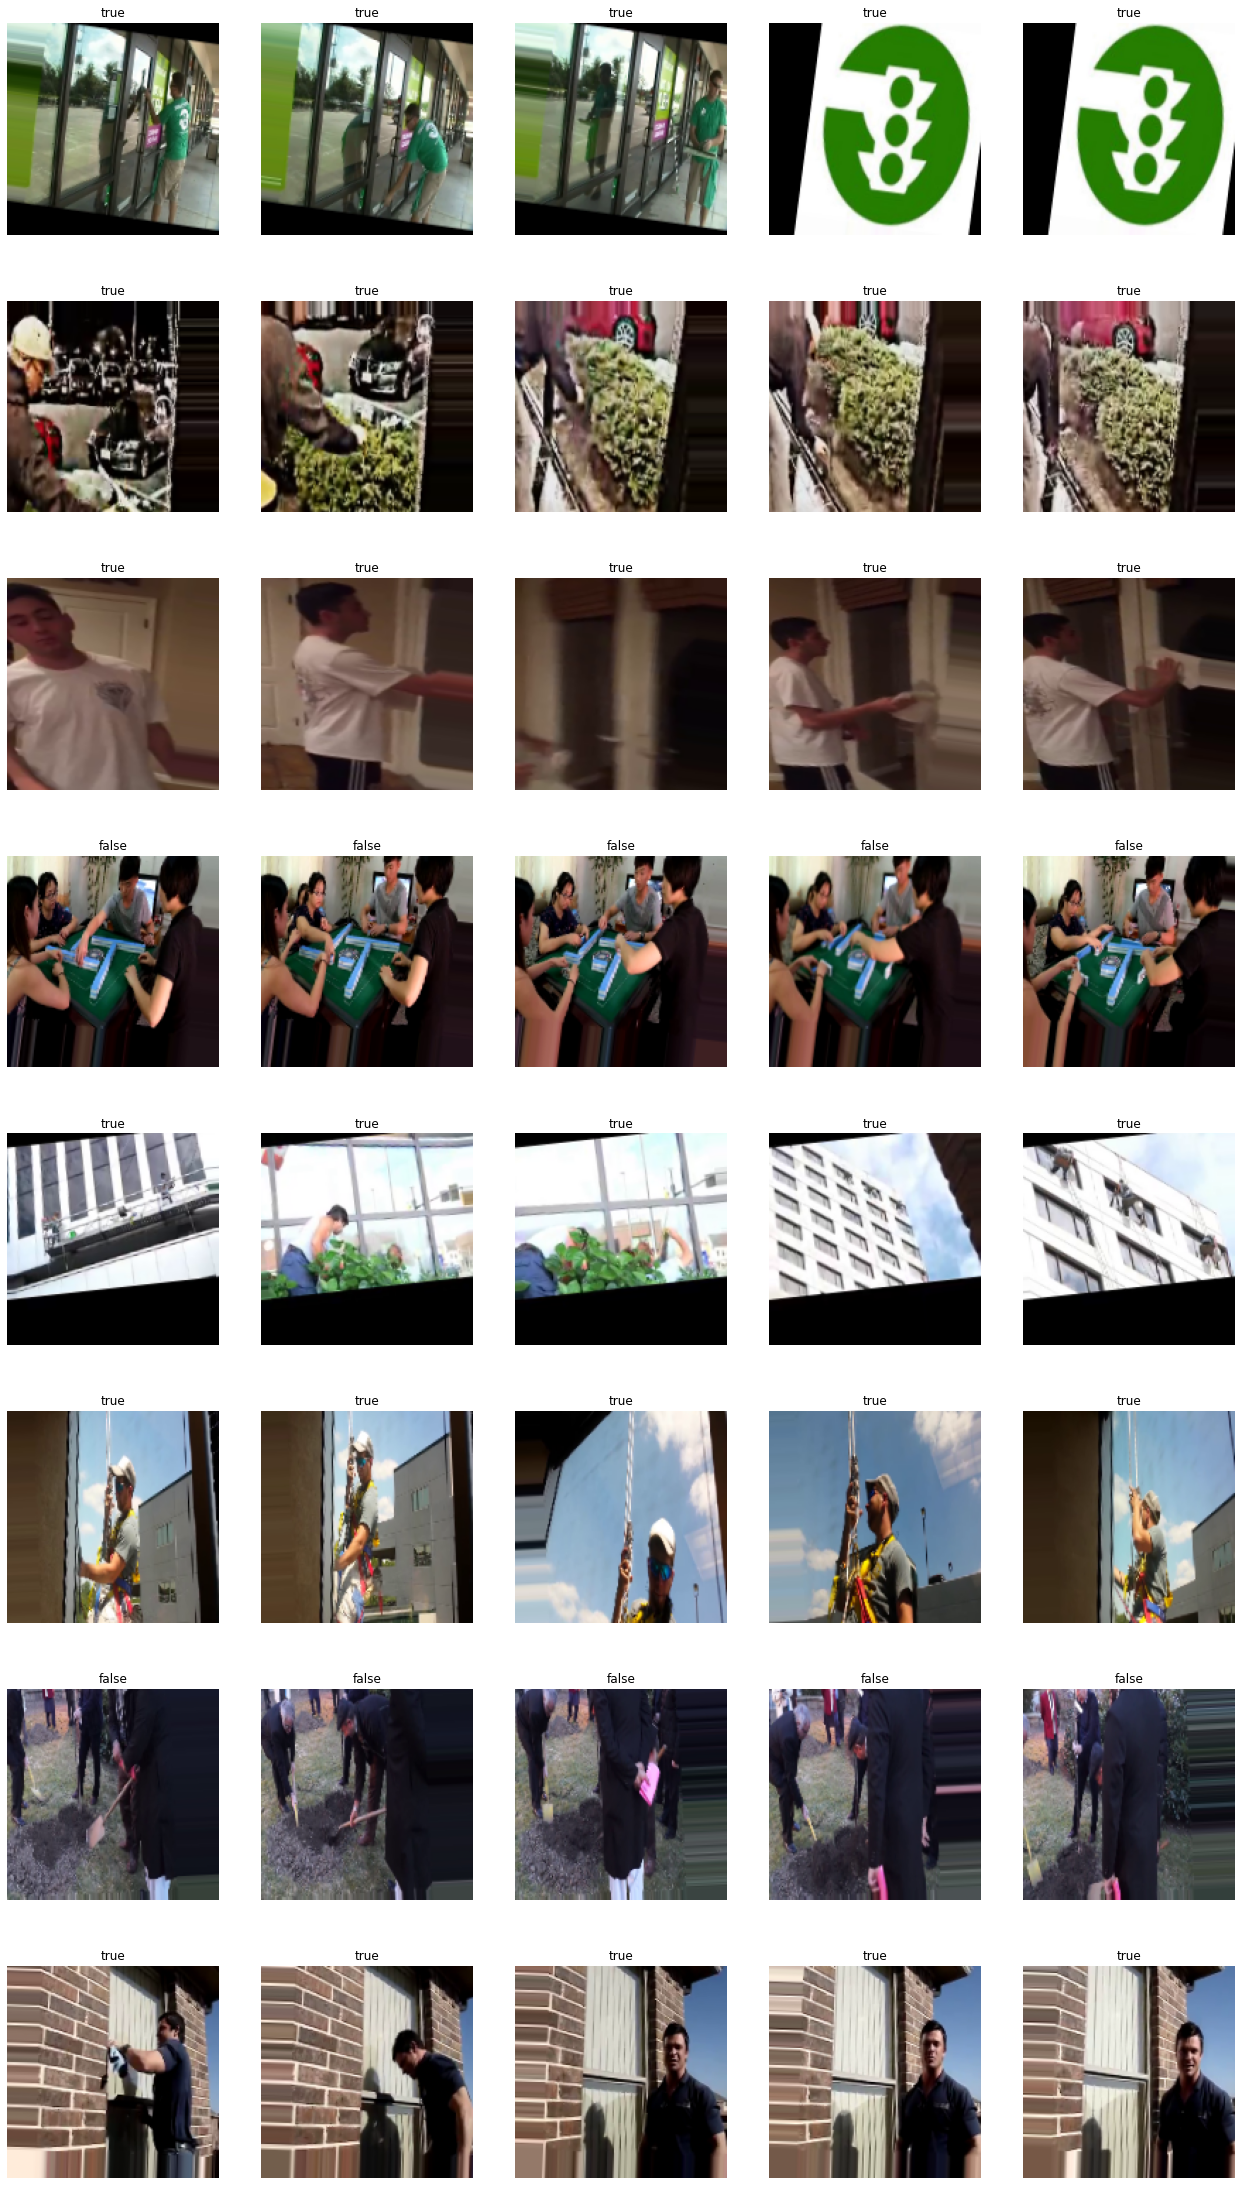

In [ ]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [ ]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.applications import Xception


In [ ]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 5, 2048)           20861480  
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                540928    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

In [ ]:
from keras.optimizers import Adam

optimizer= Adam(0.0001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

Try 1: split_val=.2, Adam(0.001), steps_per_epoch = 20, epochs=35, validation_steps=10, NBFRAME = 15
, BS = 15. ACCURACY: 72




Try 1: split_val=.2, Adam(0.0001), steps_per_epoch = 20, epochs=30, validation_steps=10, NBFRAME = 5
, BS = 8. ACCURACY: 74.7

try 3: lr = 0.001 LSTM

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'cleaningwindows_Xcep_sub8.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 35, #23 43
                    epochs=30, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/30
28/35 [=======================>......] - ETA: 1s - loss: 0.6934 - accuracy: 0.5273

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


29/35 [=======================>......] - ETA: 1s - loss: 0.6935 - accuracy: 0.5271

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - 12s 239ms/step - loss: 0.6938 - accuracy: 0.5274 - val_loss: 0.6835 - val_accuracy: 0.7625
Epoch 2/30
35/35 [==============================] - 7s 193ms/step - loss: 0.6888 - accuracy: 0.5115 - val_loss: 0.6704 - val_accuracy: 0.7625
Epoch 3/30
35/35 [==============================] - 7s 194ms/step - loss: 0.6792 - accuracy: 0.6061 - val_loss: 0.6508 - val_accuracy: 0.8500
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7227

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.325.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 192ms/step - loss: 0.6506 - accuracy: 0.7225 - val_loss: 0.5870 - val_accuracy: 0.8375
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7669

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 194ms/step - loss: 0.6155 - accuracy: 0.7674 - val_loss: 0.5103 - val_accuracy: 0.8481
Epoch 6/30
 2/35 [>.............................] - ETA: 6s - loss: 0.5875 - accuracy: 0.7812

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


16/35 [============>.................] - ETA: 3s - loss: 0.6014 - accuracy: 0.7299

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 195ms/step - loss: 0.5711 - accuracy: 0.7734 - val_loss: 0.4450 - val_accuracy: 0.8375
Epoch 7/30
 5/35 [===>..........................] - ETA: 5s - loss: 0.4662 - accuracy: 0.8233

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


 7/35 [=====>........................] - ETA: 5s - loss: 0.4666 - accuracy: 0.8266

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8277

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 191ms/step - loss: 0.4776 - accuracy: 0.8275 - val_loss: 0.3280 - val_accuracy: 0.9241
Epoch 8/30
35/35 [==============================] - 7s 192ms/step - loss: 0.3942 - accuracy: 0.8716 - val_loss: 0.3472 - val_accuracy: 0.8625
Epoch 9/30
35/35 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8404

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 193ms/step - loss: 0.3757 - accuracy: 0.8413 - val_loss: 0.2828 - val_accuracy: 0.9114
Epoch 10/30
16/35 [============>.................] - ETA: 3s - loss: 0.3180 - accuracy: 0.8854

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 195ms/step - loss: 0.3286 - accuracy: 0.8792 - val_loss: 0.3839 - val_accuracy: 0.8375
Epoch 11/30
35/35 [==============================] - 7s 191ms/step - loss: 0.3188 - accuracy: 0.8659 - val_loss: 0.4681 - val_accuracy: 0.8125
Epoch 12/30
35/35 [==============================] - 7s 191ms/step - loss: 0.2735 - accuracy: 0.8854 - val_loss: 0.2817 - val_accuracy: 0.9000
Epoch 13/30
 3/35 [=>............................] - ETA: 5s - loss: 0.3493 - accuracy: 0.8125

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


28/35 [=======================>......] - ETA: 1s - loss: 0.2939 - accuracy: 0.8842

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8890

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 190ms/step - loss: 0.2884 - accuracy: 0.8896 - val_loss: 0.3097 - val_accuracy: 0.8608
Epoch 14/30
17/35 [=============>................] - ETA: 3s - loss: 0.3184 - accuracy: 0.8676

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8719

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.325.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 191ms/step - loss: 0.2962 - accuracy: 0.8722 - val_loss: 0.4256 - val_accuracy: 0.8481
Epoch 15/30
35/35 [==============================] - 7s 192ms/step - loss: 0.3018 - accuracy: 0.8996 - val_loss: 0.2761 - val_accuracy: 0.9000
Epoch 16/30
35/35 [==============================] - 7s 192ms/step - loss: 0.2726 - accuracy: 0.8984 - val_loss: 0.3525 - val_accuracy: 0.8625
Epoch 17/30
 8/35 [=====>........................] - ETA: 4s - loss: 0.1439 - accuracy: 0.9521

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 192ms/step - loss: 0.2149 - accuracy: 0.9133 - val_loss: 0.2057 - val_accuracy: 0.8875
Epoch 18/30
25/35 [====================>.........] - ETA: 1s - loss: 0.2612 - accuracy: 0.8687

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.8777

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.325.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 192ms/step - loss: 0.2505 - accuracy: 0.8782 - val_loss: 0.1988 - val_accuracy: 0.9367
Epoch 19/30
33/35 [===========================>..] - ETA: 0s - loss: 0.3194 - accuracy: 0.8699

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8690

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 195ms/step - loss: 0.3212 - accuracy: 0.8686 - val_loss: 0.1685 - val_accuracy: 0.9494
Epoch 20/30
35/35 [==============================] - 7s 195ms/step - loss: 0.2565 - accuracy: 0.8954 - val_loss: 0.1495 - val_accuracy: 0.9500
Epoch 21/30
25/35 [====================>.........] - ETA: 1s - loss: 0.2177 - accuracy: 0.9351

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


28/35 [=======================>......] - ETA: 1s - loss: 0.2297 - accuracy: 0.9304

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 192ms/step - loss: 0.2499 - accuracy: 0.9215 - val_loss: 0.2196 - val_accuracy: 0.9250
Epoch 22/30
35/35 [==============================] - 7s 191ms/step - loss: 0.2541 - accuracy: 0.9063 - val_loss: 0.2176 - val_accuracy: 0.9250
Epoch 23/30
 4/35 [==>...........................] - ETA: 5s - loss: 0.3360 - accuracy: 0.8359

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 190ms/step - loss: 0.2701 - accuracy: 0.8653 - val_loss: 0.1874 - val_accuracy: 0.9125
Epoch 24/30
 6/35 [====>.........................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9639

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9199

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 191ms/step - loss: 0.2286 - accuracy: 0.9193 - val_loss: 0.2449 - val_accuracy: 0.9114
Epoch 25/30
 9/35 [======>.......................] - ETA: 4s - loss: 0.2697 - accuracy: 0.8777

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


31/35 [=========================>....] - ETA: 0s - loss: 0.2775 - accuracy: 0.8854

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.578.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 194ms/step - loss: 0.2815 - accuracy: 0.8843 - val_loss: 0.3163 - val_accuracy: 0.8750
Epoch 26/30
35/35 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9165

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 191ms/step - loss: 0.2344 - accuracy: 0.9164 - val_loss: 0.3336 - val_accuracy: 0.8861
Epoch 27/30
35/35 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9151

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.201.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.325.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 192ms/step - loss: 0.2312 - accuracy: 0.9154 - val_loss: 0.2034 - val_accuracy: 0.9487
Epoch 28/30
 3/35 [=>............................] - ETA: 5s - loss: 0.2686 - accuracy: 0.8472

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/true/cleaning windows.140.mp4, 0 total, 0 extracted


19/35 [===============>..............] - ETA: 2s - loss: 0.2031 - accuracy: 0.9097

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 196ms/step - loss: 0.2072 - accuracy: 0.9134 - val_loss: 0.2055 - val_accuracy: 0.9250
Epoch 29/30
35/35 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9318

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.325.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 199ms/step - loss: 0.2167 - accuracy: 0.9313 - val_loss: 0.2913 - val_accuracy: 0.8861
Epoch 30/30
 6/35 [====>.........................] - ETA: 5s - loss: 0.1022 - accuracy: 0.9924

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/train/false/not cleaning windows.275.mp4, 0 total, 0 extracted


35/35 [==============================] - 7s 196ms/step - loss: 0.1635 - accuracy: 0.9564 - val_loss: 0.2186 - val_accuracy: 0.9250

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


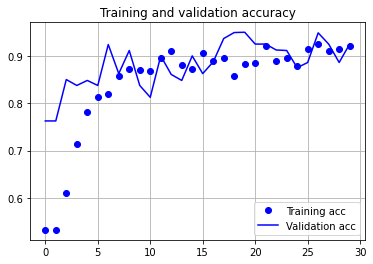

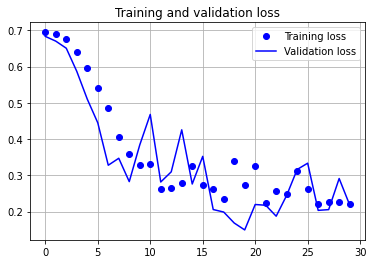

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [ ]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8
glob_pattern='/content/cleaningwindows/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 88 files for train


In [ ]:
model.evaluate(test)

 3/11 [=======>......................] - ETA: 13s - loss: 0.0553 - accuracy: 1.0000

Frame count is not OK for video /content/cleaningwindows/content/kinetics700/test/false/not cleaning windows.27.mp4, 0 total, 0 extracted


11/11 [==============================] - 23s 2s/step - loss: 0.3798 - accuracy: 0.8621


[0.3797876536846161, 0.8620689511299133]

In [ ]:
!cp -a '/content/cleaningwindows_Xcep_sub8.h5' '/content/drive/MyDrive/Colab Notebooks/Submission 8'